In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# @formatter:off

In [2]:
! ls /media/maciek/207GB/Documents/PhD/data/UCI-Benchmark/ds
! ls shared/UCI-Benchmark/ds

ls: cannot access '/media/maciek/207GB/Documents/PhD/data/UCI-Benchmark/ds': No such file or directory
multivariate					summary-univariate-1.csv
new_multivariate_tuningn-4-rbf-sbc-dtw-bkp.csv	uni-tuning-df.csv
summary-multi-1.csv				univariate


# Clean Optuna DB

In [2]:
import os
import sqlite3
import tempfile

# new_tempdir = os.path.abspath("../../../../fast/tmp")
new_tempdir = os.path.abspath("fast/tmp")
# print(new_tempdir)
os.makedirs(new_tempdir, exist_ok=True)

os.environ["TMPDIR"] = new_tempdir
tempfile.tempdir = new_tempdir
print(tempfile.gettempdir())
test_file = os.path.join(new_tempdir, "test.db")
with open(test_file, "w") as f:
    f.write("test")

db_path = f"{new_tempdir}/optuna.db"
study = None

if os.path.exists(db_path):
    os.remove(db_path)

conn = sqlite3.connect(db_path)
conn.execute("PRAGMA journal_mode=WAL;")  # Włączenie trybu WAL

cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS studies")
cursor.execute("DROP TABLE IF EXISTS trials")
cursor.execute("DROP TABLE IF EXISTS trial_params")
cursor.execute("DROP TABLE IF EXISTS trial_values")

conn.commit()
conn.close()

! ls -ld fast/tmp
! ls fast/tmp

/home/jovyan/fast/tmp
drwxr-xr-x 3 jovyan users 4096 Feb 12 08:05 fast/tmp
__autograph_generated_file0qlpqn5b.py  __autograph_generated_fileim_bmzyn.py
__autograph_generated_file0vka_2mm.py  __autograph_generated_filein86owkj.py
__autograph_generated_file1u8phslv.py  __autograph_generated_filej_9cpiy1.py
__autograph_generated_file47r5gxq2.py  __autograph_generated_filek83j5c3o.py
__autograph_generated_file5_epdtv5.py  __autograph_generated_filekwszixle.py
__autograph_generated_file5hhrixb2.py  __autograph_generated_filel67hcmlg.py
__autograph_generated_file85stfxsy.py  __autograph_generated_filemu8679uq.py
__autograph_generated_filea2qb4it5.py  __autograph_generated_filepi7ikwkw.py
__autograph_generated_filea_ghgtz6.py  __autograph_generated_filerd4ak2p6.py
__autograph_generated_filec2aacpc1.py  __autograph_generated_file_vgeab4g.py
__autograph_generated_filecz2fh2zs.py  __autograph_generated_filewg8b7t21.py
__autograph_generated_filef0dfi32j.py  __autograph_generated_fileymwfa1rf.py
_

In [ ]:
# @formatter:on

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # 0 - first gpu, 1 - second, "0,1" - both gpu, first used, "-1" - none

import numpy

print(numpy.__version__)

import numpy as np

np.object = object
np.int = int
np.float = float
np.bool = bool
np.typeDict = np.sctypeDict

os.environ[
    'TF_CPP_MIN_LOG_LEVEL'] = '2'  # https://stackoverflow.com/questions/64434655/stop-tensorflow-from-printing-to-the-console
import tensorflow as tf

import csv
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import re
import optuna
import json
import matplotlib.pyplot as plt
import gc
import shutil
import logging

from collections import Counter, defaultdict
from scipy.spatial.distance import cosine
from scipy.stats import kruskal, mannwhitneyu, percentileofscore
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from typing import Any, Dict, List, Optional, Tuple, Union
from statistics import mean, median, quantiles
from pathlib import Path

print("Pandas version:", pd.__version__)
# print("Scikit-Learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)
# print("PyTorch version:", torch.__version__)

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

1.24.3
Pandas version: 1.5.3
TensorFlow version: 2.13.1


/home/jovyan/.conda/envs/uci_38v4/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read explanations for a given TS

In [4]:
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import ConvLSTM1D

USE_H5_COMPATIBILITY = False

# data_path = '/media/maciek/207GB/Documents/PhD/data/UCI-Benchmark/' # "shared/UCI-Benchmark/"
data_path = "shared/UCI-Benchmark/"
datasets_uni = [f.name for f in os.scandir(data_path + 'ds/univariate') if f.is_dir() and not f.name.startswith('.')]
datasets_multi = [f.name for f in os.scandir(data_path + '/ds/multivariate') if
                  f.is_dir() and not f.name.startswith('.')]

explain_prefixes = {
    "anchor": "av",
    "shap": "sv",
    "lime": "lv",
    "anchor_to_importances": "av2importance",
    "shap_to_rules": "sv2rul",
    "lime_to_rules": "lv2rul",
}
file_suffixes = ['tr.pickle', 'ts.pickle']

print(datasets_uni[:2])

['DodgerLoopGame', 'ProximalPhalanxTW']


## Load & Save

In [5]:
def load_explanations(dataset: str,
                      raise_on_error: bool = True,
                      print_on_error: bool = True,
                      load_model: bool = False,
                      compatibility: bool = False,
                      additional_postfixes: Optional[List[str]] = None) -> Dict[str, Any]:
    """
    Loads explanation files and dataset splits (trainX, trainy, testX, testy) for the given dataset.

    If additional_postfixes is provided, it will attempt to load explanation files
    for each explanation type using each postfix in the list. For example, if the
    explanation prefix is "av" and additional_postfixes = ["_globalT_", "_globalF_"],
    it will attempt to load:
    av_globalT_tr.pickle, av_globalT_ts.pickle, av_globalF_tr.pickle, av_globalF_ts.pickle

    If additional_postfixes is None, it loads the default files (e.g. avtr.pickle, avts.pickle).

    Args:
        dataset (str): The name of the dataset to load.
        raise_on_error (bool): Whether to raise an error if a file is missing.
        print_on_error (bool): Whether to print if a file is missing.
        load_model (bool): Whether to load the model.
        compatibility (bool): Compatibility mode for loading models.
        additional_postfixes (Optional[List[str]]): A list of postfixes to be appended to
                                                    explanation prefixes for loading.
                                                    If None, default loading is performed.

    Returns:
        Dict[str, Any]: A dictionary containing explanations and dataset splits.
    """
    loaded_files: Dict[str, Any] = {}

    if dataset in datasets_multi:
        directory = 'multivariate'
    elif dataset in datasets_uni:
        directory = 'univariate'
    else:
        raise ValueError(f"Dataset {dataset} not recognized")

    dataset_path = os.path.join(data_path, 'ds', directory, dataset)
    print(f"Dataset {dataset} is {directory}")

    if load_model:
        tf_model_path = os.path.join(dataset_path, "model_tf/1")
        h5_model_path = os.path.join(dataset_path, "model.h5")

        if not compatibility and os.path.exists(tf_model_path):
            print("Loading model in tf format...")
            model = tf.keras.models.load_model(tf_model_path)
        elif os.path.exists(h5_model_path):
            print("Loading model in h5 format...")
            model = tf.keras.models.load_model(
                h5_model_path, custom_objects={'GlorotUniform': glorot_uniform, 'ConvLSTM1D': ConvLSTM1D})
            # Save model in tf format if loaded from h5
            if not os.path.exists(tf_model_path):
                os.makedirs(tf_model_path, exist_ok=True)
                model.save(tf_model_path, save_format='tf')
                print(f"Model {dataset} saved in TensorFlow format at {tf_model_path}")
        else:
            raise FileNotFoundError(
                f'No model found in SavedModel or H5 formats for {dataset} in {directory} directory.')
        loaded_files["model"] = model

    # Load explanation files
    if additional_postfixes is None:
        additional_postfixes = []
    additional_postfixes = [""] + additional_postfixes

    for prefix_name, prefix in explain_prefixes.items():
        for postfix in additional_postfixes:
            for suffix in file_suffixes:
                file_path = os.path.join(dataset_path, f"{prefix}{postfix}{suffix}")
                if not os.path.isfile(file_path):
                    if raise_on_error:
                        raise FileNotFoundError(f"Missing file: {file_path}")
                    else:
                        if print_on_error:
                            print(f"Missing file: {file_path}")
                        continue
                with open(file_path, 'rb') as file:
                    if postfix == "":
                        loaded_files[f"{prefix_name}_{suffix.replace('.pickle', '')}"] = pickle.load(file)
                    else:
                        loaded_files[f"{prefix_name}{postfix}{suffix.replace('.pickle', '')}"] = pickle.load(file)

    # Load dataset splits
    split_files = ["trainX.pickle", "trainy.pickle", "testX.pickle", "testy.pickle"]
    for split_file in split_files:
        file_path = os.path.join(dataset_path, split_file)
        if not os.path.isfile(file_path):
            if raise_on_error:
                raise FileNotFoundError(f"Missing dataset split file: {file_path}")
            else:
                if print_on_error:
                    print(f"Missing dataset split file: {file_path}")
                continue
        with open(file_path, 'rb') as file:
            loaded_files[split_file.replace(".pickle", "")] = pickle.load(file)

    for key, value in loaded_files.items():
        print(f"{key}: type= {type(value)}")

    return loaded_files

def save_explanations(dataset: str,
                      explanation_type: str,
                      additional_postfix: str = "",
                      explanations_train: Optional[Any] = None,
                      explanations_test: Optional[Any] = None,
                      raise_on_error: bool = True) -> None:
    """
    Saves explanation files for the given dataset and explanation type.

    The function uses the explanation_type to determine the file prefix
    (based on the explain_prefixes dictionary). It then creates up to two files:
    <prefix>tr.pickle for training explanations and <prefix>ts.pickle for testing explanations,
    depending on which arguments are provided.

    Args:
        dataset (str): The name of the dataset to save the explanations for.
        explanation_type (str): The type of explanation to save
                                (keys from explain_prefixes, e.g. "anchor", "shap", "lime").
        additional_postfix (str): .
        explanations_train (Optional[Any]): The training explanations object to be saved. If None, no train file is saved.
        explanations_test (Optional[Any]): The testing explanations object to be saved. If None, no test file is saved.
        raise_on_error (bool): Whether to raise an error if conditions (e.g., directory not found)
                               are not met.

    Raises:
        ValueError: If dataset is not recognized or explanation_type is not in explain_prefixes.
        FileNotFoundError: If the dataset directory does not exist and raise_on_error is True.
        ValueError: If both explanations_train and explanations_test are None.
    """
    # Determine directory type (multivariate or univariate)
    if dataset in datasets_multi:
        directory = 'multivariate'
    elif dataset in datasets_uni:
        directory = 'univariate'
    else:
        raise ValueError(f"Dataset {dataset} not recognized")

    # Validate explanation type
    if explanation_type not in explain_prefixes:
        raise ValueError(
            f"Explanation type {explanation_type} not recognized. Valid keys: {list(explain_prefixes.keys())}")

    # Construct dataset path
    dataset_path = os.path.join(data_path, 'ds', directory, dataset)
    if not os.path.isdir(dataset_path):
        if raise_on_error:
            raise FileNotFoundError(f"Dataset directory not found: {dataset_path}")
        else:
            print(f"Dataset directory not found: {dataset_path}")
            return

    # Retrieve prefix from explanation_type
    prefix = explain_prefixes[explanation_type] + additional_postfix

    # If both explanations are None, nothing to save.
    if explanations_train is None and explanations_test is None:
        raise ValueError("Both training and testing explanations are None. Nothing to save.")

    # Save training explanations if provided
    if explanations_train is not None:
        train_file_name = prefix + "tr.pickle"
        train_file_path = Path(dataset_path, train_file_name)
        with open(train_file_path, 'wb') as f:
            pickle.dump(explanations_train, f)
        print(f"Saved training explanations: {train_file_path}")

    # Save testing explanations if provided
    if explanations_test is not None:
        test_file_name = prefix + "ts.pickle"
        test_file_path = Path(dataset_path, test_file_name)
        with open(test_file_path, 'wb') as f:
            pickle.dump(explanations_test, f)
        print(f"Saved testing explanations: {test_file_path}")

## Univariate example

In [6]:
print(len(datasets_uni), datasets_uni)

84 ['DodgerLoopGame', 'ProximalPhalanxTW', 'DodgerLoopDay', 'ECGFiveDays', 'UMD', 'Plane', 'ECG200', 'TwoPatterns', 'GunPointAgeSpan', 'DiatomSizeReduction', 'UWaveGestureLibraryAll', 'MedicalImages', 'Meat', 'Trace', 'MiddlePhalanxOutlineAgeGroup', 'Chinatown', 'DistalPhalanxOutlineAgeGroup', 'WormsTwoClass', 'DistalPhalanxOutlineCorrect', 'Strawberry', 'OliveOil', 'UWaveGestureLibraryX', 'SmoothSubspace', 'Fungi', 'ElectricDevices', 'SwedishLeaf', 'CricketX', 'ECG5000', 'PhalangesOutlinesCorrect', 'FaceFour', 'SyntheticControl', 'FordA', 'PowerCons', 'BeetleFly', 'GunPointMaleVersusFemale', 'Yoga', 'Herring', 'Crop', 'RefrigerationDevices', 'Worms', 'OSULeaf', 'ItalyPowerDemand', 'GunPoint', 'CBF', 'Symbols', 'ToeSegmentation2', 'TwoLeadECG', 'SmallKitchenAppliances', 'ShapesAll', 'ScreenType', 'Computers', 'CricketY', 'SonyAIBORobotSurface2', 'Wafer', 'MiddlePhalanxOutlineCorrect', 'Lightning2', 'UWaveGestureLibraryY', 'Wine', 'ProximalPhalanxOutlineCorrect', 'ShapeletSim', 'Cricket

In [8]:
lf_Wafer = load_explanations("Wafer", raise_on_error=False, compatibility=USE_H5_COMPATIBILITY,
                             additional_postfixes=["_globalT_", "_globalF_", "_best_"])

Dataset Wafer is univariate
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/av_globalT_tr.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/av_globalT_ts.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/av_globalF_tr.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/av_globalF_ts.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/sv_globalT_tr.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/sv_globalT_ts.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/sv_globalF_tr.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/sv_globalF_ts.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/lv_globalT_tr.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/lv_globalT_ts.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/lv_globalF_tr.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/lv_globalF_ts.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/av2im

In [9]:
lf_Wafer['anchor_tr'][-3:]

[[{'index': 5370,
   'success': True,
   'prediction': '1',
   'rule': {'feature_34': ['>-0.25'], 'feature_35': ['>0.97']},
   'anchor_method': 'alibi',
   'anchor': ['feature_35 > 0.97', 'feature_34 > -0.25'],
   'confidence': 0.9302325581395349,
   'coverage': 0.25,
   'exp_count': 2}],
 [{'index': 5371,
   'success': True,
   'prediction': '0',
   'rule': {'feature_9': ['>-1.11'],
    'feature_20': ['>-0.69'],
    'feature_26': ['<=0.04'],
    'feature_29': ['<=-0.18'],
    'feature_34': ['<=1.00'],
    'feature_47': ['>-0.01'],
    'feature_112': ['<=-0.86'],
    'feature_121': ['<=-0.88'],
    'feature_134': ['>-1.03'],
    'feature_142': ['>-1.08']},
   'anchor_method': 'marcotcr',
   'anchor': ['feature_47 > -0.01',
    'feature_29 <= -0.18',
    'feature_112 <= -0.86',
    'feature_9 > -1.11',
    'feature_134 > -1.03',
    'feature_142 > -1.08',
    'feature_20 > -0.69',
    'feature_34 <= 1.00',
    'feature_121 <= -0.88',
    'feature_26 <= 0.04'],
   'confidence': 0.9415929

In [8]:
print(lf_Wafer['lime_tr'].shape, lf_Wafer['shap_tr'].shape)

(5373, 152, 1) (5373, 152, 1)


In [9]:
print(lf_Wafer['trainX'].shape, lf_Wafer['trainy'].shape)
print(lf_Wafer['testX'].shape, lf_Wafer['testy'].shape)

(5373, 152, 1) (5373, 2)
(1791, 152, 1) (1791, 2)


In [7]:
def chceck_explanations(feature_based: np.ndarray, rule_based: List[List[Dict]]) -> None:
    lime_total_indices = feature_based.shape[0]
    anchor_indices = [item[0]['index'] for item in rule_based]

    anchor_index_range = (min(anchor_indices), max(anchor_indices))

    all_indices = set(range(lime_total_indices))
    missing_indices = sorted(all_indices - set(anchor_indices))

    failed_indices = [item[0]['index'] for item in rule_based if not item[0]['success']]

    errors = [item[0]['error'] for item in rule_based if not item[0]['success'] and 'error' in item[0]]
    top_10_errors = Counter(errors).most_common(10)

    anchor_methods = [item[0]['anchor_method'] for item in rule_based if
                      item[0]['success'] and 'anchor_method' in item[0]]
    top_10_anchor_methods = Counter(anchor_methods).most_common(10)
    marcotcr_items = [item[0] for item in rule_based if
                      item[0]['success'] and 'anchor_method' in item[0] and item[0]['anchor_method'] == 'marcotcr']

    print(f"\nAnchor index range: {anchor_index_range}")
    print(f"\nMissing indices: {missing_indices[:10]}... (total: {len(missing_indices)})")
    print(f"\nFailed indices: {failed_indices[:10]}... (total: {len(failed_indices)})")

    print("\nTop anchor methods:")
    print("\n".join([f"{count}: {anchor_method}" for anchor_method, count in top_10_anchor_methods]))
    if len(marcotcr_items):
        print(
            f"\nExample of anchor method='marcotcr': {marcotcr_items[:1][0]['rule']}... (total: {len(marcotcr_items)})")

    print("\nTop 10 errors:")
    print("\n".join([f"{count}: {error}" for error, count in top_10_errors]))


In [9]:
chceck_explanations(lf_Wafer['lime_tr'], lf_Wafer['anchor_tr'])
chceck_explanations(lf_Wafer['lime_ts'], lf_Wafer['anchor_ts'])


Anchor index range: (0, 5372)

Missing indices: []... (total: 0)

Failed indices: [74, 78, 94, 108, 172, 178, 179, 193, 194, 200]... (total: 478)

Top anchor methods:
4859: alibi
36: marcotcr

Example of anchor method='marcotcr': {'feature_29': ['<=-0.18'], 'feature_38': ['>-1.20'], 'feature_110': ['<=-0.86'], 'feature_112': ['<=-0.86'], 'feature_123': ['<=-0.92']}... (total: 36)

Top 10 errors:
477: A process in the process pool was terminated abruptly while the future was running or pending.,
Traceback (most recent call last):
  File "fast/tmp/ipykernel_416584/1408686583.py", line 281, in anchor_pool_worker
    result = future.result(timeout=t_out)
  File "/home/jovyan/.conda/envs/uci_38v4/lib/python3.8/concurrent/futures/_base.py", line 444, in result
    return self.__get_result()
  File "/home/jovyan/.conda/envs/uci_38v4/lib/python3.8/concurrent/futures/_base.py", line 389, in __get_result
    raise self._exception
concurrent.futures.process.BrokenProcessPool: A process in the pr

## Multivariate example

In [8]:
print(len(datasets_multi), datasets_multi)

20 ['ArticularyWordRecognition', 'Handwriting', 'BasicMotions', 'HandMovementDirection', 'Heartbeat', 'FaceDetection', 'SelfRegulationSCP2', 'NATOPS', 'ERing', 'EthanolConcentration', 'FingerMovements', 'Epilepsy', 'Libras', 'AtrialFibrillation', 'PenDigits', 'Cricket', 'LSST', 'UWaveGestureLibrary', 'RacketSports', 'SelfRegulationSCP1']


In [11]:
lf_Libras = load_explanations("Libras", raise_on_error=False, compatibility=USE_H5_COMPATIBILITY,
                              additional_postfixes=["_globalT_", "_globalF_", "_best_"])

Dataset Libras is multivariate
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/av_globalT_tr.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/av_globalT_ts.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/av_globalF_tr.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/av_globalF_ts.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/av_best_tr.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/av_best_ts.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/sv_globalT_tr.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/sv_globalT_ts.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/sv_globalF_tr.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/sv_globalF_ts.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/sv_best_tr.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/sv_best_ts.pickle
Missing file: shared/UCI-Benchmar

In [13]:
print(lf_Libras['lime_tr'].shape, lf_Libras['shap_tr'].shape)
print(lf_Libras['trainX'].shape, lf_Libras['trainy'].shape)
print(lf_Libras['testX'].shape, lf_Libras['testy'].shape)

(270, 45, 2) (270, 45, 2)
(270, 45, 2) (270, 15)
(90, 45, 2) (90, 15)


In [14]:
lf_Libras['testy'][-10:]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

# Models

## Univariate

In [54]:
lf_Wafer = load_explanations("Wafer", raise_on_error=False, load_model=True, compatibility=USE_H5_COMPATIBILITY,
                             additional_postfixes=["_globalT_", "_globalF_", "_best_"])

Dataset Wafer is univariate
Loading model in tf format...
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/av_globalT_tr.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/av_globalT_ts.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/av_globalF_tr.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/av_globalF_ts.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/sv_globalT_tr.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/sv_globalT_ts.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/sv_globalF_tr.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/sv_globalF_ts.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/lv_globalT_tr.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/lv_globalT_ts.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/lv_globalF_tr.pickle
Missing file: shared/UCI-Benchmark/ds/univariate/Wafer/lv_globalF_ts.pickle
Missing file: shared/UCI-Bench

In [17]:
test_sample = lf_Wafer["testX"][1234:1234 + 5]
test_sample.shape

(5, 152, 1)

In [18]:
np.argmax(lf_Wafer["model"](test_sample), axis=1)  #[0].numpy()

array([1, 1, 0, 1, 1])

## Multivariate

In [50]:
lf_Libras = load_explanations("Libras", raise_on_error=False, load_model=True, compatibility=USE_H5_COMPATIBILITY,
                              additional_postfixes=["_globalT_", "_globalF_", "_best_"])

Dataset Libras is multivariate
Loading model in tf format...
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/av_globalT_tr.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/av_globalT_ts.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/av_globalF_tr.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/av_globalF_ts.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/sv_globalT_tr.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/sv_globalT_ts.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/sv_globalF_tr.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/sv_globalF_ts.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/lv_globalT_tr.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/lv_globalT_ts.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/lv_globalF_tr.pickle
Missing file: shared/UCI-Benchmark/ds/multivariate/Libras/lv_globalF_t

In [20]:
test_sample = lf_Libras["testX"][12:12 + 5]
test_sample.shape

(5, 45, 2)

In [21]:
np.argmax(lf_Libras["model"](test_sample), axis=1)

array([ 7, 10,  3, 11, 13])

# Similarity

In [9]:
def parse_rule(rule: str) -> tuple:
    """Parses a rule into an operator and a value."""
    operator = rule[:2] if rule[1] in "=<" else rule[0]
    value = float(rule[2:]) if rule[1] in "=<" else float(rule[1:])
    return operator, value


def calculate_overlap_degree(rules1: list, rules2: list, low: float = 0.0, high: float = 10.0) -> float:
    """
    Calculates the degree of overlap between two sets of rules.

    Each set of rules can contain one or two rules, defining a range.
    If a set contains one rule, the default boundaries (low and high) are used to define the range.
    If a set contains two rules, they are interpreted as lower and upper bounds of the range.
    The function returns the proportion of the overlap length to the average range length.

    Args:
    rules1 (list): The first set of rules.
    rules2 (list): The second set of rules.
    low (float): The default lower boundary if only one rule is provided.
    high (float): The default upper boundary if only one rule is provided.

    Returns:
    float: The degree of overlap between the two sets of rules.
    """

    def get_range(rules: list) -> tuple:
        """Determines the range defined by the rules."""
        assert len(rules) <= 2, "Each rule set must contain at most two rules."

        if len(rules) == 1:
            op, val = parse_rule(rules[0])
            return (max(val, low) if op in ['>=', '>'] else low, min(val, high) if op in ['<=', '<'] else high)
        else:
            op1, val1 = parse_rule(rules[0])
            op2, val2 = parse_rule(rules[1])
            lower_bound = max(val1, low) if op1 in ['>=', '>'] else max(val2, low)
            upper_bound = min(val1, high) if op1 in ['<=', '<'] else min(val2, high)
            return (lower_bound, upper_bound)

    range1 = get_range(rules1)
    range2 = get_range(rules2)

    # Calculating the overlap
    overlap_start = max(range1[0], range2[0])
    overlap_end = min(range1[1], range2[1])

    # Calculating the degree of overlap
    if overlap_start < overlap_end:
        overlap_length = overlap_end - overlap_start
        average_range_length = (range1[1] - range1[0] + range2[1] - range2[0]) / 2
        return overlap_length / average_range_length
    else:
        return 0.0  # No overlap


def calculate_jaccard_distance(explanation_i: List[Dict],
                               explanation_j: List[Dict],
                               take_prediction_into_account: bool = False) -> float:
    """
    Calculates the Jaccard distance between two explanations using the degree of overlap.

    The function computes the overlap degree for each column present in both explanations.
    If a column is present in one explanation but not in the other, its contribution to the metric is zero.
    Columns not present in either explanation are ignored.

    Args:
    explanation_1 (List[Dict]): The first explanation.
    explanation_2 (List[Dict]): The second explanation.

    Returns:
    float: The Jaccard distance between the two explanations.
    """

    def create_rule_set(explanation: List[Dict]) -> Dict[str, list]:
        rule_set = {}
        for exp in explanation:
            for col, rules in exp[0]['rule'].items():
                rule_set[col] = rules
        return rule_set

    set_i = create_rule_set(explanation_i)
    set_j = create_rule_set(explanation_j)

    # Calculating overlaps
    total_overlap = 0
    common_columns = set(set_i.keys()).intersection(set(set_j.keys()))
    for col in common_columns:
        overlap_degree = calculate_overlap_degree(set_i[col], set_j[col], 0.0, 10.0)
        total_overlap += overlap_degree

    # Calculating Jaccard distance
    total_columns = len(set(set_i.keys()).union(set(set_j.keys())))
    if total_columns == 0:
        return 0.0
    jaccard_distance = 1 - total_overlap / total_columns
    if take_prediction_into_account:
        prediction_i = explanation_i[0][0]['prediction']
        prediction_j = explanation_j[0][0]['prediction']
        delta = int(prediction_i == prediction_j)
        # if delta > 0:
        #     print("Jaccard distance: taking into account different predictions")
        jaccard_distance += 1 - delta
    return jaccard_distance


def calculate_explanation_similarity(explanation_i: Union[List[List[Dict[str, Any]]], np.array], pred_i: float,
                                     explanation_j: Union[List[List[Dict[str, Any]]], np.array], pred_j: float,
                                     feature_names: List[str]) -> float:
    """
    Calculate the similarity between two explanations, which can be either feature importances or rule-based.
    
    For rule-based explanations, it uses the Jaccard distance. For feature importances, it uses the cosine of the angle between vectors.
    If explanations are of different types, it converts the rule-based explanation to a feature importance vector.
    
    :param explanation_i: First explanation which can be a list of rules or an array of feature importances.
    :param pred_i: Prediction of anomaly for explanation_i (0 or 1).
    :param explanation_j: Second explanation which can be a list of rules or an array of feature importances.
    :param pred_j: Prediction of anomaly for explanation_j (0 or 1).
    :param feature_names: List of feature names to consider in the comparison.
    :return: A float representing the similarity between the two explanations.
    """

    if not (isinstance(explanation_i, list) or isinstance(explanation_i, np.ndarray)):
        raise ValueError("Explanation i must be either a list (rules) or a numpy array (feature importance).")
    if not (isinstance(explanation_j, list) or isinstance(explanation_j, np.ndarray)):
        raise ValueError("Explanation j must be either a list (rules) or a numpy array (feature importance).")

    def create_rule_set(explanation: List[Dict]) -> Dict[str, list]:
        rule_set = {}
        for exp in explanation:
            for col, rules in exp[0]['rule'].items():
                rule_set[col] = rules
        return rule_set

    def parse_rule(rule: str) -> tuple:
        """Parses a rule into an operator and a value."""
        operator = rule[:2] if rule[1] in "=<" else rule[0]
        value = float(rule[2:]) if rule[1] in "=<" else float(rule[1:])
        return operator, value

    def get_range(rules: list, low: float = 0.0, high: float = 10.0) -> tuple:
        """Determines the range defined by the rules."""
        assert len(rules) <= 2, "Each rule set must contain at most two rules."

        if len(rules) == 1:
            op, val = parse_rule(rules[0])
            return (max(val, low) if op in ['>=', '>'] else low, min(val, high) if op in ['<=', '<'] else high)
        else:
            op1, val1 = parse_rule(rules[0])
            op2, val2 = parse_rule(rules[1])
            lower_bound = max(val1, low) if op1 in ['>=', '>'] else max(val2, low)
            upper_bound = min(val1, high) if op1 in ['<=', '<'] else min(val2, high)
            return (lower_bound, upper_bound)

    def adjust_feature_importance_shape(
            feature_importance: np.ndarray,
            rule_vector: np.ndarray
    ) -> np.ndarray:
        """
        Adjusts the shape of feature_importance to match rule_vector.
    
        Handles cases where feature_importance has an extra dimension (e.g., (n, 1)) or is multivariate (e.g., (n, m)).
        Selects the first series by default for multivariate data.
    
        Args:
            feature_importance (np.ndarray): The feature importance array.
            rule_vector (np.ndarray): The rule vector to match shape with.
    
        Returns:
            np.ndarray: Adjusted feature importance array.
        """
        if feature_importance.shape != rule_vector.shape:
            if len(feature_importance.shape) > 1 and feature_importance.shape[1] == 1:
                feature_importance = np.squeeze(feature_importance)
                print(f"Squeezed feature_importance to shape: {feature_importance.shape}")
            elif len(feature_importance.shape) > 1:
                feature_importance = feature_importance[:, 0]
                print(f"Multivariate data detected. Using first series, shape: {feature_importance.shape}")
            else:
                raise ValueError("Shapes are incompatible and cannot be adjusted automatically.")
        return feature_importance

    # If both explanations are rule-based
    if isinstance(explanation_i, list) and isinstance(explanation_j, list):
        return 1 - (calculate_jaccard_distance(
            explanation_i, explanation_j, take_prediction_into_account=True) / 2)

        # If both explanations are feature importances
    elif isinstance(explanation_i, np.ndarray) and isinstance(explanation_j, np.ndarray):
        cos_angle = (2 - cosine(explanation_i, explanation_j)) / 2
        # print(cos_angle)
        delta_pred = 1 if pred_i == pred_j else 0
        return (cos_angle + delta_pred) / 2

        # If one explanation is rule-based and the other is feature importance
    else:
        if isinstance(explanation_i, list):
            rule_based, feature_importance = explanation_i, explanation_j
        else:
            rule_based, feature_importance = explanation_j, explanation_i

        # Convert rule-based explanation to feature importance vector
        rule_vector = np.zeros(len(feature_names))
        for rule in rule_based[0]:
            for feature, conditions in rule['rule'].items():
                if feature in feature_names:
                    lower_bound, upper_bound = get_range(conditions)
                    # print("feature", feature, "conditions", conditions, "bounds [", lower_bound, "-", upper_bound, "]")
                    importance = 1.0 / (upper_bound - lower_bound + 1e-5)
                    idx = feature_names.index(feature)
                    rule_vector[idx] = importance
        # print(f"rule_vector= {rule_vector.shape}")
        # print(f"feature_importance= {feature_importance.shape}")
        adjusted_feature_importance = adjust_feature_importance_shape(feature_importance, rule_vector)

        # Calculate similarity as per feature importances
        # print("rule_vector", rule_vector, "feature_importance", feature_importance)
        # TODO rule_vector has all non-negative coordinates, while feature_importance not
        cos_angle = (2 - cosine(rule_vector, [abs(f) for f in adjusted_feature_importance])) / 2
        delta_pred = 1 if pred_i == pred_j else 0
        return (cos_angle + delta_pred) / 2

In [12]:
rules_explanation = [
    [{'rule': {'feature_1': ['>0.5'], 'feature_2': ['<=1.0']}}],
    [{'rule': {'feature_3': ['>=0.7', '<1.2']}}],
]
feature_importance = np.array([0.6, 0.4, 0.2])
feature_names = ['feature_1', 'feature_2', 'feature_3']

# Porównanie reguł z wektorem cech
similarity = calculate_explanation_similarity(
    rules_explanation, 1, feature_importance, 0, feature_names
)
print("Similarity:", similarity)

# Porównanie dwóch wektorów cech
similarity_features = calculate_explanation_similarity(
    np.array([0.5, 0.3, 0.1]), 1, np.array([0.4, 0.3, 0.2]), 1, feature_names
)
print("Similarity (features):", similarity_features)

Similarity: 0.4038801930175794
Similarity (features): 0.9932588679725585


In [13]:
# Set N (index of observation from the test set)
N = 10  # Example index from the test set

# Extract data for comparison
rules_explanation = list(lf_Wafer['anchor_ts'][N:N + 1])  # Anchor explanations for test sample N
shap_feature_importance = lf_Wafer['shap_ts'][N]  # SHAP explanations for test sample N
lime_feature_importance = lf_Wafer['lime_ts'][N]  # LIME explanations for test sample N
feature_names = [f"feature_{i}" for i in range(lf_Wafer['testX'].shape[1])]  # Feature names from testX

# Extract prediction values (example: use testy)
pred_anchor = int(rules_explanation[0][0]['prediction'])  # Prediction for the Anchor explanation
pred_model = int(lf_Wafer['testy'][N][1])

print(
    f"rules={rules_explanation}, pred model={pred_model}, pred anchor={pred_anchor}, \n{shap_feature_importance[:5]}, \n{feature_names[:5]}")

rules=[[{'index': 10, 'success': True, 'prediction': '1', 'rule': {'feature_34': ['>1.00'], 'feature_64': ['<=0.82']}, 'anchor_method': 'alibi', 'anchor': ['feature_64 <= 0.82', 'feature_34 > 1.00'], 'confidence': 0.9967741935483871, 'coverage': 0.242, 'exp_count': 2}]], pred model=1, pred anchor=1, 
[[0.00026098]
 [0.00101541]
 [0.00172198]
 [0.00273486]
 [0.00370883]], 
['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']


In [112]:
# Compare rule-based (Anchor) with feature-based (SHAP)
similarity = calculate_explanation_similarity(
    rules_explanation, pred_anchor, shap_feature_importance, pred_model, feature_names
)
print("Similarity (ANCHOR rules vs. SHAP feature importance):", similarity)

# Compare two feature-based explanations (SHAP)
similarity_features = calculate_explanation_similarity(
    lf_Wafer['lime_ts'][N].flatten(),  # LIME explanation for test sample N
    pred_model,
    lf_Wafer['shap_ts'][N].flatten(),  # SHAP explanation for test sample N
    pred_model,
    feature_names
)
print("Similarity (LIME feature importance vs. SHAP feature importance):", similarity_features)

Squeezed feature_importance to shape: (152,)
Similarity (ANCHOR rules vs. SHAP feature importance): 0.7660729783807031
Similarity (LIME feature importance vs. SHAP feature importance): 0.6742008914065023


# Transformations of explations

In [25]:
# Load data from lf_Wafer object
shap_ts = lf_Wafer['shap_ts']
lime_ts = lf_Wafer['lime_ts']
testX = lf_Wafer['testX']

# Verifying SHAP and LIME values
shap_summary = {
    "type": "SHAP",
    "min": np.min(shap_ts),
    "max": np.max(shap_ts),
    "contains_negative": np.any(shap_ts < 0),
    "contains_positive": np.any(shap_ts > 0)
}

lime_summary = {
    "type": "LIME",
    "min": np.min(lime_ts),
    "max": np.max(lime_ts),
    "contains_negative": np.any(lime_ts < 0),
    "contains_positive": np.any(lime_ts > 0)
}

# Generate feature names
feature_names = [f"feature_{i}" for i in range(lf_Wafer['testX'].shape[1])]

# Compute min, max, and median for each feature in testX
test_stats = {
    "feature_name": feature_names,
    "min": np.min(testX, axis=0).flatten(),
    "max": np.max(testX, axis=0).flatten(),
    "median": np.median(testX, axis=0).flatten()
}

test_stats_df = pd.DataFrame(test_stats)

shap_summary, lime_summary, test_stats_df


({'type': 'SHAP',
  'min': 2.714184391792452e-09,
  'max': 0.22990888552667924,
  'contains_negative': False,
  'contains_positive': True},
 {'type': 'LIME',
  'min': -0.14003429533576842,
  'max': 0.0994149590037971,
  'contains_negative': True,
  'contains_positive': True},
     feature_name       min       max    median
 0      feature_0 -2.191008  1.637989 -1.126331
 1      feature_1 -2.600765  1.754565 -1.126313
 2      feature_2 -2.503159  1.658680 -1.126313
 3      feature_3 -2.537390  1.710640 -1.125867
 4      feature_4 -2.571999  1.661400 -1.121376
 ..           ...       ...       ...       ...
 147  feature_147 -1.704346  1.937530 -1.096283
 148  feature_148 -1.750856  1.956764 -1.095813
 149  feature_149 -1.865013  2.046839 -1.095471
 150  feature_150 -1.871594  2.024110 -1.096054
 151  feature_151 -2.062907  2.194923 -1.096752
 
 [152 rows x 4 columns])

## Transform importance's to rules

### RuleGenerator scikit-based class

#### Test how to transform feature_{} to time_{}_var_{}

In [32]:
# Ustalmy parametry
n_observations = 5
n_timesteps = 3
n_variables = 2
N = 3
# Tworzymy przykładową macierz danych X
# Dla czytelności, wypełnimy ją tak, żeby łatwo zobaczyć, która wartość gdzie trafia.
X = np.zeros((n_observations, n_timesteps, n_variables))

# Wypełnimy X tak:
# X[0, t, v] = 10 * t + v
# dla t = 0..3, v = 0..1
for i in range(n_observations):
    for t in range(n_timesteps):
        for v in range(n_variables):
            X[i, t, v] = i * 100 + t + v / 10

print("X shape:", X.shape)
print(f"X[{N}]:\n", X[N])

# Pierwszy schemat: t w zewnętrznej pętli, v w wewnętrznej
feature_names = [f"time_{t}_var_{v}" for t in range(n_timesteps) for v in range(n_variables)]
print("\nFeature names (t outer, v inner):")
print(feature_names)

# Spłaszczamy X[0]
flattened = X[N].flatten()
print(f"\nFlattened X[{N}]:", flattened)

flattened = X.reshape(-1, n_timesteps * n_variables)[N]
print(f"\nFlattened as in Anchor code X[{N}]:", flattened)

# Zmapujmy wartości zflattenowane na nazwy cech:
mapping = {fname: val for fname, val in zip(feature_names, flattened)}
print("\nMapping of flattened values to feature_names:")
for k, v in mapping.items():
    print(k, ":", float(v))

# Teraz drugi schemat: v w zewnętrznej pętli, t w wewnętrznej
feature_names_alt = [f"time_{t}_var_{v}" for v in range(n_variables) for t in range(n_timesteps)]
print("\nFeature names (v outer, t inner):")
print(feature_names_alt)

# Zmapujmy te same wartości na nowy porządek nazw
mapping_alt = {fname: val for fname, val in zip(feature_names_alt, flattened)}
print("\nMapping with (v outer, t inner) order:")
for k, v in mapping_alt.items():
    print(k, ":", float(v))

feature_names_anchor = [f'feature_{i}' for i in range(n_timesteps * n_variables)]
print("\nFeature names Anchor:")
print(feature_names_anchor)

mapping_anchor = {fname: (val, fn) for fname, val, fn in zip(feature_names_anchor, flattened, feature_names)}
print("\nMapping Annchor with (t outer, v inner) order:")
for k, v in mapping_anchor.items():
    f_idx = int(k.replace("feature_", ""))
    # OK:
    t_idx = f_idx // n_variables
    v_idx = f_idx % n_variables
    # Not OK - ranges  of indexes OK, but order not:
    # t_idx = f_idx % n_timesteps
    # v_idx = f_idx // n_timesteps
    print(k, ":", v[1], ":", float(v[0]), ": time=", t_idx, ": var=", v_idx)

X shape: (5, 3, 2)
X[0]:
 [[0.  0.1]
 [1.  1.1]
 [2.  2.1]]

Feature names (t outer, v inner):
['time_0_var_0', 'time_0_var_1', 'time_1_var_0', 'time_1_var_1', 'time_2_var_0', 'time_2_var_1']

Flattened X[0]: [0.  0.1 1.  1.1 2.  2.1]

Mapping of flattened values to feature_names:
time_0_var_0 : 0.0
time_0_var_1 : 0.1
time_1_var_0 : 1.0
time_1_var_1 : 1.1
time_2_var_0 : 2.0
time_2_var_1 : 2.1

Feature names (v outer, t inner):
['time_0_var_0', 'time_1_var_0', 'time_2_var_0', 'time_0_var_1', 'time_1_var_1', 'time_2_var_1']

Mapping with (v outer, t inner) order:
time_0_var_0 : 0.0
time_1_var_0 : 0.1
time_2_var_0 : 1.0
time_0_var_1 : 1.1
time_1_var_1 : 2.0
time_2_var_1 : 2.1


In [10]:
# Custom transformer for LIME-based explanation
class RuleGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, model: tf.keras.Model, explanation_values: np.ndarray, feature_names: Optional[List[str]] = None,
                 threshold_percentile: float = 70, use_global_importance: bool = True, perturb_sigma: float = 1.0,
                 perturbation_samples_count: int = 1_000, tf_verbose="auto"):
        """
        A transformer that generates rule-based explanations for time-series model predictions.
    
        This class identifies important features for a given instance by comparing explanation values
        (such as from LIME or SHAP-like approaches) against predefined thresholds. It then perturbs
        selected features simultaneously in a multidimensional manner to determine consistent ranges
        of values that preserve the original model prediction. These ranges form rules that help explain
        the model's decision.
    
        Parameters
        ----------
        model : tf.keras.Model
            The trained Keras model to be explained. It should accept inputs shaped like the provided data.
        explanation_values : np.ndarray
            Explanation values (e.g. from LIME or SHAP) for the given dataset. Must have shape (n_samples, n_timesteps, n_variables).
        feature_names : List[str], optional
            Names for each feature. If None, default names are generated.
        threshold_percentile : float, optional (default=70)
            The percentile used to determine feature importance. If `use_global_importance=True`, this refers
            to the global percentile of absolute explanation values across all features and samples. Features
            whose explanation values exceed this percentile are considered important.
            If `use_global_importance=False`, this percentile is applied per-feature, and the threshold is based
            on the distribution of explanation values for that specific feature.
        use_global_importance : bool, optional (default=True)
            Controls how feature importance is determined:
            - If True, the `threshold_percentile` is applied globally, meaning a feature is considered important
              if its absolute explanation value falls above the global threshold percentile.
            - If False, thresholds are determined per feature, meaning a feature is considered important if its
              absolute explanation value is above the per-feature threshold.
        perturb_sigma : float, optional (default=1.0)
            Controls the range of feature perturbations when generating multidimensional samples. For each
            important feature, the perturbation range is set around the original feature value as:
            [original_value - perturb_sigma * std, original_value + perturb_sigma * std].
            Increasing this value increases the search space for consistent intervals, potentially making the
            rule less restrictive.
        perturbation_samples_count : int, optional (default=1000)
            Number of perturbed samples generated to determine stable intervals. A higher count leads to a more
            fine-grained approximation of intervals but increases computational cost.
        """
        self.model = model
        self.tf_verbose = tf_verbose
        self.explanation_values = explanation_values
        if feature_names is None:
            n_timesteps = explanation_values.shape[1]
            n_variables = explanation_values.shape[2]
            if n_variables == 1:
                self.feature_names = [f"feature_{i}" for i in range(n_timesteps)]
            else:
                self.feature_names = [f"time_{t}_var_{v}" for t in range(n_timesteps) for v in range(n_variables)]
        else:
            self.feature_names = feature_names
        print(f"Last 3 feature_names: {self.feature_names[-3:]}")
        self.threshold_percentile = float(threshold_percentile)
        self.use_global_importance = use_global_importance
        self.p_sig = perturb_sigma
        self.perturbation_samples_count = perturbation_samples_count
        self.thresholds = None
        self.feature_stats = None
        self.X = None
        self.y = None
        self.all_abs_explanations = None
        self.abs_explanations_per_feature = None

    def fit(self, X: np.ndarray, y: np.ndarray = None):
        """
        Fit the RuleGenerator with training data. This involves computing feature thresholds and statistics
        for perturbations.

        Parameters
        ----------
        X : np.ndarray
            Training data array of shape (n_samples, n_timesteps, n_variables).
        y : np.ndarray, optional
            Training labels (not always needed), shape (n_samples, ...).

        Returns
        -------
        self : RuleGenerator
            Returns the instance of the RuleGenerator.
        """
        assert X.shape == self.explanation_values.shape, "Shapes of X and explanation_values must match."
        self.X = X  # usually: X_train
        self.y = y  # usually: y_train
        n_samples, n_timesteps, n_variables = X.shape
        X_flat = X.reshape(n_samples, n_timesteps * n_variables)
        explanation_values_flat = self.explanation_values.reshape(n_samples, n_timesteps * n_variables)

        # Calculate threshold for each feature based on the given percentile
        self.thresholds = {
            feature: np.percentile(np.abs(explanation_values_flat[:, i]), self.threshold_percentile)
            for i, feature in enumerate(self.feature_names)
        }
        # print(f"{self.thresholds}")
        all_abs_explanations = np.abs(self.explanation_values).ravel()
        self.all_abs_explanations = all_abs_explanations

        self.abs_explanations_per_feature = {
            feature: np.abs(explanation_values_flat[:, i])
            for i, feature in enumerate(self.feature_names)
        }

        # Calculate feature statistics for perturbation
        self.feature_stats = {
            feature: {
                "mean": np.mean(X_flat[:, i]),
                "std": np.std(X_flat[:, i]),
                "min": np.min(X_flat[:, i]),
                "max": np.max(X_flat[:, i])
            }
            for i, feature in enumerate(self.feature_names)
        }

        return self

    def transform(self, X: np.ndarray, y: np.ndarray, explanation_values: np.ndarray) -> List[Dict]:
        """
        Generate rule-based explanations for the provided data. For each instance:
        1. Identify important features based on the thresholds.
        2. Perturb these features simultaneously in a multidimensional manner.
        3. Determine intervals of values for these features that preserve the original model prediction.
        4. Compute coverage and confidence metrics for the generated rules on X and predict(X).

        Parameters
        ----------
        X : np.ndarray
            Data for which to generate rules, shape (n_samples, n_timesteps, n_variables).
        y : np.ndarray
            One-hot encoded labels or similar format that matches the model output structure.
        explanation_values : np.ndarray
            Explanation values for X, shape (n_samples, n_timesteps, n_variables).

        Returns
        -------
        rules : List[Dict]
            A list of dictionaries containing the generated rules and their metrics.
        """
        assert X.shape == explanation_values.shape, "Shapes of X and explanation_values must match."
        assert X.shape[0] == y.shape[0], "X and y must have the same number of samples."
        n_samples, n_timesteps, n_variables = X.shape

        # Predict on the whole set
        y_classes = np.argmax(y, axis=1)
        y_predictions = self.model.predict(X, verbose=self.tf_verbose)
        y_pred_classes = np.argmax(y_predictions, axis=1)
        # Print classification metrics for the provided data
        print("=== Classification metrics on provided data ===")
        print("Accuracy:", accuracy_score(y_classes, y_pred_classes))
        print("F1 (macro):", f1_score(y_classes, y_pred_classes, average='macro'))
        print("Precision (macro):", precision_score(y_classes, y_pred_classes, average='macro', zero_division=0))
        print("Recall (macro):", recall_score(y_classes, y_pred_classes, average='macro'))

        rules = []
        for idx, sample in enumerate(X):
            original_prediction = np.argmax(
                self.model.predict(sample.reshape(1, n_timesteps, n_variables), verbose=self.tf_verbose)[0])
            explanation_weights = explanation_values[idx].reshape(-1)

            perturbed_samples, perturbed_metadata = [], []

            selected_features = []
            feature_intervals = []
            rule, abs_exp_perc, abs_exp_perc_per_feature, explanations_value_per_feature = {}, {}, {}, {}

            # Determine which features exceed the threshold
            for i, feature in enumerate(self.feature_names):
                weight = explanation_weights[i]
                abs_weight = abs(weight)
                exp_global_percentile = percentileofscore(self.all_abs_explanations, abs_weight)
                if self.use_global_importance:
                    exceeds_threshold = exp_global_percentile >= self.threshold_percentile
                else:
                    exceeds_threshold = abs_weight >= self.thresholds[feature]
                if exceeds_threshold:
                    t, v = i // n_variables, i % n_variables
                    feature_min = self.feature_stats[feature]["min"]
                    feature_max = self.feature_stats[feature]["max"]
                    feature_std = self.feature_stats[feature]["std"]
                    selected_features.append((feature, t, v, feature_min, feature_max, feature_std))

                    explanations_value_per_feature[feature] = float(weight)
                    abs_exp_perc[feature] = exp_global_percentile
                    exp_local_percentile = percentileofscore(self.abs_explanations_per_feature[feature], abs_weight)
                    abs_exp_perc_per_feature[feature] = exp_local_percentile

            # Generate multidimensional perturbations for all selected features at once
            for _ in range(self.perturbation_samples_count):
                perturbed_sample = sample.copy()
                # sample all selected features at once
                for (feature, t, v, f_min, f_max, f_std) in selected_features:
                    original_value = sample[t, v]
                    # sample uniformly from [original_value - p_sig*std, original_value + p_sig*std]
                    random_val = np.random.uniform(original_value - self.p_sig * f_std,
                                                   original_value + self.p_sig * f_std)
                    perturbed_sample[t, v] = random_val
                    perturbed_metadata.append((feature, t, v, random_val))
                perturbed_samples.append(perturbed_sample)

            # Compute local stability (perc_consistent_samples) by re-perturbing within the found intervals
            if perturbed_samples:
                perturbed_array = np.array(perturbed_samples)  # Shape: (n_perturbations, n_timesteps, n_variables)
                predictions = self.model.predict(perturbed_array, verbose=self.tf_verbose)  # Batch predict

                pred_consistent_values = {}  # Dict: feature -> set of consistent values
                feature_tv = {}
                for (feature, t, v, val), pred in zip(perturbed_metadata, predictions):
                    pred_class = np.argmax(pred)
                    if pred_class == original_prediction:
                        if feature not in pred_consistent_values:
                            pred_consistent_values[feature] = set()
                            feature_tv[feature] = t, v
                        pred_consistent_values[feature].add(val)

                for feature, values in pred_consistent_values.items():
                    values = list(values)
                    if len(values) == 1:
                        # If there's only one consistent value:
                        feature_value = values[0]
                        feature_min = self.feature_stats[feature]["min"]
                        feature_max = self.feature_stats[feature]["max"]
                        feature_std = self.feature_stats[feature]["std"]
                        values.append(max(feature_value - feature_std, feature_min))
                        values.append(min(feature_value + feature_std, feature_max))
                    if len(values) > 1:
                        f_min = min(values)
                        f_max = max(values)
                        feature_range = [f">{f_min}", f"<={f_max}"]
                        rule[feature] = feature_range
                        t, v = feature_tv[feature]
                        feature_intervals.append((feature, t, v, f_min, f_max))

            # Calculate rule stability locally, near a specific instance
            if feature_intervals:
                perturbed_samples_for_intervals = []
                for _ in range(self.perturbation_samples_count):
                    perturbed_sample = sample.copy()
                    for (feature, t, v, f_min, f_max) in feature_intervals:
                        random_val = np.random.uniform(f_min, f_max)
                        perturbed_sample[t, v] = random_val
                    perturbed_samples_for_intervals.append(perturbed_sample)

                perturbed_array = np.array(
                    perturbed_samples_for_intervals)  # Shape: (perturbation_samples_count, n_timesteps, n_variables)
                predictions = self.model.predict(perturbed_array, verbose=self.tf_verbose)  # Batch predict
                predicted_classes = np.argmax(predictions, axis=1)
                consistent_count = np.sum(predicted_classes == original_prediction)
                perc_consistent_samples = consistent_count / self.perturbation_samples_count
            else:
                perc_consistent_samples = 0.0

            coverage, confidence = self._compute_coverage_and_confidence(rule, X, y_pred_classes, original_prediction)

            rules.append([{
                "index": idx,
                "success": True,
                "prediction": str(original_prediction),
                "rule": rule,
                "abs_explanations_percentiles": abs_exp_perc,
                "abs_explanations_percentiles_per_feature": abs_exp_perc_per_feature,
                "explanations_value_per_feature": explanations_value_per_feature,
                "method": "RuleGenerator",
                "confidence": confidence,
                "perc_consistent_samples": perc_consistent_samples,
                "coverage": coverage,
                "exp_count": len(rule.keys()),
                "threshold_percentile": self.threshold_percentile,
                "use_global_importance": self.use_global_importance,
                "p_sig": self.p_sig,
                "perturbation_samples_count": self.perturbation_samples_count,
            }])

        return rules

    def _compute_coverage_and_confidence(
            self,
            rule: Dict[str, List[str]],
            X: np.ndarray,
            y: np.ndarray,
            reference_class: int
    ) -> Tuple[float, float]:
        """
        Compute coverage and confidence for the given rule.

        Parameters
        ----------
        rule : Dict[str, List[str]]
            A dictionary where keys are feature names and values are intervals as strings, e.g. [">0.5", "<=1.2"].
        X : np.ndarray
            The dataset to evaluate coverage and confidence, shape (n_samples, n_timesteps, n_variables).
        y : np.ndarray
            Predicted classes for X, shape (n_samples,).
        reference_class : int
            The class predicted for the original instance being explained.

        Returns
        -------
        coverage_value : float
            The fraction of samples in X that meet all the rule conditions.
        confidence_value : float
            The fraction of covered samples that are of the reference_class.
        """
        if not rule:
            return 0.0, 0.0

        assert X.shape[0] == y.shape[0], "X and y must have the same number of samples."

        mask = np.ones(X.shape[0], dtype=bool)

        for feature, interval in rule.items():
            lower_str, upper_str = interval  # We assume interval eg. [">0.5", "<=1.2"]
            lower_val = float(lower_str[1:])
            upper_val = float(upper_str[2:])

            feature_index = self.feature_names.index(feature)
            t, v = feature_index // (X.shape[2]), feature_index % (X.shape[2])

            # We use conditions:
            # for '>' means: X[:, t, v] > lower_val
            # for '<=' means: X[:, t, v] <= upper_val
            current_mask = (X[:, t, v] > lower_val) & (X[:, t, v] <= upper_val)
            mask = mask & current_mask

        coverage_value = mask.mean()  # coverage is the percentage of samples that meet all conditions
        if coverage_value == 0:
            return coverage_value, 0.0

        # Confidence: percentage of samples that satisfy the rule and belong to reference_class
        covered_indices = np.where(mask)[0]
        confidence_value = np.mean(y[covered_indices] == reference_class)
        return coverage_value, confidence_value


### LIME -> rules

#### Univariate

In [21]:
# Example data
trainX_uni, testX_uni = lf_Wafer["trainX"], lf_Wafer["testX"]
trainy_uni, testy_uni = lf_Wafer["trainy"], lf_Wafer["testy"]
explainer_train_uni_lime, explainer_test_uni_lime = lf_Wafer["lime_tr"], lf_Wafer["lime_ts"]

# Load pre-trained Keras model  
model_uni = lf_Wafer["model"]

print(explainer_train_uni_lime.shape, explainer_test_uni_lime.shape)
print(trainX_uni.shape, testX_uni.shape)
print(trainy_uni.shape, testy_uni.shape)

(5373, 152, 1) (1791, 152, 1)
(5373, 152, 1) (1791, 152, 1)
(5373, 2) (1791, 2)


In [138]:
# Create scikit-learn pipeline
pipeline_uni_lime = Pipeline([
    ("lime_rule_generator",
     RuleGenerator(model=model_uni, explanation_values=explainer_train_uni_lime, feature_names=None,
                   threshold_percentile=90, use_global_importance=True, perturb_sigma=1.0,
                   perturbation_samples_count=10_000))
])

# Fit the pipeline (fit is not needed for the pre-trained model but needed for RuleGenerator)
print("Fit started")
pipeline_uni_lime.fit(trainX_uni, trainy_uni)

# Transform the test data to generate rules
print("Generation of rules started")
rules_uni_lime = pipeline_uni_lime.named_steps['lime_rule_generator'].transform(testX_uni[:3], testy_uni[:3],
                                                                                explainer_test_uni_lime[:3])

print("LIME-based Rules:")
for rule in rules_uni_lime:
    print(rule)


Last 3 feature_names: ['feature_149', 'feature_150', 'feature_151']
Fit started
Generation of rules started
1/1 [==============================] - 0s 47ms/step
=== Classification metrics on provided data ===
Accuracy: 1.0
F1 (macro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
313/313 [==============================] - 3s 11ms/step
LIME-based Rules:
[{'index': 0, 'success': True, 'prediction': '1', 'rule': {'feature_0': ['>-2.3586157993780086', '<=-0.29494020091336015'], 'feature_1': ['>-2.3752995134816883', '<=-0.2681447551411078'], 'feature_2': ['>-2.374951232658486', '<=-0.27099265761228963'], 'feature_3': ['>-2.3758815292773736', '<=-0.27136357287261914'], 'feature_4': ['>-2.372923372566143', '<=-0.28257674377412423'], 'feature_5': ['>-2.3760053909601426', '<=-0.2745158881810341'], 'feature_6': ['>-2.3858357100972576', '<=-0.2765221137627005'], 'feature_7': ['>-2.3874704535377815', '<=-0.268072926692402'], 'feature_8': ['>-2.37923653800147', '<=-0.2674097249989553'], 'feature_9'

In [22]:
pipeline_uni_lime_global_true = Pipeline([
    ("lime_rule_generator",
     RuleGenerator(model=model_uni, explanation_values=explainer_train_uni_lime, feature_names=None,
                   threshold_percentile=90, use_global_importance=True, perturb_sigma=1.0,
                   perturbation_samples_count=10_000))
])
pipeline_uni_lime_global_true.fit(trainX_uni, trainy_uni)
rules_uni_lime_global_true = pipeline_uni_lime_global_true.named_steps['lime_rule_generator'].transform(testX_uni,
                                                                                                        testy_uni,
                                                                                                        explainer_test_uni_lime)

Last 3 feature_names: ['feature_149', 'feature_150', 'feature_151']
56/56 [==============================] - 1s 12ms/step
=== Classification metrics on provided data ===
Accuracy: 0.998324958123953
F1 (macro): 0.9953332030486612
Precision (macro): 0.9941032341239586
Recall (macro): 0.9965710484337231
313/313 [==============================] - 4s 11ms/step


In [42]:
save_explanations("Wafer", "lime_to_rules", additional_postfix="_globalT_", explanations_train=None,
                  explanations_test=rules_uni_lime_global_true)

Saved testing explanations: shared/UCI-Benchmark/ds/univariate/Wafer/lv2rul_globalT_ts.pickle


In [141]:
pipeline_uni_lime_global_false = Pipeline([
    ("lime_rule_generator",
     RuleGenerator(model=model_uni, explanation_values=explainer_train_uni_lime, feature_names=None,
                   threshold_percentile=60, use_global_importance=False, perturb_sigma=1.0,
                   perturbation_samples_count=10_000))
])
pipeline_uni_lime_global_false.fit(trainX_uni, trainy_uni)
rules_uni_lime_global_false = pipeline_uni_lime_global_false.named_steps['lime_rule_generator'].transform(testX_uni,
                                                                                                          testy_uni,
                                                                                                          explainer_test_uni_lime)

Last 3 feature_names: ['feature_149', 'feature_150', 'feature_151']
56/56 [==============================] - 1s 11ms/step
=== Classification metrics on provided data ===
Accuracy: 0.998324958123953
F1 (macro): 0.9953332030486612
Precision (macro): 0.9941032341239586
Recall (macro): 0.9965710484337231
313/313 [==============================] - 3s 10ms/step


#### Multivariate

In [23]:
trainX_multi, testX_multi = lf_Libras["trainX"], lf_Libras["testX"]
trainy_multi, testy_multi = lf_Libras["trainy"], lf_Libras["testy"]
explainer_train_multi_lime, explainer_test_multi_lime = lf_Libras["lime_tr"], lf_Libras["lime_ts"]

# Load pre-trained Keras model  
model_multi = lf_Libras["model"]

print(explainer_train_multi_lime.shape, explainer_test_multi_lime.shape)
print(trainX_multi.shape, testX_multi.shape)
print(trainy_multi.shape, testy_multi.shape)

(270, 45, 2) (90, 45, 2)
(270, 45, 2) (90, 45, 2)
(270, 15) (90, 15)


In [133]:
pipeline_multi_lime = Pipeline([
    ("lime_rule_generator",
     RuleGenerator(model=model_multi, explanation_values=explainer_train_multi_lime, feature_names=None,
                   threshold_percentile=90, use_global_importance=True, perturb_sigma=0.1,
                   perturbation_samples_count=10_000))
])

# Fit the pipeline (fit is not needed for the pre-trained model but needed for RuleGenerator)
print("Fit started")
pipeline_multi_lime.fit(trainX_multi, trainy_multi)

# Transform the test data to generate rules
print("Generation of rules started")
rules_multi_lime = pipeline_multi_lime.named_steps['lime_rule_generator'].transform(testX_multi[:3], testy_multi[:3],
                                                                                    explainer_test_multi_lime[:3])

print("LIME-based Rules:")
for rule in rules_multi_lime:
    print(rule)

Last 3 feature_names: ['time_43_var_1', 'time_44_var_0', 'time_44_var_1']
Fit started
Generation of rules started
1/1 [==============================] - 0s 17ms/step
=== Classification metrics on provided data ===
Accuracy: 0.6666666666666666
F1 (macro): 0.5
Precision (macro): 0.5
Recall (macro): 0.5
1/1 [==============================] - 0s 16ms/step


/home/jovyan/.conda/envs/uci_38v4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 4ms/step
LIME-based Rules:
[{'index': 0, 'success': True, 'prediction': '10', 'rule': {'time_0_var_0': ['>0.20488329688833665', '<=0.4153405126398598'], 'time_0_var_1': ['>-0.9001350977549558', '<=-0.6743224046516916'], 'time_1_var_0': ['>0.20594127710343305', '<=0.41362157887027806'], 'time_1_var_1': ['>-0.9144359161040572', '<=-0.6879774044057658'], 'time_2_var_0': ['>0.21628439507203423', '<=0.42480407386103763'], 'time_2_var_1': ['>-0.9283007123960622', '<=-0.7021272740791193'], 'time_3_var_0': ['>0.21669044121023176', '<=0.42300599806678085'], 'time_3_var_1': ['>-0.9139859265611194', '<=-0.6892251688839208'], 'time_4_var_0': ['>0.21969872523566716', '<=0.42152869220803335'], 'time_4_var_1': ['>-0.9276438776254085', '<=-0.7024645672124301'], 'time_5_var_0': ['>0.22217821655231162', '<=0.419156321823418'], 'time_5_var_1': ['>-0.9258625143225016', '<=-0.7031890624418309'], 'time_6_var_0': ['>0.22308812305525022', '<=0.4169100635651979'], 

In [24]:
pipeline_multi_lime_global_true = Pipeline([
    ("lime_rule_generator",
     RuleGenerator(model=model_multi, explanation_values=explainer_train_multi_lime, feature_names=None,
                   threshold_percentile=90, use_global_importance=True, perturb_sigma=0.1,
                   perturbation_samples_count=10_000))
])
pipeline_multi_lime_global_true.fit(trainX_multi, trainy_multi)
rules_multi_lime_global_true = pipeline_multi_lime_global_true.named_steps['lime_rule_generator'].transform(testX_multi,
                                                                                                            testy_multi,
                                                                                                            explainer_test_multi_lime)

Last 3 feature_names: ['time_43_var_1', 'time_44_var_0', 'time_44_var_1']
3/3 [==============================] - 3s 46ms/step
=== Classification metrics on provided data ===
Accuracy: 0.6333333333333333
F1 (macro): 0.6040356432428043
Precision (macro): 0.661031746031746
Recall (macro): 0.6226984126984128
313/313 [==============================] - 2s 5ms/step


In [44]:
save_explanations("Libras", "lime_to_rules", additional_postfix="_globalT_", explanations_train=None,
                  explanations_test=rules_multi_lime_global_true)

Saved testing explanations: shared/UCI-Benchmark/ds/multivariate/Libras/lv2rul_globalT_ts.pickle


In [149]:
print(rules_multi_lime_global_true[-1:])

[[{'index': 89, 'success': True, 'prediction': '4', 'rule': {'time_0_var_0': ['>0.346230124254108', '<=0.5568057617144484'], 'time_0_var_1': ['>1.8442326344569662', '<=2.070834649339905'], 'time_1_var_0': ['>0.3364785092958724', '<=0.5463228630769772'], 'time_1_var_1': ['>1.843908725547906', '<=2.070552068589471'], 'time_2_var_0': ['>0.31650046155946093', '<=0.5257689109379171'], 'time_2_var_1': ['>1.8440513701135157', '<=2.070495208453406'], 'time_3_var_0': ['>0.1762126687615208', '<=0.3822209937734309'], 'time_3_var_1': ['>1.9003436294322906', '<=2.126176582402501'], 'time_4_var_0': ['>-0.07448320772473424', '<=0.1287605127605329']}, 'abs_explanations_percentiles': {'time_0_var_0': 97.27572016460906, 'time_0_var_1': 97.22222222222223, 'time_1_var_0': 95.93415637860083, 'time_1_var_1': 95.39506172839506, 'time_2_var_0': 93.65432098765433, 'time_2_var_1': 93.39506172839506, 'time_3_var_0': 92.69135802469137, 'time_3_var_1': 92.5843621399177, 'time_4_var_0': 92.07407407407408}, 'abs_exp

In [145]:
pipeline_multi_lime_global_false = Pipeline([
    ("lime_rule_generator",
     RuleGenerator(model=model_multi, explanation_values=explainer_train_multi_lime, feature_names=None,
                   threshold_percentile=60, use_global_importance=False, perturb_sigma=0.1,
                   perturbation_samples_count=10_000))
])
pipeline_multi_lime_global_false.fit(trainX_multi, trainy_multi)
rules_multi_lime_global_false = pipeline_multi_lime_global_false.named_steps['lime_rule_generator'].transform(
    testX_multi,
    testy_multi,
    explainer_test_multi_lime)

Last 3 feature_names: ['time_43_var_1', 'time_44_var_0', 'time_44_var_1']
3/3 [==============================] - 0s 4ms/step
=== Classification metrics on provided data ===
Accuracy: 0.6333333333333333
F1 (macro): 0.6040356432428043
Precision (macro): 0.661031746031746
Recall (macro): 0.6226984126984128
313/313 [==============================] - 1s 4ms/step


### SHAP -> rules

#### Univariate

In [25]:
# trainX_uni, testX_uni = lf_Wafer["trainX"], lf_Wafer["testX"]
# trainy_uni, testy_uni = lf_Wafer["trainy"], lf_Wafer["testy"]
explainer_train_uni_shap, explainer_test_uni_shap = lf_Wafer["shap_tr"], lf_Wafer["shap_ts"]

# Load pre-trained Keras model  
# model_uni = lf_Wafer["model"]

print(explainer_train_uni_shap.shape, explainer_test_uni_shap.shape)
print(trainX_uni.shape, testX_uni.shape)
print(trainy_uni.shape, testy_uni.shape)

pipeline_uni_shap = Pipeline([
    ("shap_rule_generator",
     RuleGenerator(model=model_uni, explanation_values=explainer_train_uni_shap, feature_names=None,
                   threshold_percentile=90, use_global_importance=True, perturb_sigma=1.0,
                   perturbation_samples_count=10_000))
])

# Fit the pipeline (fit is not needed for the pre-trained model but needed for RuleGenerator)
print("Fit started")
pipeline_uni_shap.fit(trainX_uni, trainy_uni)

# Transform the test data to generate rules
print("Generation of rules started")
rules_uni_shap = pipeline_uni_shap.named_steps['shap_rule_generator'].transform(testX_uni[:3], testy_uni[:3],
                                                                                explainer_test_uni_shap[:3])

print("SHAP-based Rules:")
for rule in rules_uni_shap:
    print(rule)


(5373, 152, 1) (1791, 152, 1)
(5373, 152, 1) (1791, 152, 1)
(5373, 2) (1791, 2)
Last 3 feature_names: ['feature_149', 'feature_150', 'feature_151']
Fit started
Generation of rules started
1/1 [==============================] - 0s 105ms/step
=== Classification metrics on provided data ===
Accuracy: 1.0
F1 (macro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
313/313 [==============================] - 4s 11ms/step
SHAP-based Rules:
[{'index': 0, 'success': True, 'prediction': '1', 'rule': {'feature_41': ['>-2.425003923606186', '<=-0.22712046829096266'], 'feature_42': ['>-2.375894252323468', '<=-0.27984556938157557'], 'feature_43': ['>-2.3510125731463196', '<=-0.301396286804652'], 'feature_44': ['>-2.3338771248441', '<=-0.3184814229574866'], 'feature_45': ['>-2.321137427102501', '<=-0.33088710794150034'], 'feature_46': ['>-2.3371952608098074', '<=-0.3143593850399795']}, 'abs_explanations_percentiles': {'feature_41': 92.27031845386779, 'feature_42': 94.5892963844564, 'feature_43': 94.890

In [26]:
pipeline_uni_shap_global_true = Pipeline([
    ("shap_rule_generator",
     RuleGenerator(model=model_uni, explanation_values=explainer_train_uni_shap, feature_names=None,
                   threshold_percentile=90, use_global_importance=True, perturb_sigma=1.0,
                   perturbation_samples_count=10_000))
])
pipeline_uni_shap_global_true.fit(trainX_uni, trainy_uni)
rules_uni_shap_global_true = pipeline_uni_shap_global_true.named_steps['shap_rule_generator'].transform(testX_uni,
                                                                                                        testy_uni,
                                                                                                        explainer_test_uni_shap)

Last 3 feature_names: ['feature_149', 'feature_150', 'feature_151']
56/56 [==============================] - 1s 11ms/step
=== Classification metrics on provided data ===
Accuracy: 0.998324958123953
F1 (macro): 0.9953332030486612
Precision (macro): 0.9941032341239586
Recall (macro): 0.9965710484337231
313/313 [==============================] - 3s 11ms/step


In [45]:
save_explanations("Wafer", "shap_to_rules", additional_postfix="_globalT_", explanations_train=None,
                  explanations_test=rules_uni_shap_global_true)

Saved testing explanations: shared/UCI-Benchmark/ds/univariate/Wafer/sv2rul_globalT_ts.pickle


#### Multivariate

In [27]:
# trainX_multi, testX_multi = lf_Libras["trainX"], lf_Libras["testX"]
# trainy_multi, testy_multi = lf_Libras["trainy"], lf_Libras["testy"]
explainer_train_multi_shap, explainer_test_multi_shap = lf_Libras["shap_tr"], lf_Libras["shap_ts"]

# Load pre-trained Keras model  
# model_multi = lf_Libras["model"]

print(explainer_train_multi_shap.shape, explainer_test_multi_shap.shape)
print(trainX_multi.shape, testX_multi.shape)
print(trainy_multi.shape, testy_multi.shape)

pipeline_multi_shap = Pipeline([
    ("shap_rule_generator",
     RuleGenerator(model=model_multi, explanation_values=explainer_train_multi_shap, feature_names=None,
                   threshold_percentile=90, use_global_importance=True, perturb_sigma=0.1,
                   perturbation_samples_count=10_000))
])

# Fit the pipeline (fit is not needed for the pre-trained model but needed for RuleGenerator)
print("Fit started")
pipeline_multi_shap.fit(trainX_multi, trainy_multi)

# Transform the test data to generate rules
print("Generation of rules started")
rules_multi_shap = pipeline_multi_shap.named_steps['shap_rule_generator'].transform(testX_multi[:3], testy_multi[:3],
                                                                                    explainer_test_multi_shap[:3])

print("SHAP-based Rules:")
for rule in rules_multi_shap:
    print(rule)

(270, 45, 2) (90, 45, 2)
(270, 45, 2) (90, 45, 2)
(270, 15) (90, 15)
Last 3 feature_names: ['time_43_var_1', 'time_44_var_0', 'time_44_var_1']
Fit started
Generation of rules started
1/1 [==============================] - 0s 63ms/step
=== Classification metrics on provided data ===
Accuracy: 0.6666666666666666
F1 (macro): 0.5
Precision (macro): 0.5
Recall (macro): 0.5
1/1 [==============================] - 0s 20ms/step


/home/jovyan/.conda/envs/uci_38v4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 5ms/step
SHAP-based Rules:
[{'index': 0, 'success': True, 'prediction': '10', 'rule': {'time_1_var_1': ['>-0.9143327080960241', '<=-0.6874910740880003'], 'time_2_var_1': ['>-0.9282523771748484', '<=-0.7015604195079151'], 'time_3_var_1': ['>-0.9140488958299711', '<=-0.6878925326761252'], 'time_4_var_1': ['>-0.9275012910256205', '<=-0.7023467512208469']}, 'abs_explanations_percentiles': {'time_1_var_1': 90.09053497942388, 'time_2_var_1': 92.13991769547326, 'time_3_var_1': 92.38271604938272, 'time_4_var_1': 91.201646090535}, 'abs_explanations_percentiles_per_feature': {'time_1_var_1': 79.25925925925925, 'time_2_var_1': 78.88888888888889, 'time_3_var_1': 78.51851851851852, 'time_4_var_1': 76.29629629629629}, 'explanations_value_per_feature': {'time_1_var_1': 0.010313197911057717, 'time_2_var_1': 0.012083489248095509, 'time_3_var_1': 0.012303472470319321, 'time_4_var_1': 0.011159328022084315}, 'method': 'RuleGenerator', 'confidence': 1.0, 'perc_

In [28]:
pipeline_multi_shap_global_true = Pipeline([
    ("shap_rule_generator",
     RuleGenerator(model=model_multi, explanation_values=explainer_train_multi_shap, feature_names=None,
                   threshold_percentile=90, use_global_importance=True, perturb_sigma=0.1,
                   perturbation_samples_count=10_000))
])
pipeline_multi_shap_global_true.fit(trainX_multi, trainy_multi)
rules_multi_shap_global_true = pipeline_multi_shap_global_true.named_steps['shap_rule_generator'].transform(testX_multi,
                                                                                                            testy_multi,
                                                                                                            explainer_test_multi_shap)

Last 3 feature_names: ['time_43_var_1', 'time_44_var_0', 'time_44_var_1']
3/3 [==============================] - 0s 6ms/step
=== Classification metrics on provided data ===
Accuracy: 0.6333333333333333
F1 (macro): 0.6040356432428043
Precision (macro): 0.661031746031746
Recall (macro): 0.6226984126984128
313/313 [==============================] - 2s 5ms/step


In [46]:
save_explanations("Libras", "shap_to_rules", additional_postfix="_globalT_", explanations_train=None,
                  explanations_test=rules_multi_shap_global_true)

Saved testing explanations: shared/UCI-Benchmark/ds/multivariate/Libras/sv2rul_globalT_ts.pickle


### Analyse rules

In [11]:
def describe_distribution(values: List[float]) -> Dict[str, Any]:
    """
    Describe a numeric distribution by calculating min, max, mean, median, and quartiles.
    """
    if len(values) == 0:
        return {}
    vals = sorted(values)
    return {
        "count": len(vals),
        "min": vals[0],
        "max": vals[-1],
        "mean": mean(vals),
        "median": median(vals),
        "quartiles": quantiles(vals, n=4) if len(vals) > 1 else []  # Q1, Q2, Q3
    }


def aggregate_percentiles_for_features(
        all_rules: List[Dict[str, Any]],
        feature_freq: Counter,
        top_n: int = 10
) -> Dict[str, Dict[str, Any]]:
    """
    Aggregate absolute explanation percentiles (both global and per-feature) for the most frequent features.

    Parameters
    ----------
    all_rules : List[Dict[str, Any]]
        A list of rule dictionaries.
    feature_freq : Counter
        A frequency counter of feature occurrences across all rules.
    top_n : int
        Number of top frequent features to aggregate stats for.

    Returns
    -------
    Dict[str, Dict[str, Any]]
        A dictionary mapping each of the top_n features to statistics about their abs_explanations_percentiles
        and abs_explanations_percentiles_per_feature distributions.
    """
    top_features = [f for f, _ in feature_freq.most_common(top_n)]

    global_percentiles = defaultdict(list)
    local_percentiles = defaultdict(list)

    # Collect percentile values for top features
    for r in all_rules:
        rule_features = r.get("rule", {}).keys()
        g_perc = r.get("abs_explanations_percentiles", {})
        l_perc = r.get("abs_explanations_percentiles_per_feature", {})
        for f in rule_features:
            if f in top_features:
                if f in g_perc:
                    global_percentiles[f].append(g_perc[f])
                if f in l_perc:
                    local_percentiles[f].append(l_perc[f])

    # Summarize distributions
    result = {}
    for f in top_features:
        result[f] = {
            "global_abs_expl_perc": describe_distribution(global_percentiles[f]),
            "local_abs_expl_perc": describe_distribution(local_percentiles[f])
        }
    return result


def visualize_overall_distributions(
        exp_counts: list, confidences: list, coverages: list, perc_consistent: list, classes: list
) -> None:
    """
    Visualize distributions of exp_count, confidence, coverage, perc_consistent_samples,
    and class distribution as histograms and boxplots with independent axes.
    """
    metrics = {
        "exp_count": exp_counts,
        "confidence": confidences,
        "coverage": coverages,
        "perc_consistent_samples": perc_consistent,
    }

    # Add class distribution as a separate metric for histogram
    fig, axes = plt.subplots(1, len(metrics) + 1, figsize=(25, 5), sharey=False)

    # Histograms for metrics
    for ax, (metric, values) in zip(axes[:-1], metrics.items()):
        ax.hist(values, bins=20, alpha=0.7, color="steelblue", edgecolor="black")
        ax.set_title(f"{metric.capitalize()} (Histogram)")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

    # Histogram for class distribution
    axes[-1].hist(classes, bins=len(set(classes)), alpha=0.7, color="steelblue", edgecolor="black")
    axes[-1].set_title("Class Distribution (Histogram)")
    axes[-1].set_xlabel("Class")
    axes[-1].set_ylabel("Frequency")

    plt.suptitle("Histograms of Key Metrics and Class Distribution", y=1.02)
    plt.tight_layout()
    plt.show()

    # Create a DataFrame for boxplots
    df_box = pd.DataFrame(metrics)

    # Boxplots with independent y-axes
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5), sharey=False)
    for ax, metric in zip(axes, metrics.keys()):
        sns.boxplot(data=df_box[[metric]], ax=ax, showfliers=False)
        ax.set_title(f"{metric.capitalize()} (Boxplot)")
        ax.set_xlabel("")
        ax.set_ylabel("Value")

    plt.suptitle("Boxplots of Key Metrics (Independent Axes)", y=1.02)
    plt.tight_layout()
    plt.show()


def visualize_metrics_by_class(class_metrics: Dict[str, Dict[str, Any]], classes: list) -> None:
    """
    Create boxplots for key metrics (confidence, coverage, perc_consistent_samples, exp_count)
    grouped by predicted class, with statistical test results and interpretation displayed.
    The boxplots respect the order of classes provided in the `classes` list.
    """
    data = []
    for c, vals in class_metrics.items():
        for metric_name, metric_values in vals.items():
            for v in metric_values:
                data.append((c, metric_name, v))

    df = pd.DataFrame(data, columns=["class", "metric", "value"])

    # Unique metrics
    metrics = df["metric"].unique()

    # Ensure the class column is ordered according to the provided classes list
    df["class"] = pd.Categorical(df["class"], categories=classes, ordered=True)

    # Create subplots for all metrics in one row
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5), sharey=False)
    for ax, metric in zip(axes, metrics):
        # Filter data for the current metric
        metric_data = df[df["metric"] == metric]

        # Perform Kruskal-Wallis test
        class_values = [metric_data[metric_data["class"] == c]["value"].dropna() for c in classes]
        stat, p_value = kruskal(*class_values)

        # Interpret the p-value
        if p_value < 0.05:
            interpretation = "Significant difference"
        else:
            interpretation = "No significant difference"

        # Plot the boxplot
        sns.boxplot(
            x="class",
            y="value",
            data=metric_data,
            ax=ax,
            showfliers=False,
            order=classes  # Ensure classes are in the specified order
        )
        ax.set_title(f"{metric.capitalize()} by Class")
        ax.set_xlabel("Class")
        ax.set_ylabel(metric.capitalize())

        # Add test result and interpretation to the plot
        ax.text(
            0.5, -0.2, f"K-W: H={stat:.2f}, p={p_value:.3e}\n{interpretation}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7)
        )

    plt.suptitle("Metrics by Predicted Class with Statistical Test Results", y=1.02)
    plt.tight_layout()
    plt.show()


def analyze_rules(rules: List[List[Dict[str, Any]]]) -> None:
    """
    Analyze a collection of rules generated by RuleGenerator.

    Parameters
    ----------
    rules : List[List[Dict[str, Any]]]
        A collection of rules. Each element is typically a list with one dictionary representing a rule.

    Notes
    -----
    This function prints out various statistics about the rules:
    - Number of rules and their parameter settings (threshold_percentile, use_global_importance, p_sig, perturbation_samples_count).
    - Distribution of exp_count, confidence, coverage, and perc_consistent_samples.
    - Feature frequency and identification of features that never appear.
    - Aggregated percentile statistics for the most frequent features.
    - Analysis by predicted classes.
    After printing textual summaries, it also creates visualization:
    - Boxplots and histograms for overall distributions of key metrics.
    - Boxplots for key metrics grouped by predicted class.
    """
    flat_rules = [r[0] for r in rules if len(r) > 0]

    if len(flat_rules) == 0:
        print("No rules to analyze.")
        return

    # Extract parameters
    threshold_percentiles = {r.get("threshold_percentile") for r in flat_rules}
    use_global_importances = {r.get("use_global_importance") for r in flat_rules}
    p_sigs = {r.get("p_sig") for r in flat_rules}
    perturbation_counts = {r.get("perturbation_samples_count") for r in flat_rules}
    methods = {r.get("method") for r in flat_rules}

    # Basic info
    print("=== Basic Info ===")
    print("Number of rules:", len(flat_rules))
    print("Threshold percentiles (unique):", threshold_percentiles)
    print("Use global importance (unique):", use_global_importances)
    print("Perturb sigma (p_sig) (unique):", p_sigs)
    print("Perturbation samples count (unique):", perturbation_counts)
    print("Methods (unique):", methods)

    # Extract numeric metrics
    exp_counts = [r.get("exp_count", 0) for r in flat_rules]
    confidences = [r.get("confidence", 0.0) for r in flat_rules]
    coverages = [r.get("coverage", 0.0) for r in flat_rules]
    perc_consistent = [r.get("perc_consistent_samples", 0.0) for r in flat_rules]

    print("=== Distributions of Key Metrics ===")
    print("exp_count:", describe_distribution(exp_counts))
    print("confidence:", describe_distribution(confidences))
    print("coverage:", describe_distribution(coverages))
    print("perc_consistent_samples:", describe_distribution(perc_consistent))

    # Feature frequency
    feature_counter = Counter()
    for r in flat_rules:
        rule_features = r.get("rule", {}).keys()
        feature_counter.update(rule_features)

    print("=== Feature Frequency ===")
    print("Number of distinct features appearing in rules:", len(feature_counter))
    print("Top 10 most frequent features:", feature_counter.most_common(10))

    # Aggregated percentiles for top frequent features
    if "abs_explanations_percentiles" in flat_rules[0].keys():
        feature_percentile_stats = aggregate_percentiles_for_features(flat_rules, feature_counter, top_n=10)
        print("=== Top Features Percentile Stats ===")
        for f, stats in feature_percentile_stats.items():
            print(f"Feature: {f}")
            print("  Global Abs Expl Percentiles:", stats["global_abs_expl_perc"])
            print("  Local Abs Expl Percentiles:", stats["local_abs_expl_perc"])

    # Analysis by predicted classes
    predicted_classes = sorted(r.get("prediction") for r in flat_rules if r['success'] == True)
    try:
        predicted_classes_sorted = sorted(predicted_classes, key=lambda x: int(x))
        unique_predicted_classes = sorted(list(set(predicted_classes_sorted)), key=lambda x: int(x))
    except ValueError:
        predicted_classes_sorted = sorted(predicted_classes)
        unique_predicted_classes = sorted(list(set(predicted_classes)))
    class_counter = Counter(predicted_classes_sorted)
    print("=== Predicted Classes ===")
    print("Class frequency:", class_counter)

    print("=== Metrics by Predicted Class ===")
    class_metrics = defaultdict(
        lambda: {"confidence": [], "coverage": [], "perc_consistent_samples": [], "exp_count": []})
    for r in flat_rules:
        if r["success"] == True:
            c = r.get("prediction")
            class_metrics[c]["confidence"].append(r.get("confidence"))
            class_metrics[c]["coverage"].append(r.get("coverage"))
            if "perc_consistent_samples" in r.keys():
                class_metrics[c]["perc_consistent_samples"].append(r.get("perc_consistent_samples"))
            class_metrics[c]["exp_count"].append(r.get("exp_count"))

    for c, vals in class_metrics.items():
        print(f"Class {c}:")
        print("  Confidence:", describe_distribution(vals["confidence"]))
        print("  Coverage:", describe_distribution(vals["coverage"]))
        print("  perc_consistent_samples:", describe_distribution(vals["perc_consistent_samples"]))
        print("  exp_count:", describe_distribution(vals["exp_count"]))

    # Check zero-value counts
    zero_exp_count = sum(1 for r in flat_rules if r.get("exp_count", 0) == 0)
    zero_coverage = sum(1 for r in flat_rules if r.get("coverage", 0.0) == 0.0)
    zero_confidence = sum(1 for r in flat_rules if r.get("confidence", 0.0) == 0.0)
    print("=== Zero-value checks ===")
    print("Rules with exp_count == 0:", zero_exp_count)
    print("Rules with coverage == 0:", zero_coverage)
    print("Rules with confidence == 0:", zero_confidence)

    print("Analysis completed.")

    # Visualizations
    # Overall distributions
    visualize_overall_distributions(exp_counts, confidences, coverages, perc_consistent, predicted_classes_sorted)

    # Metrics by class (boxplots)
    visualize_metrics_by_class(class_metrics, unique_predicted_classes)

    # Feature percentiles visualization is not possible with only summary stats
    # If you had raw percentile data for features, you could implement:
    # visualize_feature_percentiles(feature_data)
    # print a message for now
    print("Note: Feature percentile visualization skipped due to lack of raw data.")

#### Anchor

In [322]:
rules_uni_anchor = lf_Wafer['anchor_ts']
rules_uni_anchor[-3:]

[[{'index': 1788,
   'success': True,
   'prediction': '1',
   'rule': {'feature_31': ['>-0.40'], 'feature_121': ['>-0.88']},
   'anchor_method': 'alibi',
   'anchor': ['feature_121 > -0.88', 'feature_31 > -0.40'],
   'confidence': 0.9692496924969249,
   'coverage': 0.619,
   'exp_count': 2}],
 [{'index': 1789,
   'success': True,
   'prediction': '0',
   'rule': {'feature_8': ['>-1.11'],
    'feature_9': ['>-1.11'],
    'feature_10': ['>-1.16'],
    'feature_17': ['>-1.14'],
    'feature_19': ['>-1.09'],
    'feature_29': ['<=1.69'],
    'feature_30': ['<=1.69'],
    'feature_31': ['<=1.67'],
    'feature_36': ['>-1.19'],
    'feature_38': ['>-1.11'],
    'feature_41': ['>-1.19'],
    'feature_44': ['>-1.02'],
    'feature_45': ['>-1.16'],
    'feature_47': ['>-1.15'],
    'feature_50': ['>-1.11'],
    'feature_102': ['>0.52'],
    'feature_126': ['>-1.02'],
    'feature_127': ['>-1.06'],
    'feature_128': ['>-1.07'],
    'feature_129': ['>-1.09'],
    'feature_130': ['<=0.78'],
    

=== Basic Info ===
Number of rules: 1791
Threshold percentiles (unique): {None}
Use global importance (unique): {None}
Perturb sigma (p_sig) (unique): {None}
Perturbation samples count (unique): {None}
Methods (unique): {None}
=== Distributions of Key Metrics ===
exp_count: {'count': 1791, 'min': 0, 'max': 40, 'mean': 1.7828029034059185, 'median': 2, 'quartiles': [1.0, 2.0, 2.0]}
confidence: {'count': 1791, 'min': 0.0, 'max': 1.0, 'mean': 0.8901305431700739, 'median': 0.9646799116997793, 'quartiles': [0.9200761179828735, 0.9646799116997793, 1.0]}
coverage: {'count': 1791, 'min': 0.0, 'max': 0.75, 'mean': 0.4474035734226689, 'median': 0.498, 'quartiles': [0.25, 0.498, 0.647]}
perc_consistent_samples: {'count': 1791, 'min': 0.0, 'max': 0.0, 'mean': 0.0, 'median': 0.0, 'quartiles': [0.0, 0.0, 0.0]}
=== Feature Frequency ===
Number of distinct features appearing in rules: 152
Top 10 most frequent features: [('feature_31', 106), ('feature_33', 75), ('feature_29', 74), ('feature_136', 68), (

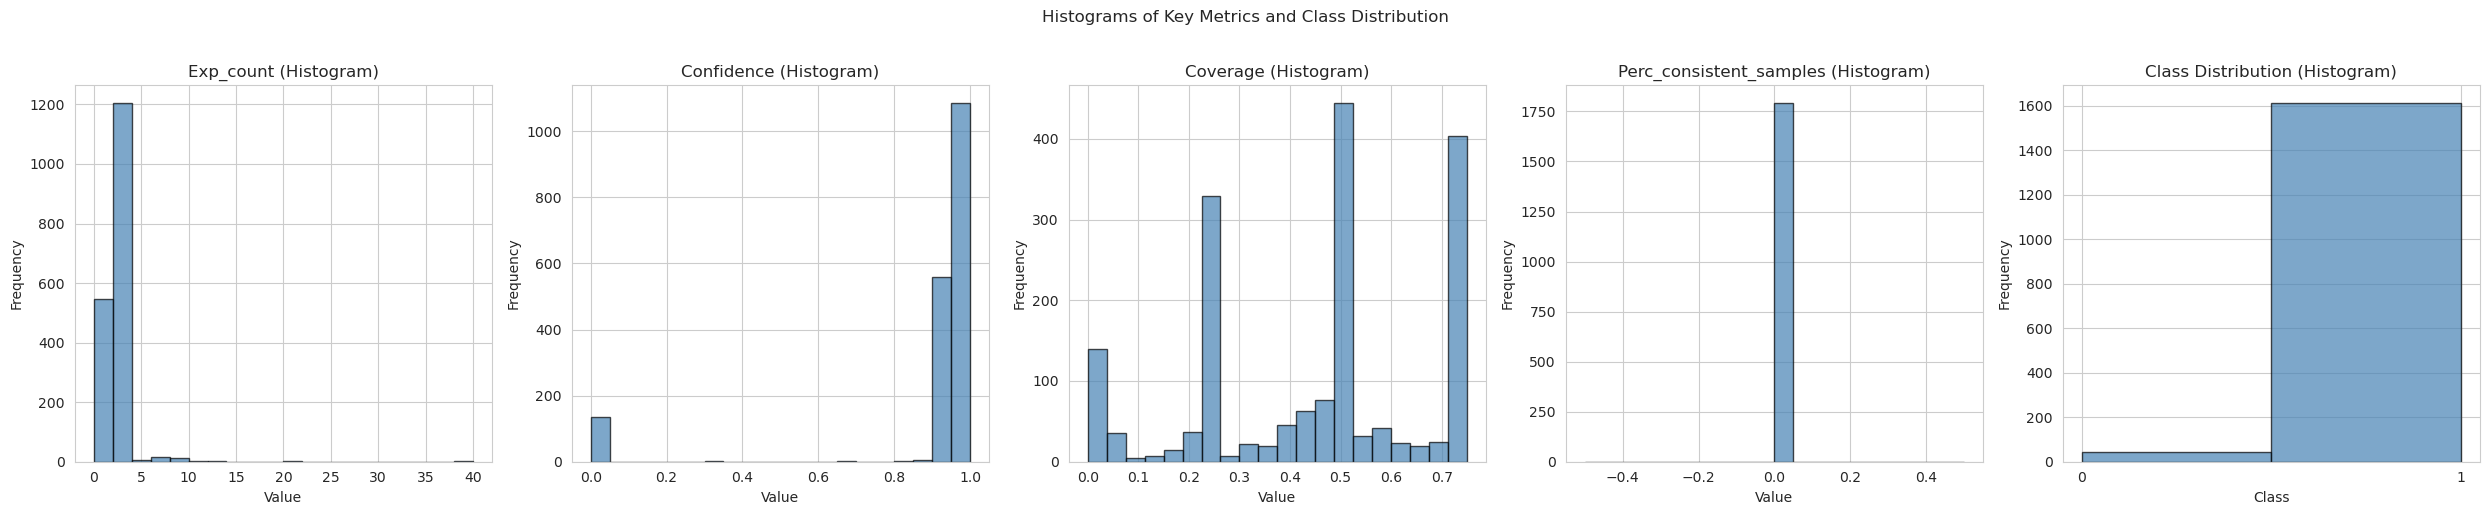

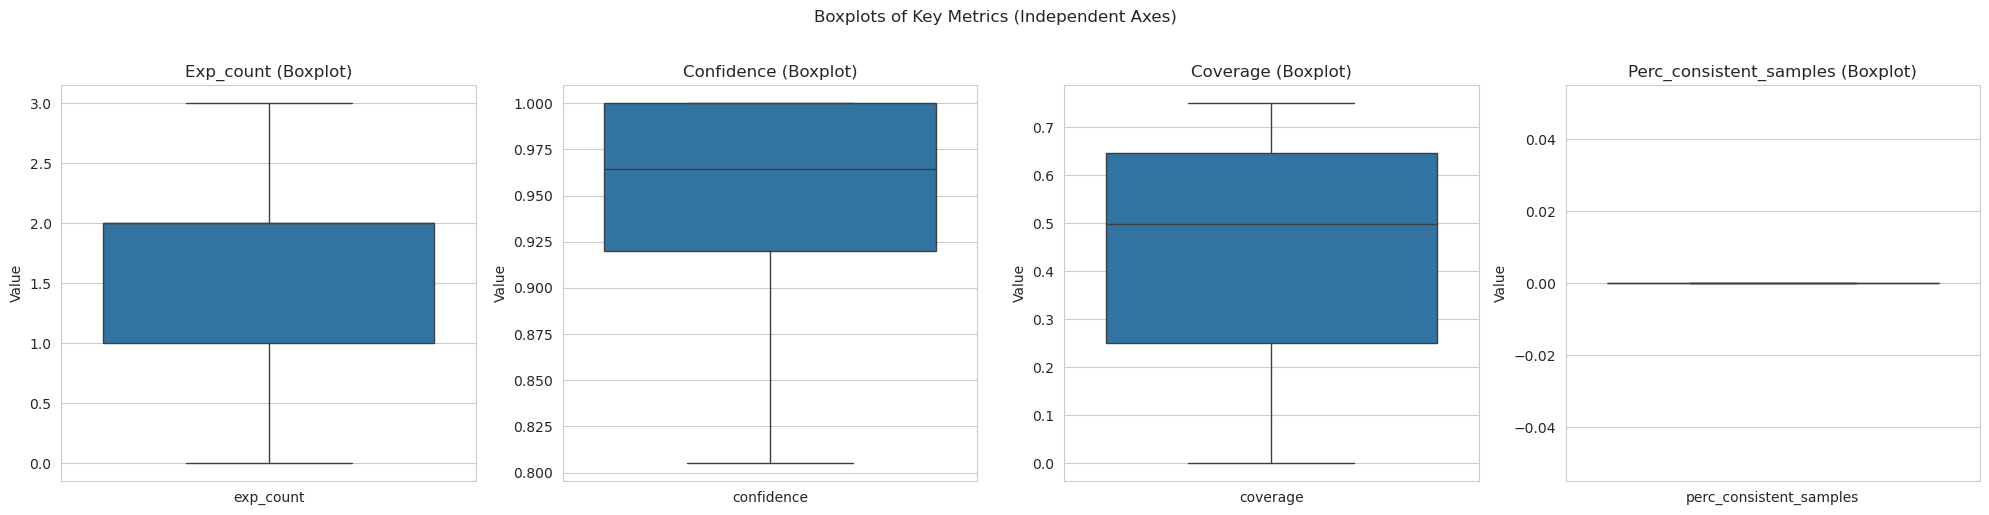

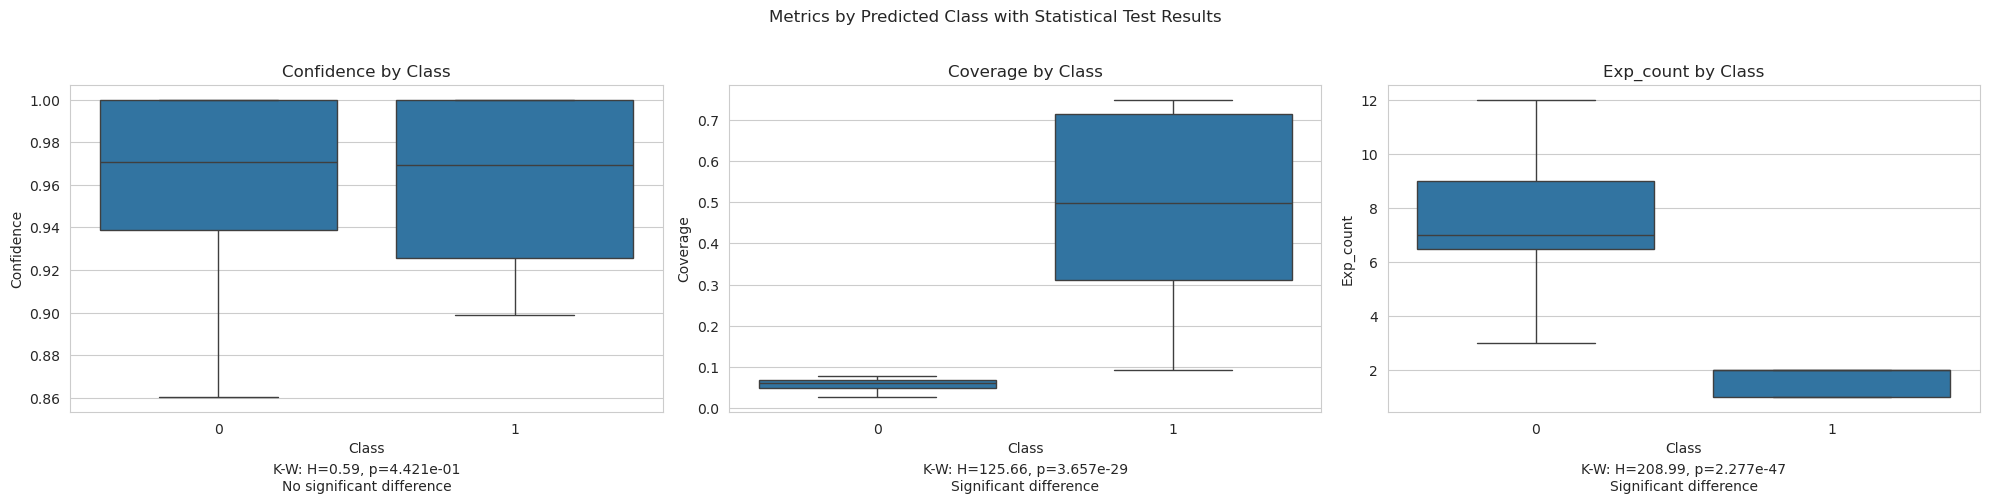

Note: Feature percentile visualization skipped due to lack of raw data.


In [335]:
analyze_rules(rules_uni_anchor)

In [55]:
rules_multi_anchor = lf_Libras['anchor_ts']
rules_multi_anchor[-3:]

[[{'index': 87,
   'success': True,
   'prediction': '3',
   'rule': {'feature_0': ['>0.38'],
    'feature_2': ['>0.37'],
    'feature_3': ['>-0.62'],
    'feature_4': ['>0.35'],
    'feature_9': ['>-0.61'],
    'feature_10': ['>0.25'],
    'feature_21': ['<=0.79'],
    'feature_32': ['>-0.79'],
    'feature_37': ['>-0.62'],
    'feature_41': ['>-0.52'],
    'feature_58': ['<=0.67'],
    'feature_68': ['<=0.77'],
    'feature_72': ['<=-0.27'],
    'feature_78': ['<=-0.32'],
    'feature_84': ['<=-0.24'],
    'feature_87': ['>-1.15'],
    'feature_88': ['<=-1.04']},
   'anchor_method': 'alibi',
   'anchor': ['feature_37 > -0.62',
    'feature_88 <= -1.04',
    'feature_10 > 0.25',
    'feature_72 <= -0.27',
    'feature_78 <= -0.32',
    'feature_2 > 0.37',
    'feature_41 > -0.52',
    'feature_84 <= -0.24',
    'feature_0 > 0.38',
    'feature_3 > -0.62',
    'feature_68 <= 0.77',
    'feature_32 > -0.79',
    'feature_87 > -1.15',
    'feature_58 <= 0.67',
    'feature_4 > 0.35',
   

=== Basic Info ===
Number of rules: 90
Threshold percentiles (unique): {None}
Use global importance (unique): {None}
Perturb sigma (p_sig) (unique): {None}
Perturbation samples count (unique): {None}
Methods (unique): {None}
=== Distributions of Key Metrics ===
exp_count: {'count': 90, 'min': 0, 'max': 24, 'mean': 5.7, 'median': 0.0, 'quartiles': [0.0, 0.0, 12.0]}
confidence: {'count': 90, 'min': 0.0, 'max': 1.0, 'mean': 0.40647255838345386, 'median': 0.0, 'quartiles': [0.0, 0.0, 0.9534997712567805]}
coverage: {'count': 90, 'min': 0.0, 'max': 0.1259259259259259, 'mean': 0.021011893004115226, 'median': 0.0, 'quartiles': [0.0, 0.0, 0.037037037037037035]}
perc_consistent_samples: {'count': 90, 'min': 0.0, 'max': 0.0, 'mean': 0.0, 'median': 0.0, 'quartiles': [0.0, 0.0, 0.0]}
=== Feature Frequency ===
Number of distinct features appearing in rules: 89
Top 10 most frequent features: [('feature_5', 21), ('feature_11', 19), ('feature_7', 18), ('feature_27', 16), ('feature_31', 15), ('feature_9

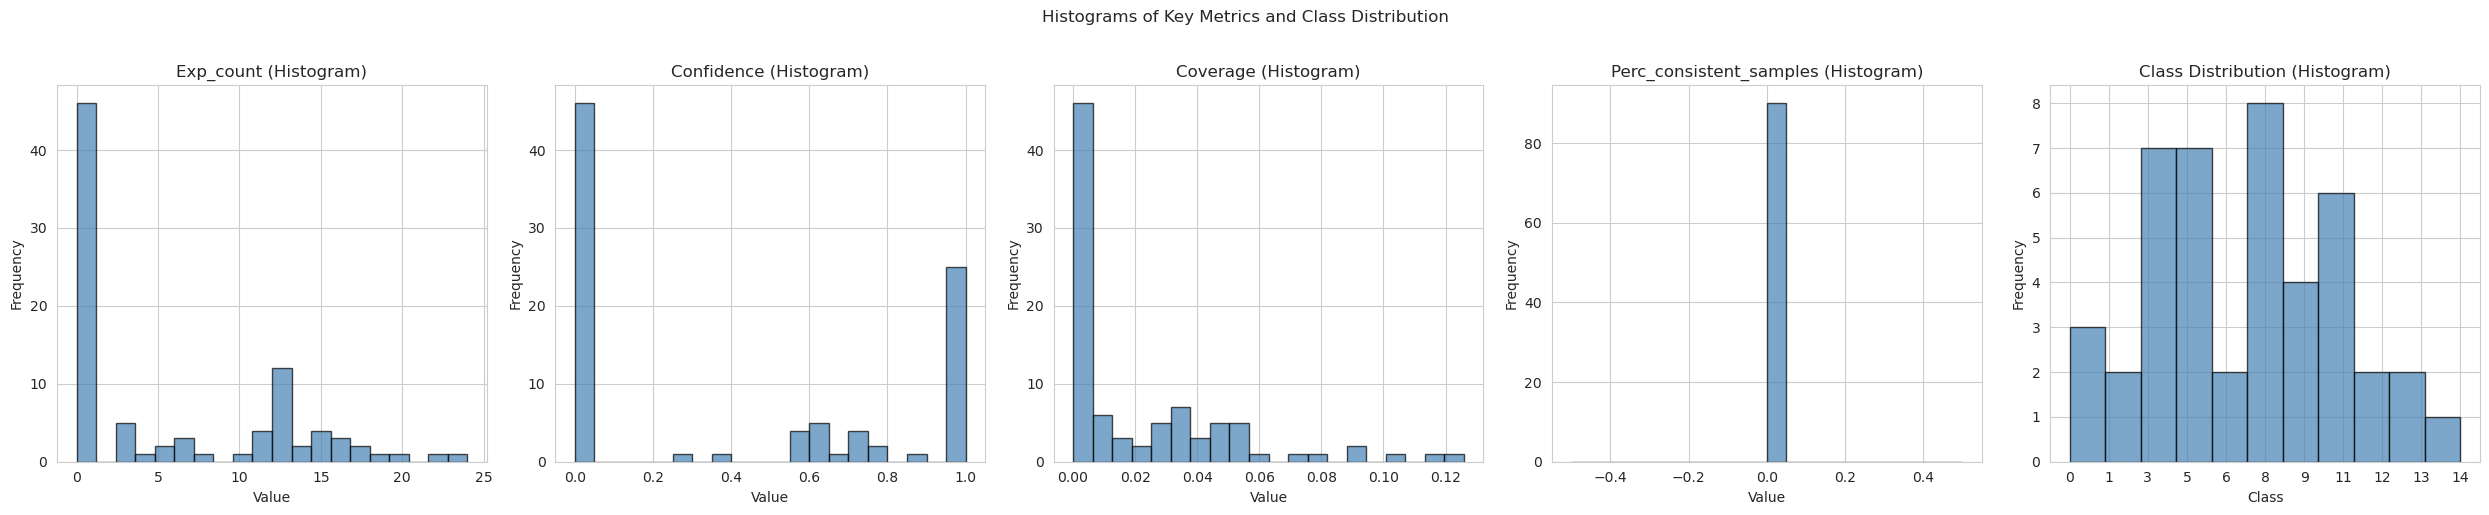

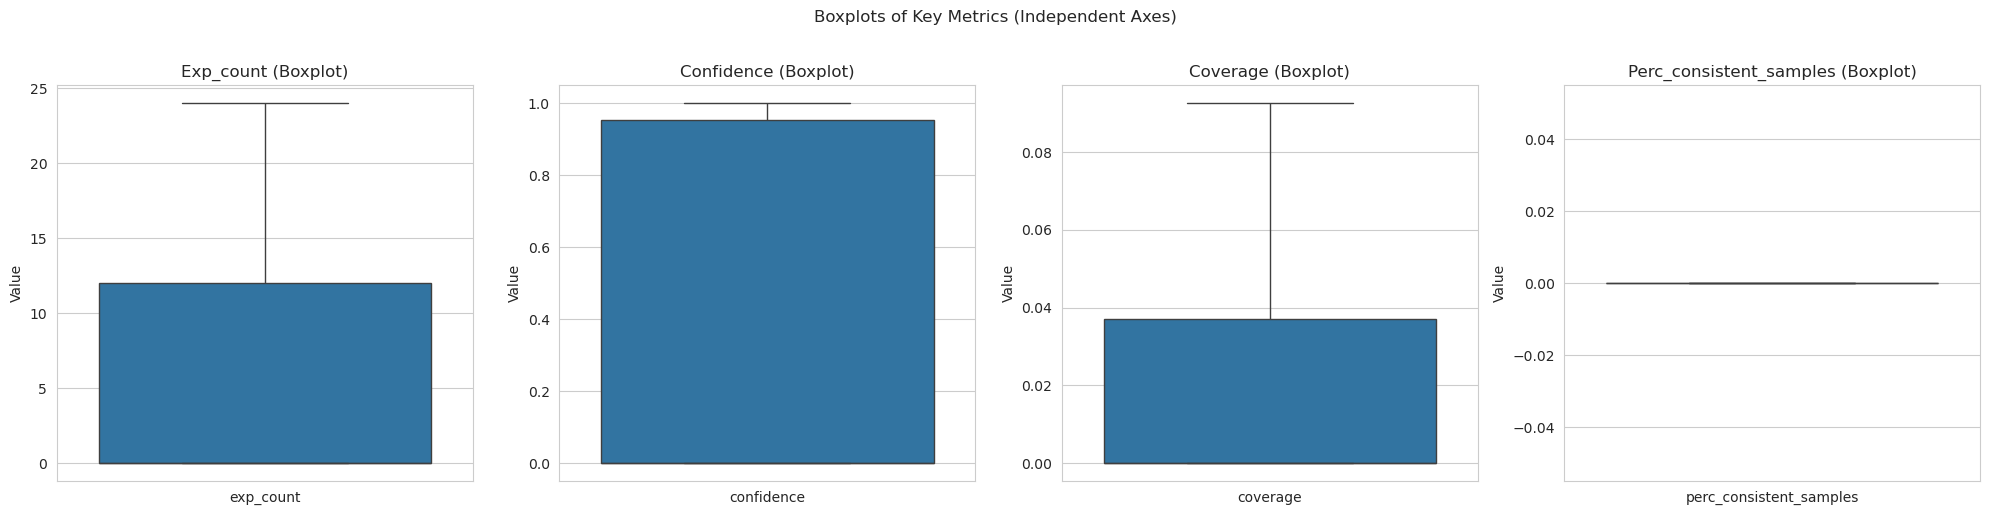

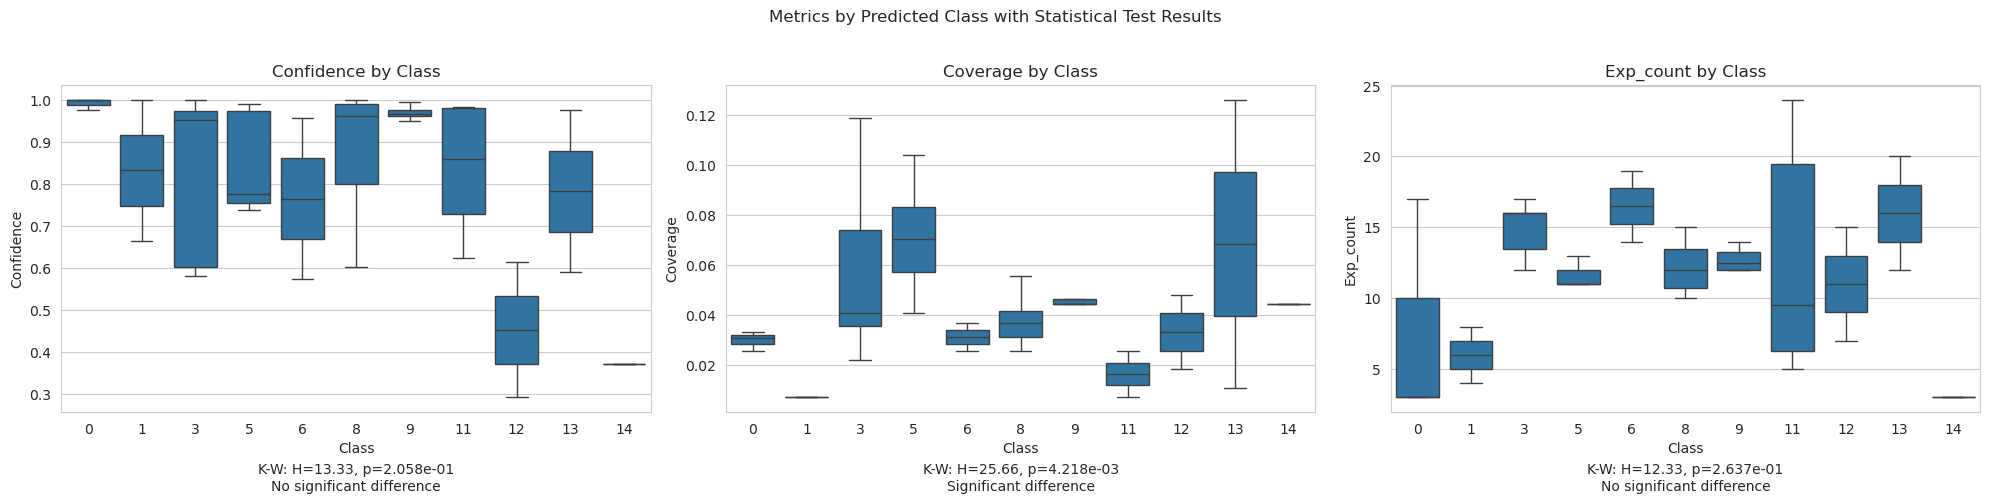

Note: Feature percentile visualization skipped due to lack of raw data.


In [338]:
analyze_rules(rules_multi_anchor)

#### LIME

=== Basic Info ===
Number of rules: 1791
Threshold percentiles (unique): {90.0}
Use global importance (unique): {True}
Perturb sigma (p_sig) (unique): {1.0}
Perturbation samples count (unique): {10000}
Methods (unique): {'RuleGenerator'}
=== Distributions of Key Metrics ===
exp_count: {'count': 1791, 'min': 1, 'max': 34, 'mean': 15.517029592406477, 'median': 15, 'quartiles': [11.0, 15.0, 20.0]}
confidence: {'count': 1791, 'min': 0.012145748987854251, 'max': 1.0, 'mean': 0.8820605794629756, 'median': 0.9331742243436754, 'quartiles': [0.9054852320675105, 0.9331742243436754, 0.9871244635193133]}
coverage: {'count': 1791, 'min': 0.0005583472920156337, 'max': 0.6677833612506979, 'mean': 0.325662371040013, 'median': 0.3322166387493021, 'quartiles': [0.09882747068676717, 0.3322166387493021, 0.6253489670575098]}
perc_consistent_samples: {'count': 1791, 'min': 0.5269, 'max': 1.0, 'mean': 0.9994088218872138, 'median': 1.0, 'quartiles': [1.0, 1.0, 1.0]}
=== Feature Frequency ===
Number of distinc

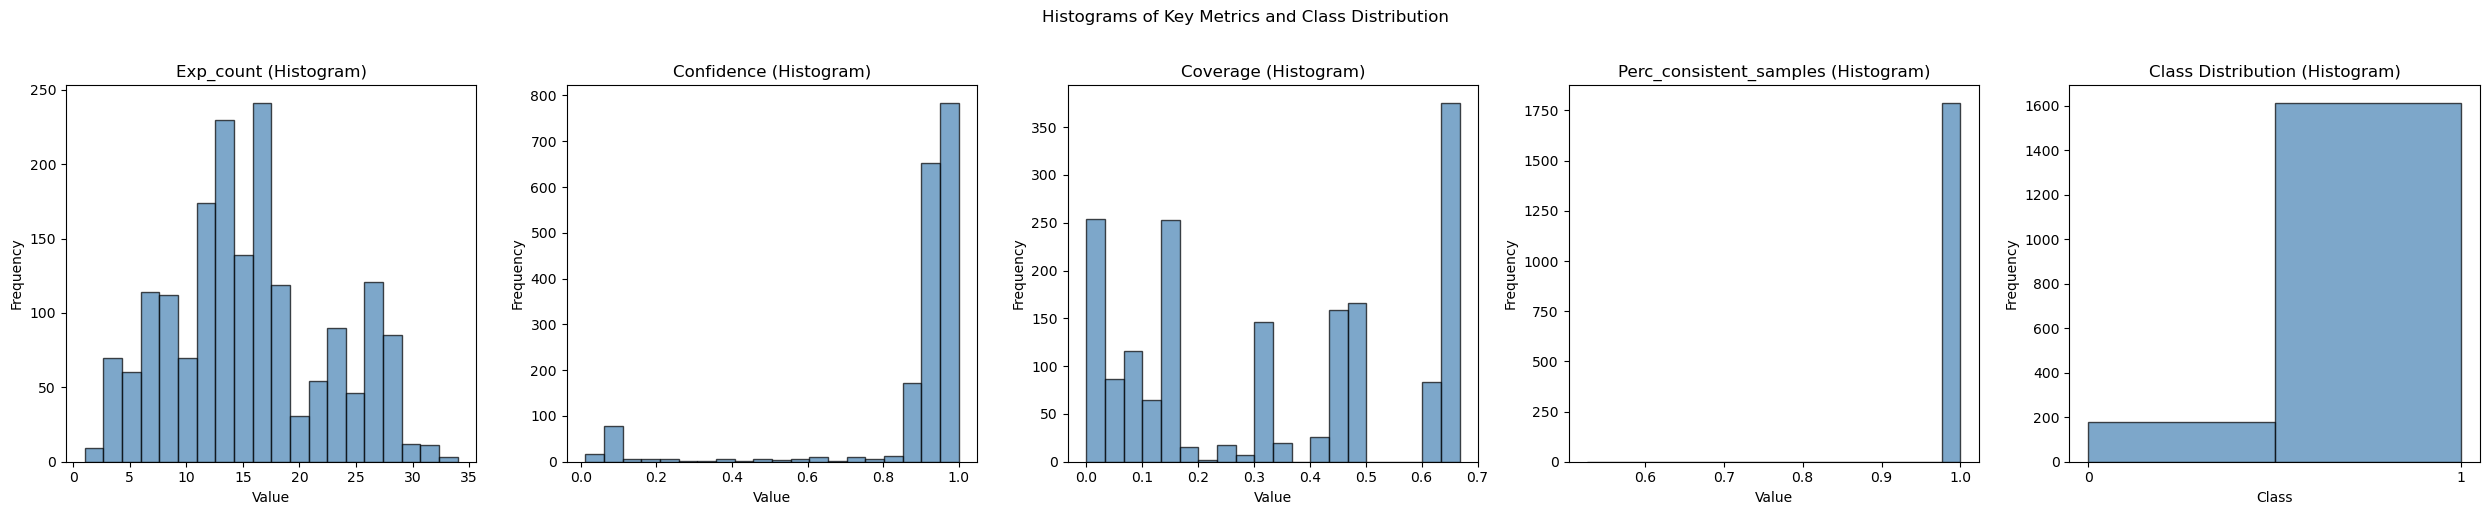

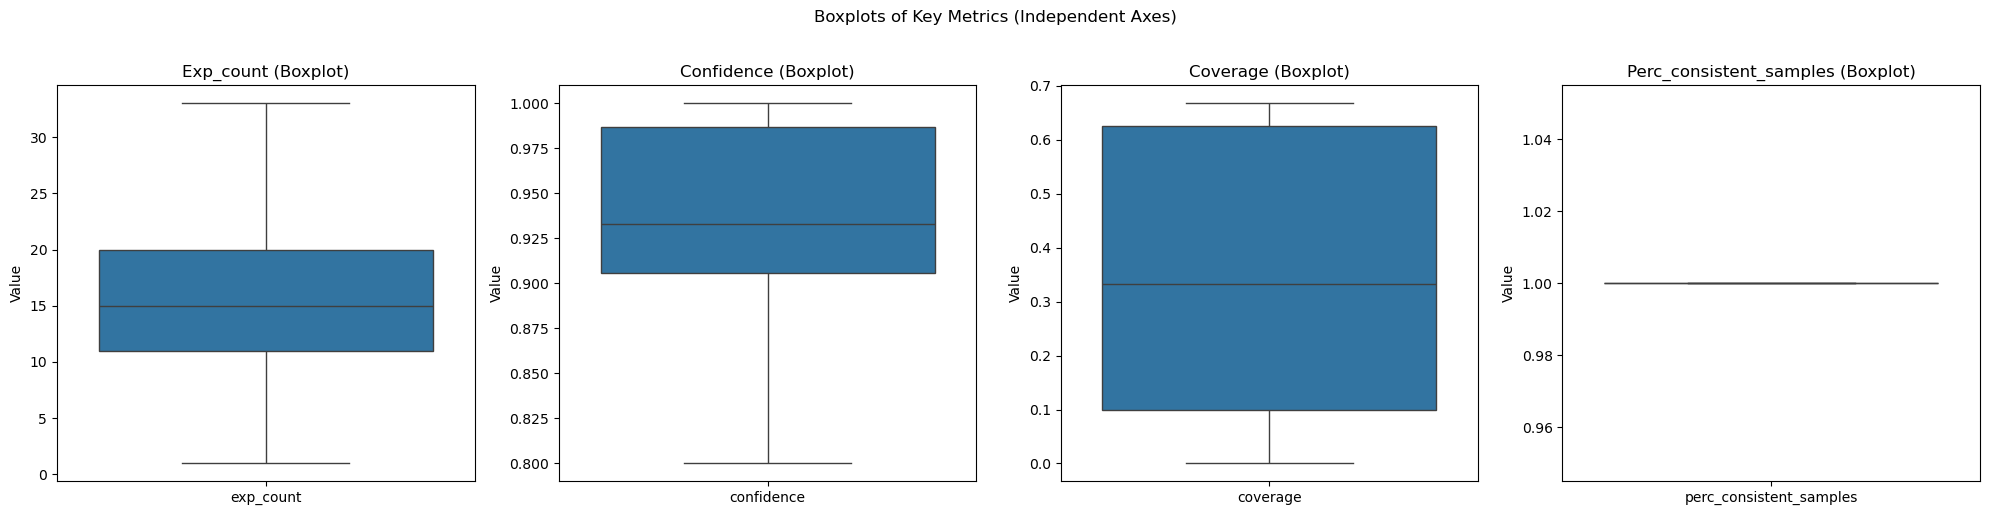

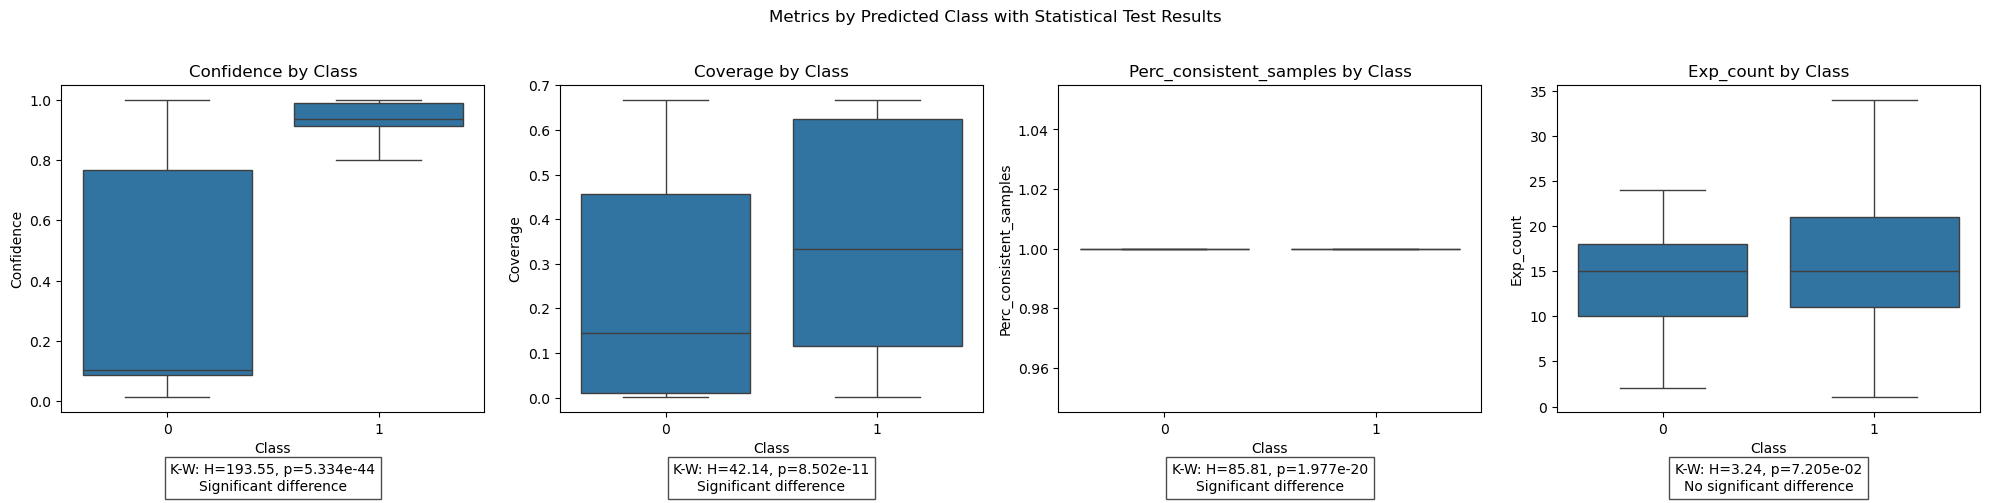

Note: Feature percentile visualization skipped due to lack of raw data.


In [211]:
analyze_rules(rules_uni_lime_global_true)

=== Basic Info ===
Number of rules: 1791
Threshold percentiles (unique): {60.0}
Use global importance (unique): {False}
Perturb sigma (p_sig) (unique): {1.0}
Perturbation samples count (unique): {10000}
Methods (unique): {'RuleGenerator'}
=== Distributions of Key Metrics ===
exp_count: {'count': 1791, 'min': 0, 'max': 152, 'mean': 64.07649357900614, 'median': 55, 'quartiles': [14.0, 55.0, 112.0]}
confidence: {'count': 1791, 'min': 0.0, 'max': 1.0, 'mean': 0.9058972598355604, 'median': 1.0, 'quartiles': [0.946078431372549, 1.0, 1.0]}
coverage: {'count': 1791, 'min': 0.0, 'max': 0.7202680067001676, 'mean': 0.11569354932738012, 'median': 0.011166945840312675, 'quartiles': [0.0016750418760469012, 0.011166945840312675, 0.13847012841987716]}
perc_consistent_samples: {'count': 1791, 'min': 0.0, 'max': 1.0, 'mean': 0.9501913456169737, 'median': 1.0, 'quartiles': [1.0, 1.0, 1.0]}
=== Feature Frequency ===
Number of distinct features appearing in rules: 152
Top 10 most frequent features: [('feat

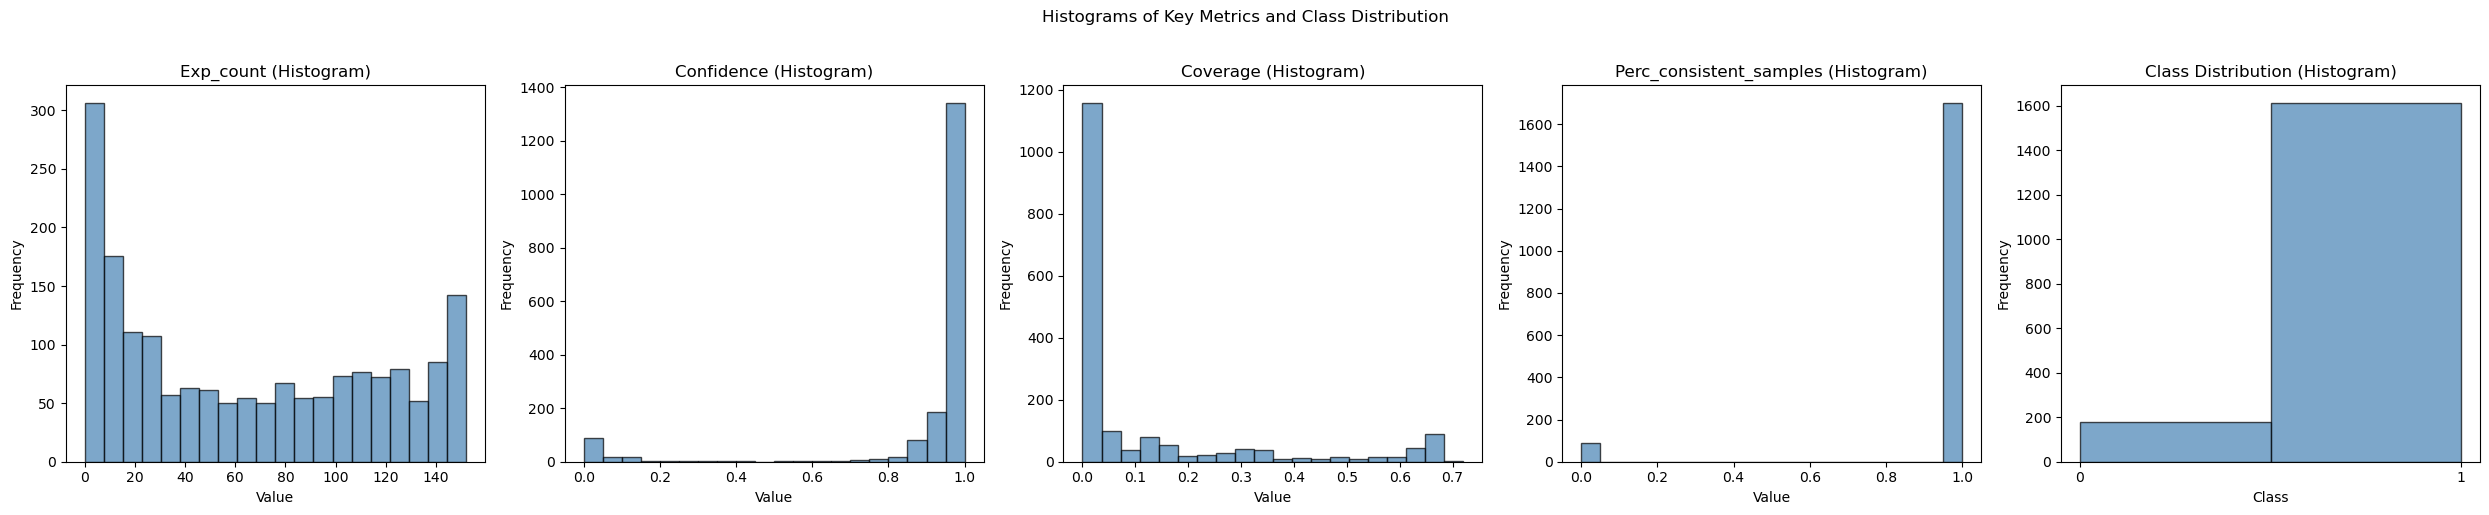

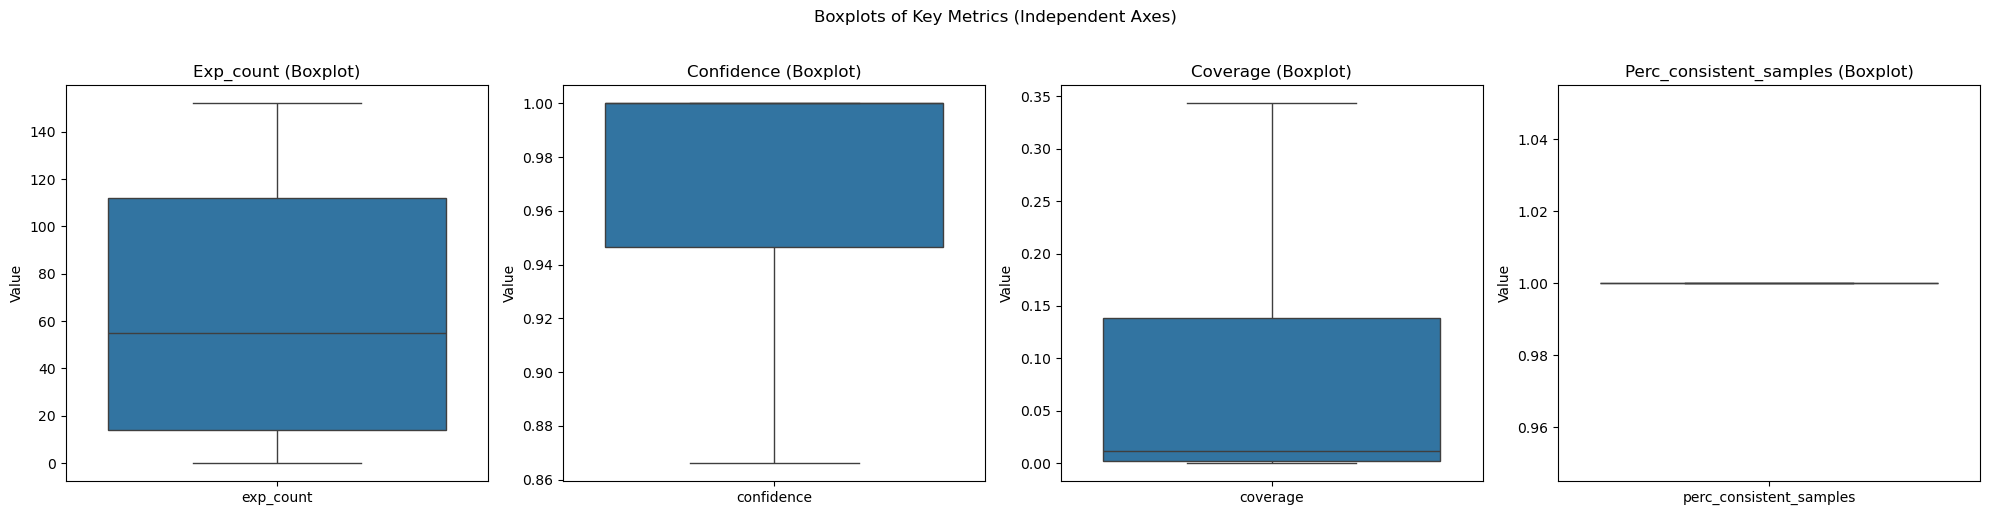

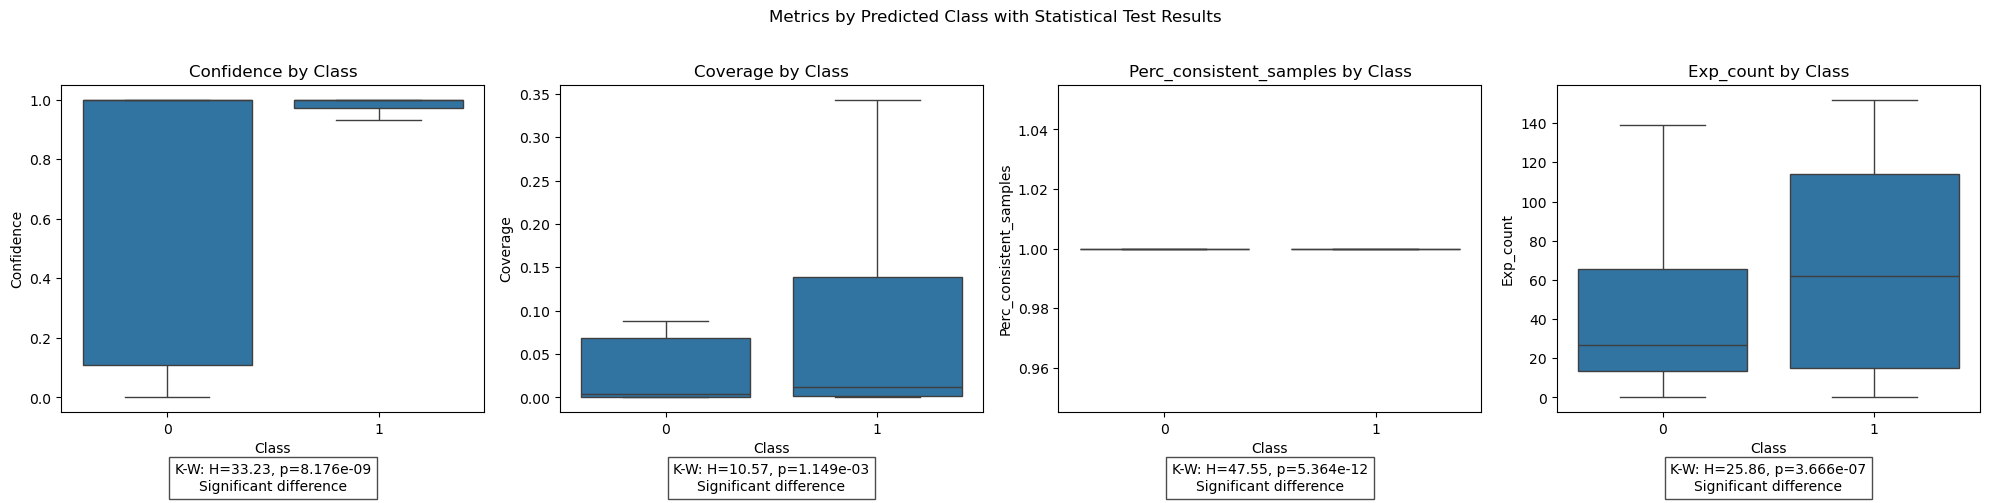

Note: Feature percentile visualization skipped due to lack of raw data.


In [212]:
analyze_rules(rules_uni_lime_global_false)

In [339]:
rules_multi_lime_global_true[-3:]

[[{'index': 87,
   'success': True,
   'prediction': '3',
   'rule': {'time_0_var_0': ['>0.41707540094069173', '<=0.6275705264758002'],
    'time_0_var_1': ['>0.6396699450865333', '<=0.8665655597840602'],
    'time_1_var_0': ['>0.41757714404656554', '<=0.6269412618511889'],
    'time_1_var_1': ['>0.6263136914027976', '<=0.8524974877690814'],
    'time_2_var_0': ['>0.4177849915314581', '<=0.626680877766867'],
    'time_2_var_1': ['>0.6259162463087751', '<=0.8525197719016858'],
    'time_3_var_0': ['>0.4187545126632295', '<=0.6257100124568167'],
    'time_3_var_1': ['>0.6121306744843192', '<=0.8379156273205461'],
    'time_4_var_0': ['>0.43059116438581463', '<=0.6339917688751279']},
   'abs_explanations_percentiles': {'time_0_var_0': 94.19753086419755,
    'time_0_var_1': 93.25102880658437,
    'time_1_var_0': 93.09465020576133,
    'time_1_var_1': 90.65432098765433,
    'time_2_var_0': 90.45267489711935,
    'time_2_var_1': 90.45267489711935,
    'time_3_var_0': 90.41563786008231,
    '

=== Basic Info ===
Number of rules: 90
Threshold percentiles (unique): {90.0}
Use global importance (unique): {True}
Perturb sigma (p_sig) (unique): {0.1}
Perturbation samples count (unique): {10000}
Methods (unique): {'RuleGenerator'}
=== Distributions of Key Metrics ===
exp_count: {'count': 90, 'min': 0, 'max': 21, 'mean': 9.3, 'median': 9.5, 'quartiles': [6.0, 9.5, 13.0]}
confidence: {'count': 90, 'min': 0.0, 'max': 1.0, 'mean': 0.8860185185185185, 'median': 1.0, 'quartiles': [1.0, 1.0, 1.0]}
coverage: {'count': 90, 'min': 0.0, 'max': 0.1111111111111111, 'mean': 0.015185185185185185, 'median': 0.011111111111111112, 'quartiles': [0.011111111111111112, 0.011111111111111112, 0.011111111111111112]}
perc_consistent_samples: {'count': 90, 'min': 0.0, 'max': 1.0, 'mean': 0.9321311111111111, 'median': 1.0, 'quartiles': [1.0, 1.0, 1.0]}
=== Feature Frequency ===
Number of distinct features appearing in rules: 21
Top 10 most frequent features: [('time_0_var_0', 85), ('time_0_var_1', 82), ('ti

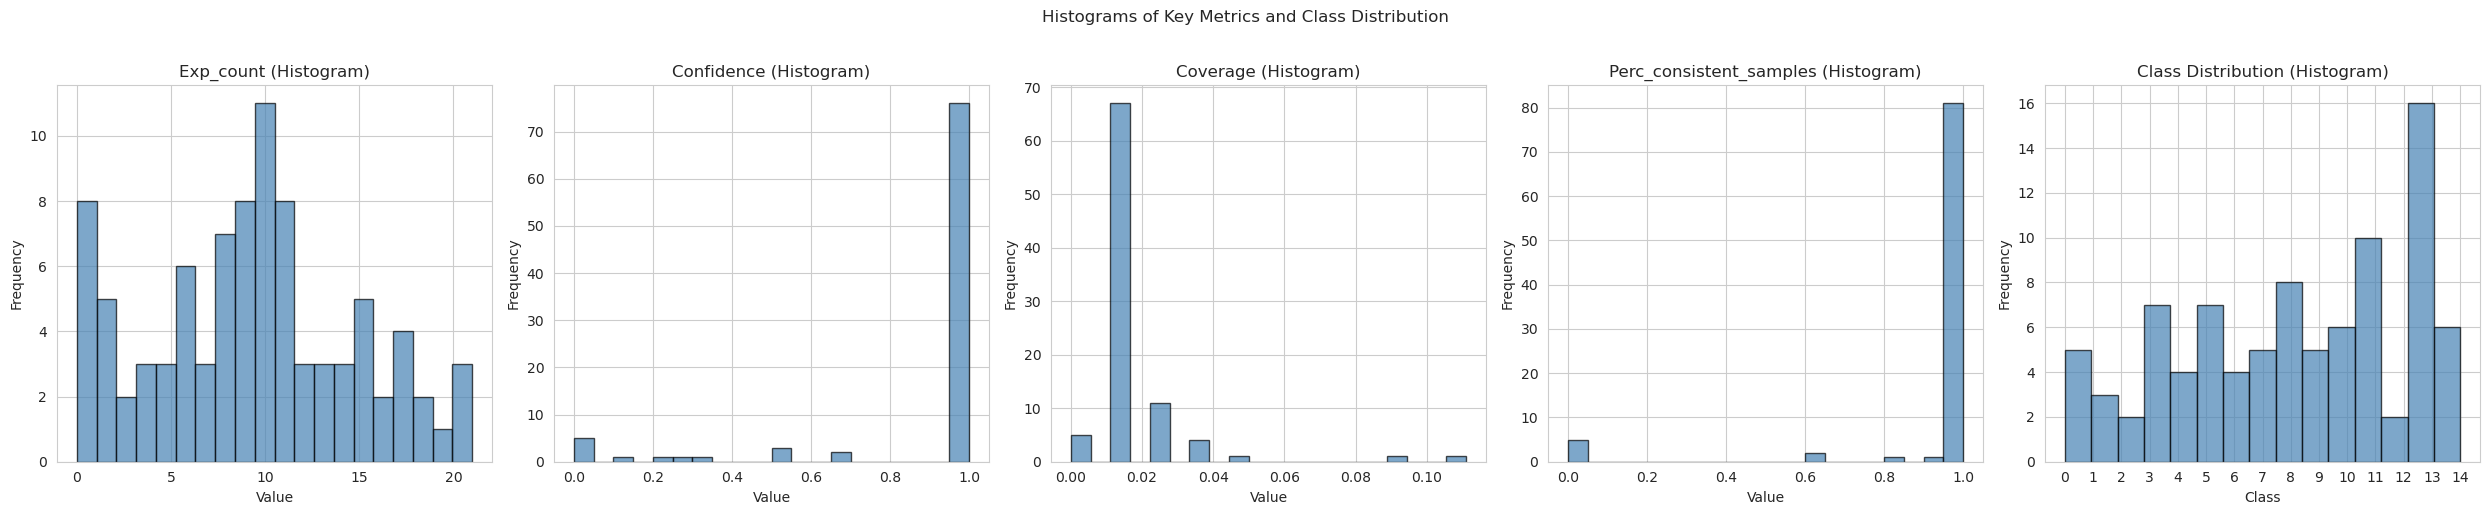

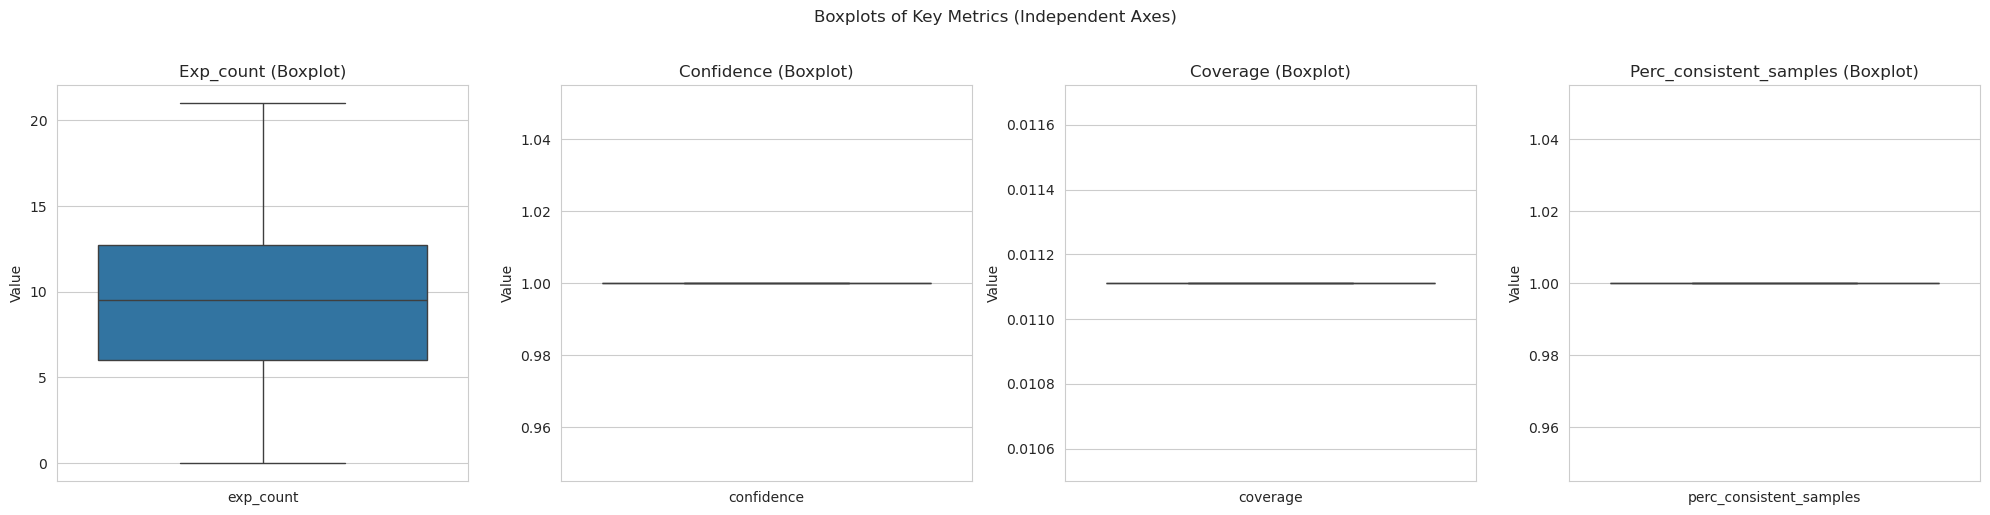

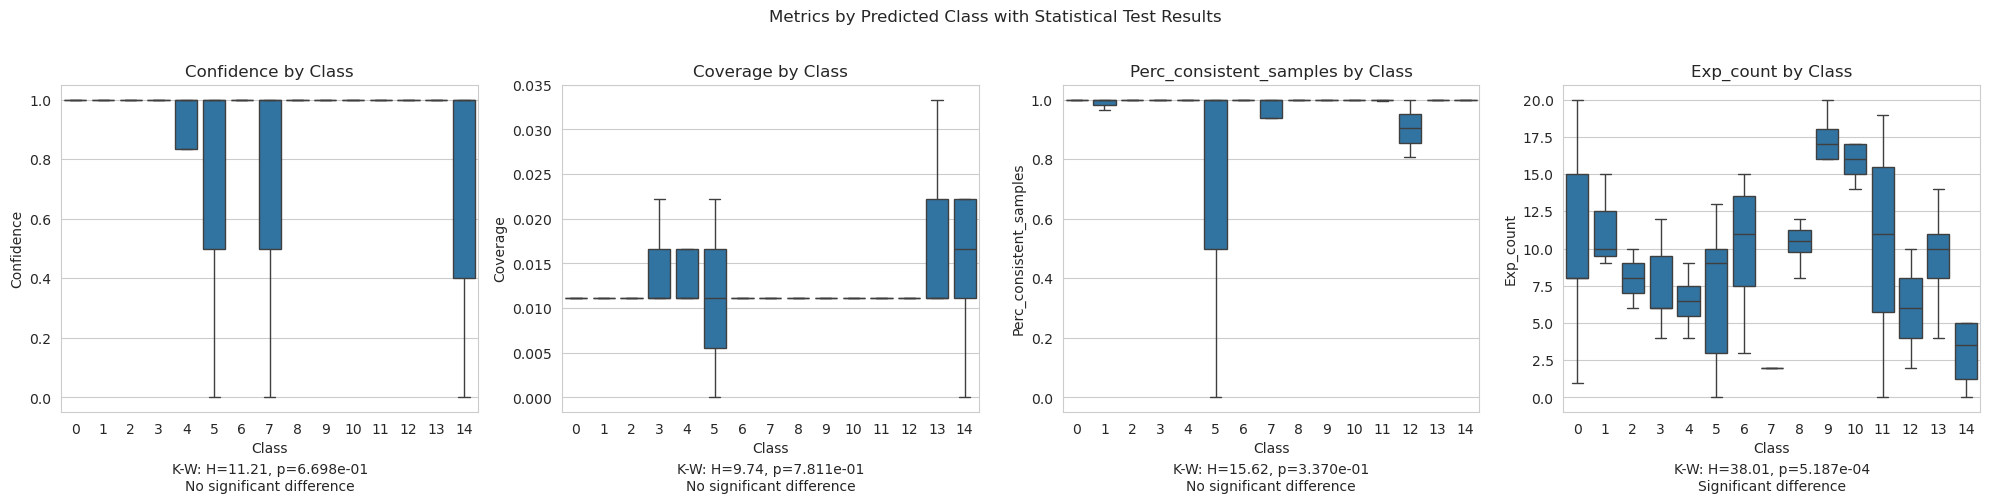

Note: Feature percentile visualization skipped due to lack of raw data.


In [340]:
analyze_rules(rules_multi_lime_global_true)

=== Basic Info ===
Number of rules: 90
Threshold percentiles (unique): {60.0}
Use global importance (unique): {False}
Perturb sigma (p_sig) (unique): {0.1}
Perturbation samples count (unique): {10000}
Methods (unique): {'RuleGenerator'}
=== Distributions of Key Metrics ===
exp_count: {'count': 90, 'min': 0, 'max': 90, 'mean': 42.522222222222226, 'median': 47.0, 'quartiles': [9.0, 47.0, 72.25]}
confidence: {'count': 90, 'min': 0.0, 'max': 1.0, 'mean': 0.8808641975308642, 'median': 1.0, 'quartiles': [1.0, 1.0, 1.0]}
coverage: {'count': 90, 'min': 0.0, 'max': 0.1, 'mean': 0.011604938271604939, 'median': 0.011111111111111112, 'quartiles': [0.011111111111111112, 0.011111111111111112, 0.011111111111111112]}
perc_consistent_samples: {'count': 90, 'min': 0.0, 'max': 1.0, 'mean': 0.8842844444444444, 'median': 1.0, 'quartiles': [1.0, 1.0, 1.0]}
=== Feature Frequency ===
Number of distinct features appearing in rules: 90
Top 10 most frequent features: [('time_30_var_0', 49), ('time_31_var_0', 49)

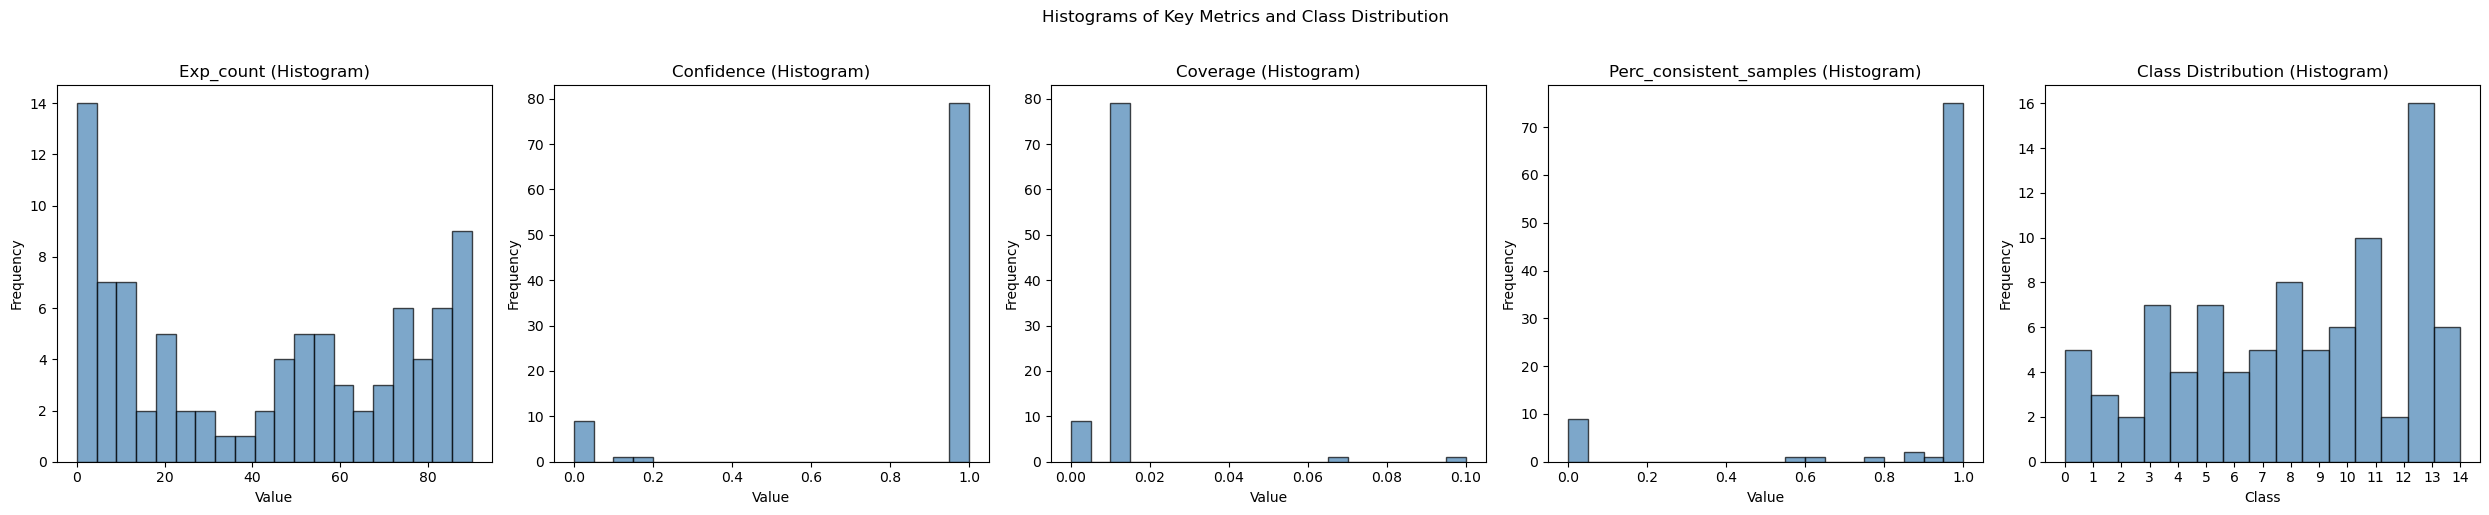

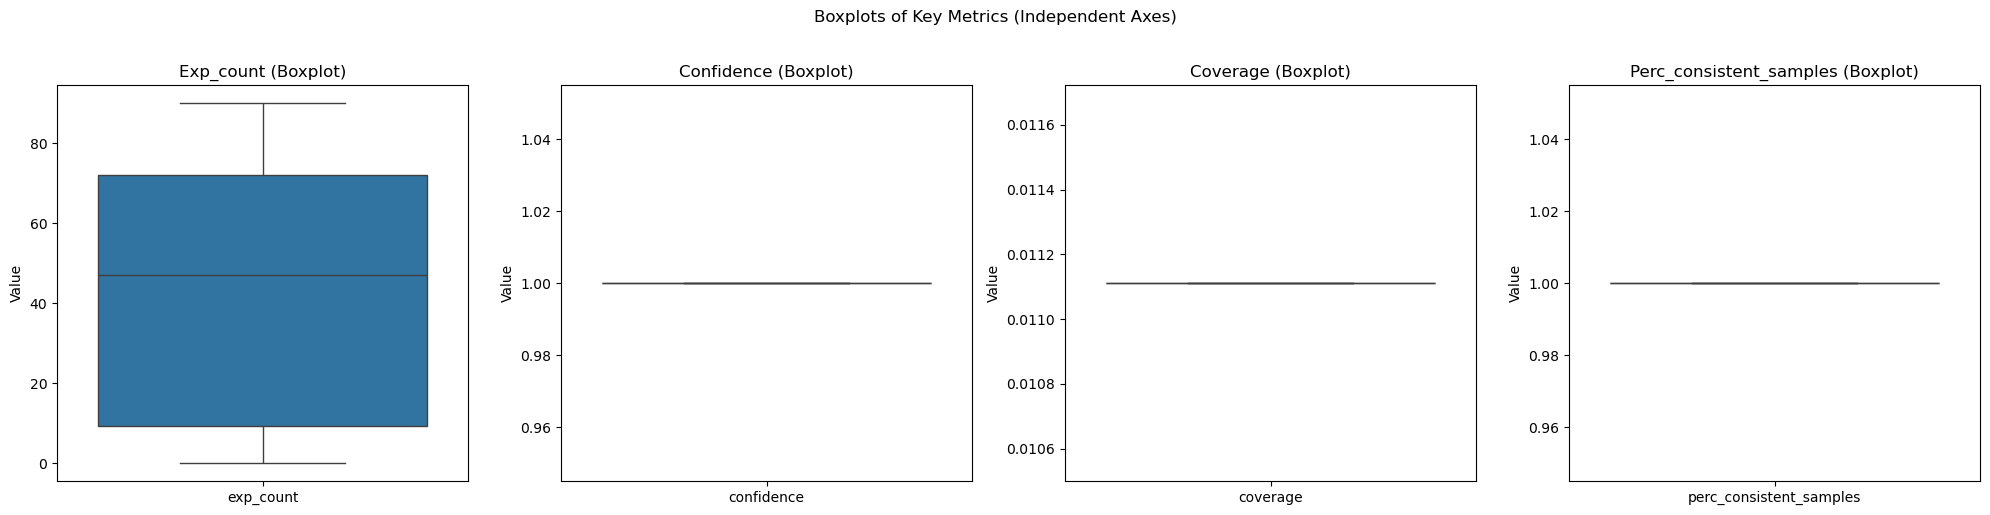

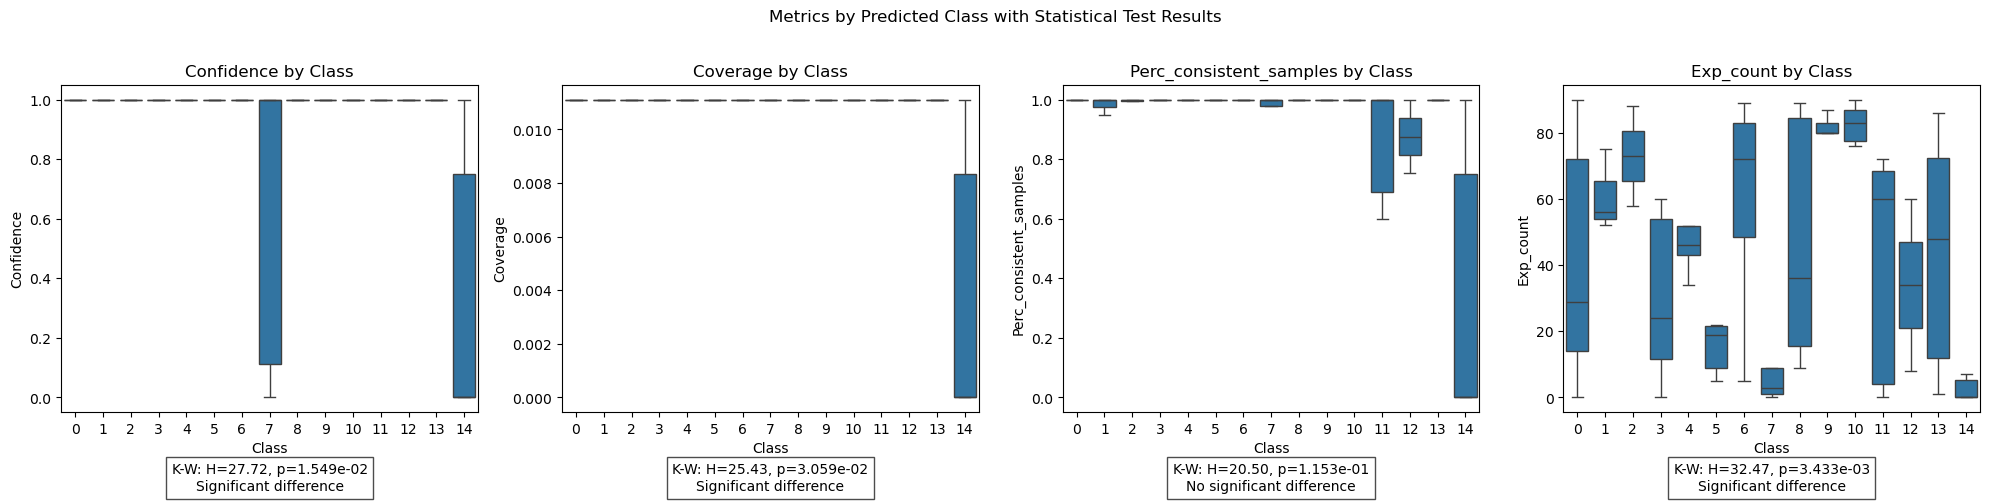

Note: Feature percentile visualization skipped due to lack of raw data.


In [214]:
analyze_rules(rules_multi_lime_global_false)

#### SHAP

=== Basic Info ===
Number of rules: 1791
Threshold percentiles (unique): {90.0}
Use global importance (unique): {True}
Perturb sigma (p_sig) (unique): {1.0}
Perturbation samples count (unique): {10000}
Methods (unique): {'RuleGenerator'}
=== Distributions of Key Metrics ===
exp_count: {'count': 1791, 'min': 1, 'max': 85, 'mean': 14.579006141820212, 'median': 9, 'quartiles': [6.0, 9.0, 11.0]}
confidence: {'count': 1791, 'min': 0.28888888888888886, 'max': 1.0, 'mean': 0.9515276896421371, 'median': 0.9583333333333334, 'quartiles': [0.9390519187358917, 0.9583333333333334, 1.0]}
coverage: {'count': 1791, 'min': 0.0005583472920156337, 'max': 0.5549972082635399, 'mean': 0.28476335396194324, 'median': 0.29034059184812955, 'quartiles': [0.20268006700167504, 0.29034059184812955, 0.47738693467336685]}
perc_consistent_samples: {'count': 1791, 'min': 0.5258, 'max': 1.0, 'mean': 0.9978203796761586, 'median': 1.0, 'quartiles': [1.0, 1.0, 1.0]}
=== Feature Frequency ===
Number of distinct features app

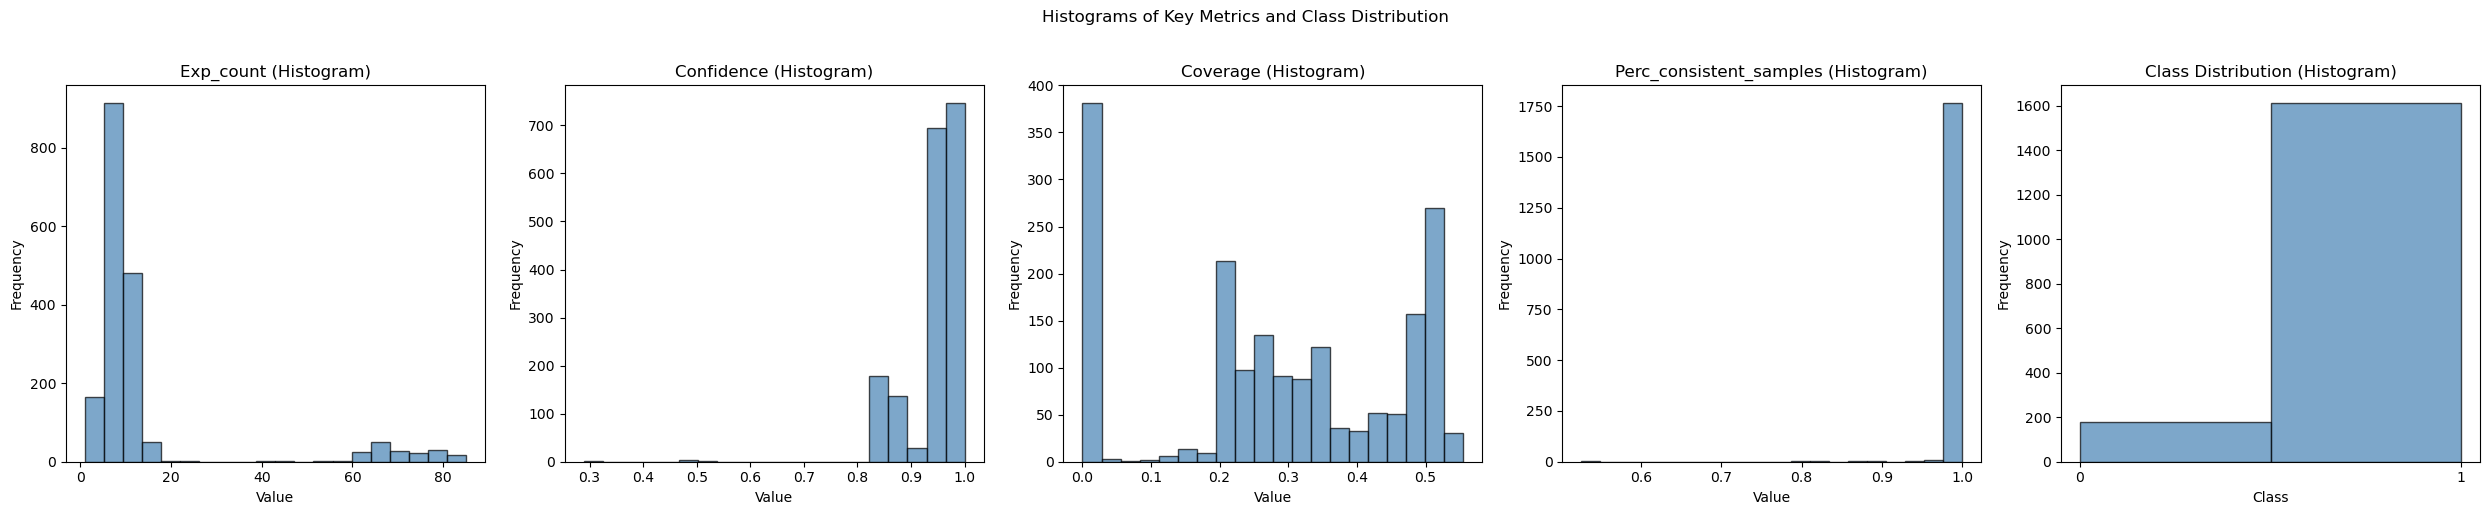

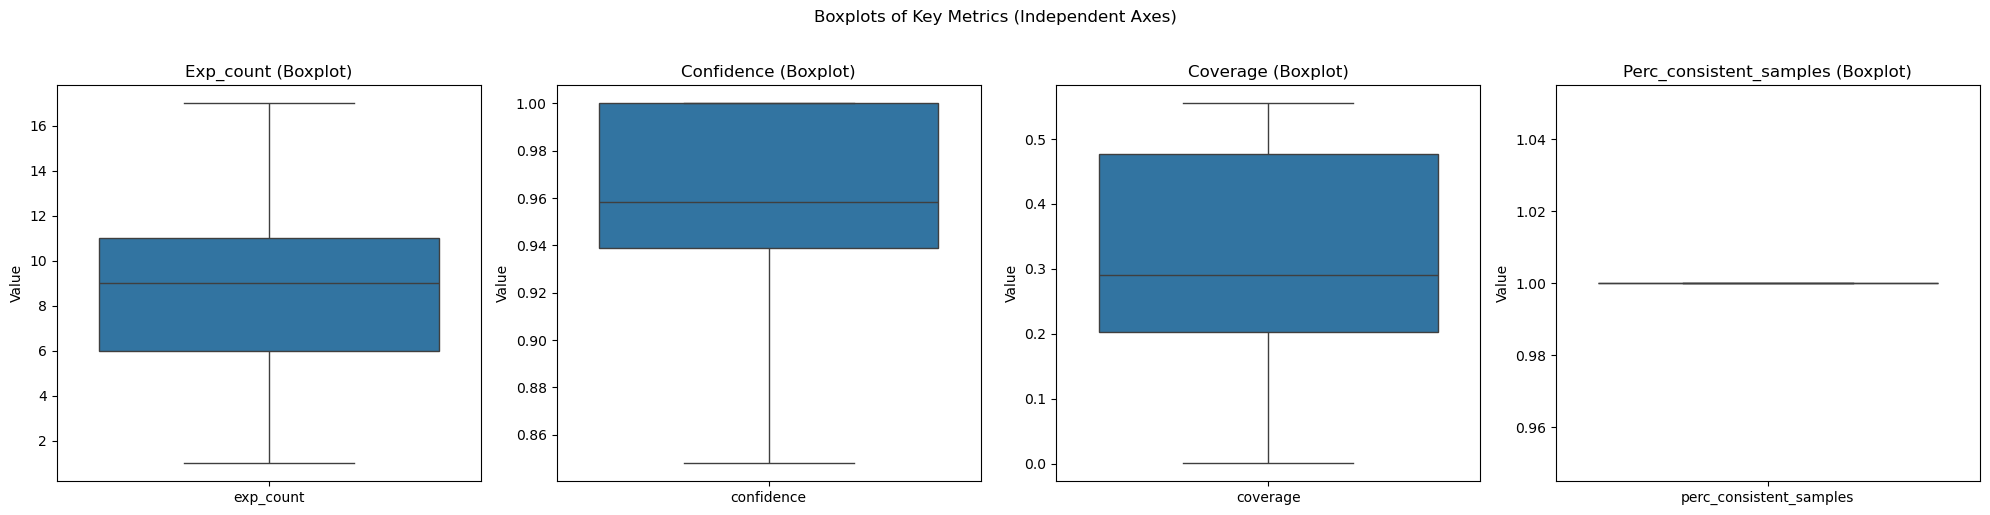

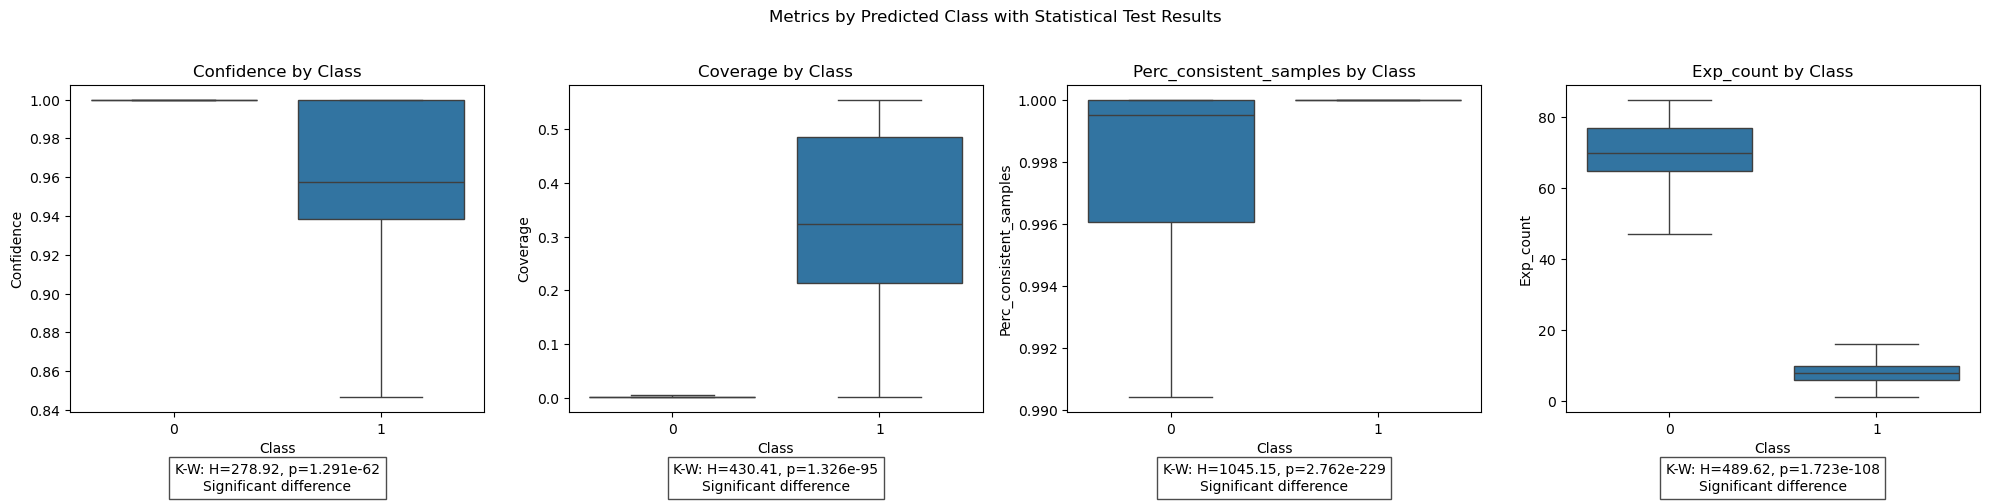

Note: Feature percentile visualization skipped due to lack of raw data.


In [219]:
analyze_rules(rules_uni_shap_global_true)

=== Basic Info ===
Number of rules: 90
Threshold percentiles (unique): {90.0}
Use global importance (unique): {True}
Perturb sigma (p_sig) (unique): {0.1}
Perturbation samples count (unique): {10000}
Methods (unique): {'RuleGenerator'}
=== Distributions of Key Metrics ===
exp_count: {'count': 90, 'min': 0, 'max': 89, 'mean': 8.933333333333334, 'median': 0.5, 'quartiles': [0.0, 0.5, 12.0]}
confidence: {'count': 90, 'min': 0.0, 'max': 1.0, 'mean': 0.45555315055315054, 'median': 0.125, 'quartiles': [0.0, 0.125, 1.0]}
coverage: {'count': 90, 'min': 0.0, 'max': 0.12222222222222222, 'mean': 0.009753086419753086, 'median': 0.005555555555555556, 'quartiles': [0.0, 0.005555555555555556, 0.011111111111111112]}
perc_consistent_samples: {'count': 90, 'min': 0.0, 'max': 1.0, 'mean': 0.48696666666666666, 'median': 0.2737, 'quartiles': [0.0, 0.2737, 1.0]}
=== Feature Frequency ===
Number of distinct features appearing in rules: 90
Top 10 most frequent features: [('time_3_var_1', 34), ('time_2_var_1',

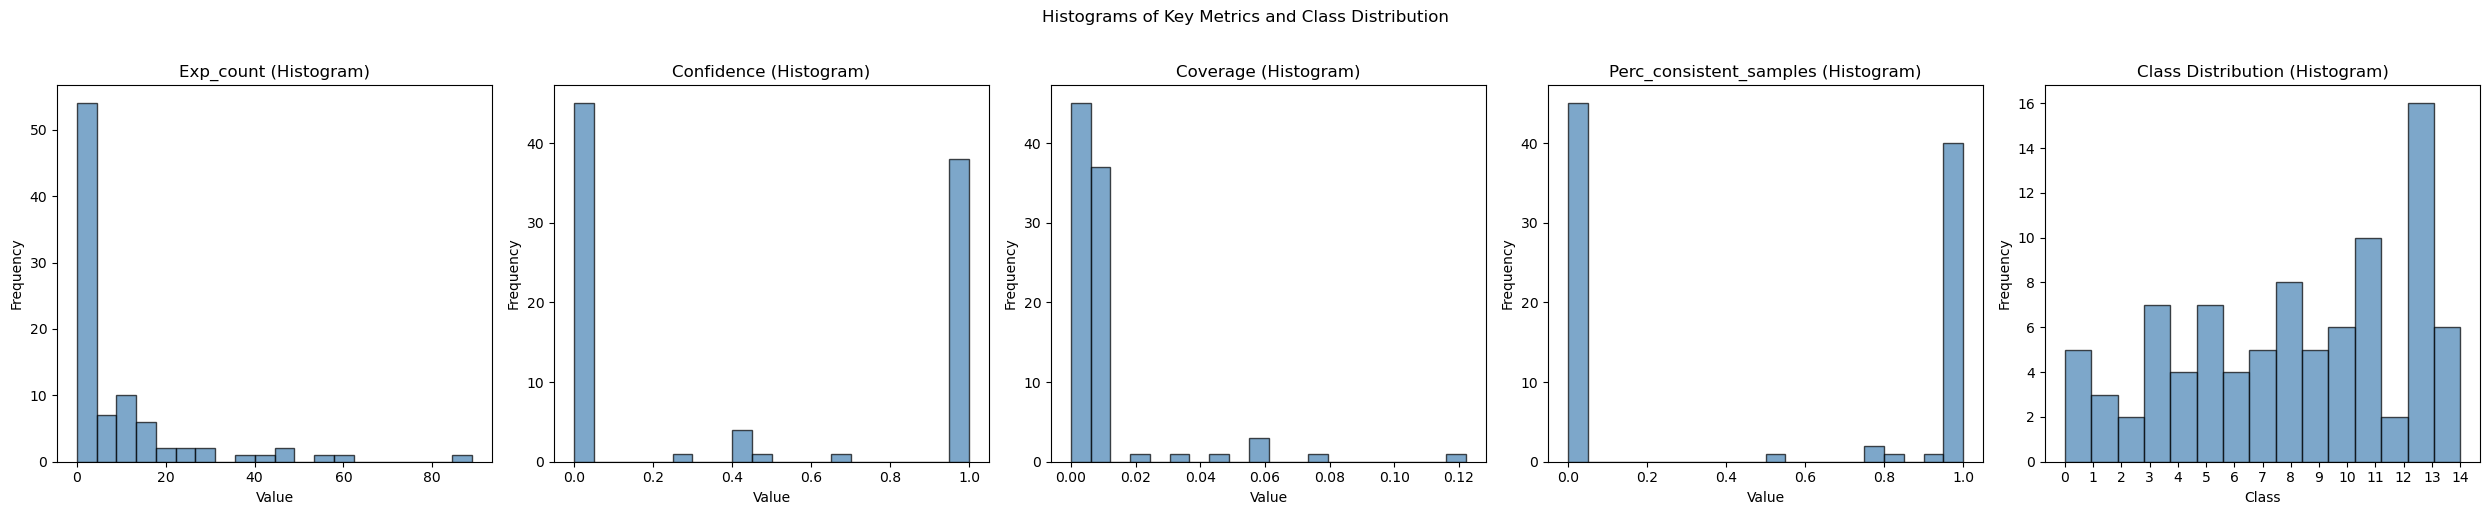

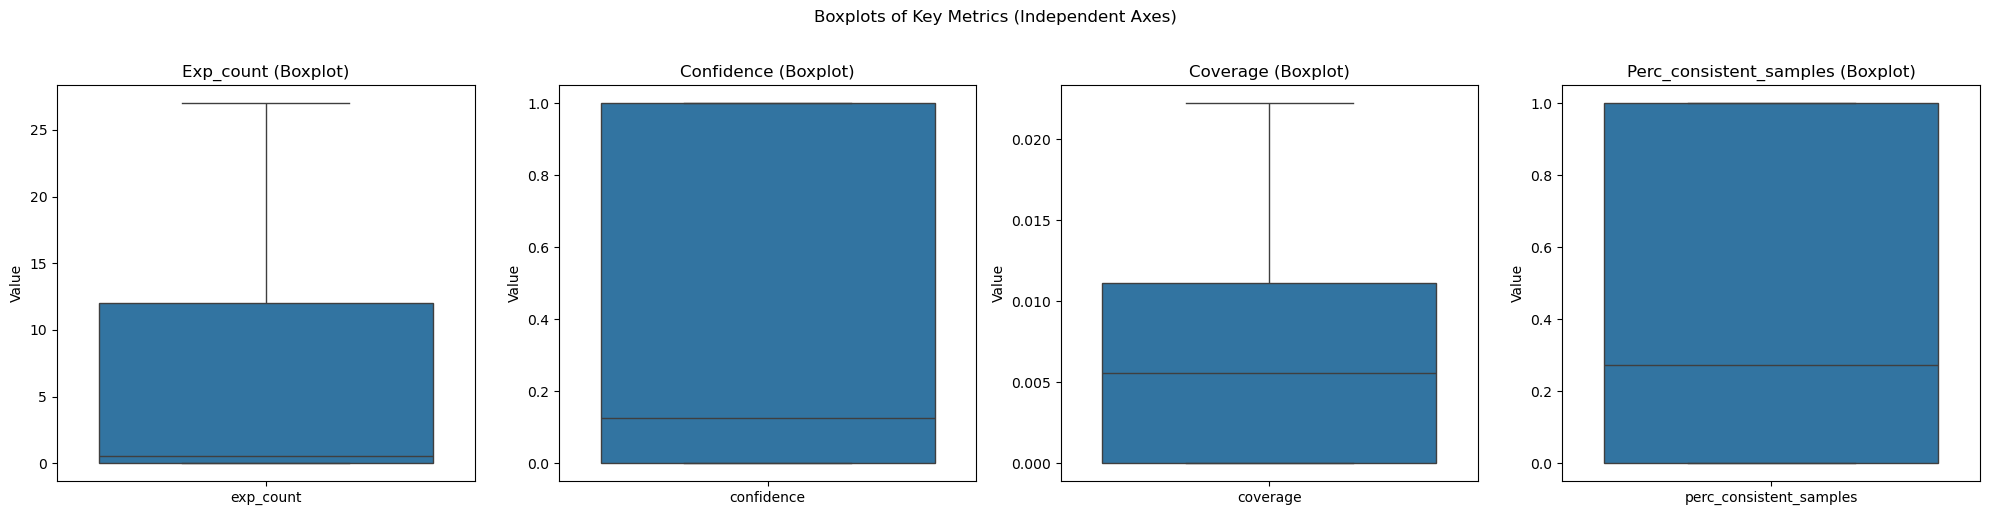

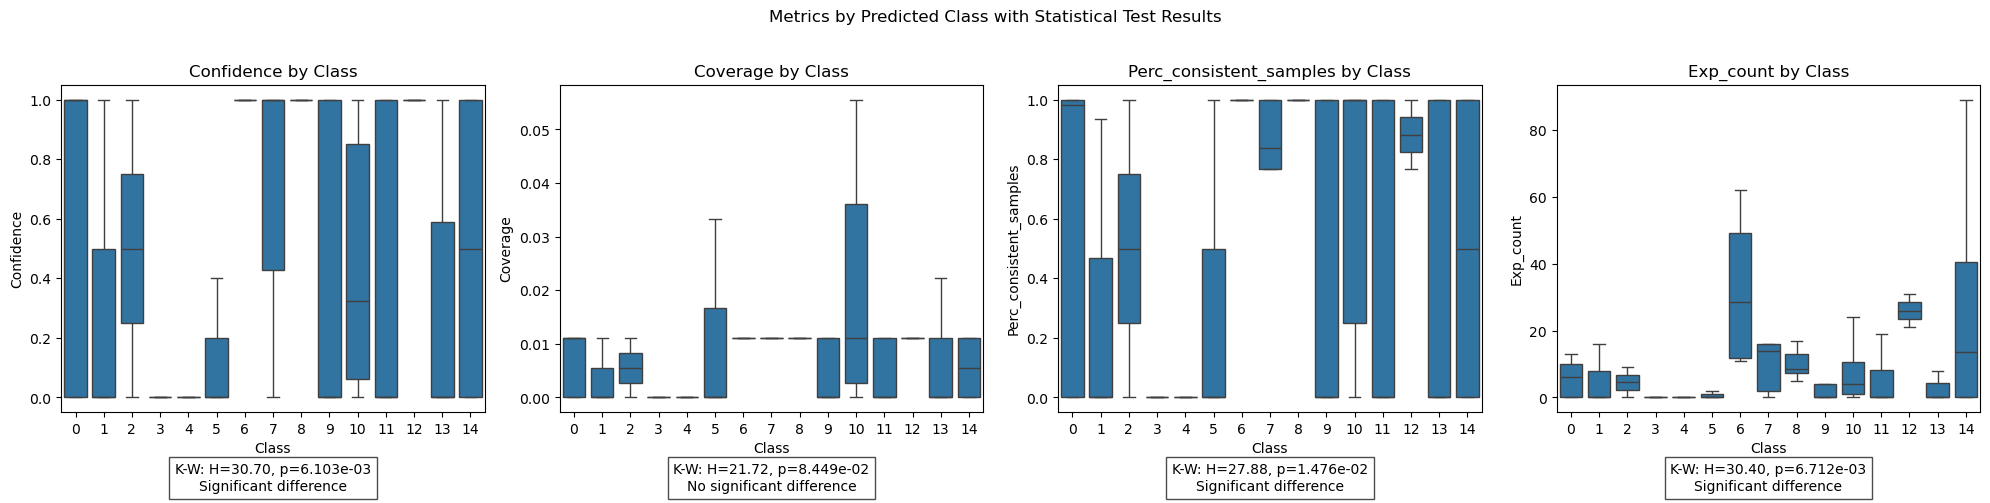

Note: Feature percentile visualization skipped due to lack of raw data.


In [220]:
analyze_rules(rules_multi_shap_global_true)

### Use optuna

In [12]:
def compute_dataset_method_stats(
        rules: List[List[Dict[str, Any]]]
) -> Tuple[str, float]:
    """
    Analyze all non-empty rules across all observations to determine:
    1) A string with the global counts of each method, e.g. "anchor=12,lime=9".
    2) A float in [0, 1] representing the 'evenness' of these method counts.
       - 0 means all rules come from exactly one method (no diversity).
       - 1 means a perfectly even split across all distinct methods.
    """
    # Flatten all non-empty rules for all observations
    all_non_empty_rules = []
    for rule_list in rules:
        for r in rule_list:
            if r.get('rule', {}) != {}:  # only non-empty
                all_non_empty_rules.append(r)

    method_counts = Counter(r.get("method", "unknown") for r in all_non_empty_rules)

    # Build a distribution string, e.g. "anchor=12,lime=9,shap=5"
    distribution_str = ",".join(
        f"{m}={cnt}" for m, cnt in sorted(method_counts.items())
    )

    total = sum(method_counts.values())
    if total <= 1:
        # If there is 0 or 1 rule, there's no real diversity
        return distribution_str, 0.0

    # Simpson's index approach: sum(p_i^2), p_i = fraction of total
    # Evenness = [1 - sum_i(p_i^2)] normalized by the max possible for 'k' methods
    p_sq_sum = 0.0
    for m in method_counts:
        p = method_counts[m] / total
        p_sq_sum += p * p

    simpson_diversity = 1.0 - p_sq_sum
    k = len(method_counts)

    if k > 1:
        # Max possible diversity = 1 - 1/k (perfectly balanced among k methods)
        max_diversity = 1.0 - 1.0 / k
        if max_diversity > 0:
            evenness = simpson_diversity / max_diversity
        else:
            evenness = 0.0
    else:
        # Only one method: no real diversity
        evenness = 0.0

    return distribution_str, evenness


def calculate_metric(rules: List[List[Dict[str, Any]]],
                     min_conf_threshold: float = 0.5,
                     min_cov_threshold: float = 0.01,
                     max_features_threshold: float = 10.0) -> Tuple[
    float, int, int, int, int, float, float, float, float, float]:
    """
    Calculate a metric to evaluate the quality of generated rules on a per-observation basis,
    then average across all observations.

    For each observation (each inner list in `rules`):
    1. Compute the median coverage and median confidence.
    2. Base metric for the observation = median_coverage * median_confidence.
    3. Apply penalties if median coverage or median confidence is below given thresholds.
    4. If the observation has only empty rules or no rules at all, the metric for that observation = 0.
    5. Penalize if the median number of features per rule exceeds `max_features_threshold`.
    6. At the end, average the observation-level metrics to get the final metric.

    Args:
        rules (List[List[Dict[str, Any]]]): Nested list of rules.
            Example:
            [
              [rule_for_obs_0_1, rule_for_obs_0_2, ...],  # Observation 0 rules
              [rule_for_obs_1_1, rule_for_obs_1_2, ...],  # Observation 1 rules
              ...
            ]
            Each rule dict should contain:
            - 'coverage' (float)
            - 'confidence' (float)
            - 'rule' (dict) mapping features to conditions, empty dict if no rule

        min_conf_threshold (float): Minimum median confidence threshold for penalty.
        min_cov_threshold (float): Minimum median coverage threshold for penalty.
        max_features_threshold (float): Maximum median number of features per rule
                                        before applying a penalty.

    Returns:
        - final_metric (float): The final metric after averaging across observations and counters of penalties used; for RuleEnsembler
        - no_rules_penalty (int):
        - low_median_confidence_penalty (int):
        - low_median_coverage_penalty (int):
        - features_count_penalty (int):
        - avg_confidence (float): raw average of all non-empty rule confidences
        - avg_coverage (float): raw average of all non-empty rule coverages
        - explained_ratio (float): fraction of observations that have at least one non-empty rule
        - avg_features_count (float):
        - median_features_count (float):
    """
    if not rules:
        # No observations, no rules
        return 0.0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0

    observation_metrics = []
    all_confidences = []
    all_coverages = []
    all_features_count = []
    no_rules_penalty, low_median_confidence_penalty, low_median_coverage_penalty, features_count_penalty, explained_count = 0, 0, 0, 0, 0

    for rule_list in rules:
        if not rule_list or all((r.get('rule', {}) == {}) for r in rule_list):
            # No rules for this observation or only empty rules
            observation_metrics.append(0.0)
            no_rules_penalty += 1
            all_features_count.append(0)
            continue
        else:
            # We have at least one non-empty rule
            explained_count += 1

        # Extract coverage and confidence
        coverages = [r.get('coverage', 0.0) for r in rule_list]
        confidences = [r.get('confidence', 0.0) for r in rule_list]
        features_count = [len(r.get('rule', [])) for r in rule_list]

        # Collect for "raw" averages
        all_confidences.extend(confidences)
        all_coverages.extend(coverages)
        all_features_count.extend(features_count)

        # Compute median coverage and median confidence
        median_coverage = np.median(coverages) if coverages else 0.0
        median_confidence = np.median(confidences) if confidences else 0.0

        # Base metric per observation
        obs_metric = median_coverage * median_confidence

        # Penalize low median confidence
        if min_conf_threshold > median_confidence > 0:
            factor = median_confidence / min_conf_threshold
            obs_metric *= factor
            low_median_confidence_penalty += 1

        # Penalize low median coverage
        if min_cov_threshold > median_coverage > 0:
            factor = median_coverage / min_cov_threshold
            obs_metric *= factor
            low_median_coverage_penalty += 1

        # Compute median number of features per rule for non-empty rules
        non_empty_rules = [r for r in rule_list if r.get('rule', {}) != {}]
        if non_empty_rules:
            feature_counts = [len(r.get('rule', {})) for r in non_empty_rules]
            median_feature_count = np.median(feature_counts) if feature_counts else 0.0

            if median_feature_count > max_features_threshold:
                factor = max_features_threshold / median_feature_count
                obs_metric *= factor
                features_count_penalty += 1

        observation_metrics.append(obs_metric)

    # Final metric is the average of all observation metrics
    if observation_metrics:
        final_metric = np.mean(observation_metrics)
    else:
        final_metric = 0.0

    avg_confidence = float(np.mean(all_confidences)) if all_confidences else 0.0
    avg_coverage = float(np.mean(all_coverages)) if all_coverages else 0.0
    explained_ratio = 100 * explained_count / len(rules) if len(rules) > 0 else 0.0
    avg_features_count = float(np.mean(all_features_count)) if all_features_count else 0.0
    median_features_count = float(np.median(all_features_count)) if all_features_count else 0.0

    return (final_metric * 100, no_rules_penalty, low_median_confidence_penalty, low_median_coverage_penalty,
            features_count_penalty, avg_confidence, avg_coverage, explained_ratio, avg_features_count,
            median_features_count)


def append_csv_results(csv_filepath: str,
                       trial_number: int,
                       metric_value: float,
                       params: Dict[str, Any]) -> None:
    """
    Append a new row with trial results to a CSV file.

    If the file does not exist, it creates a new one with headers.
    Otherwise, it appends a new line.

    Args:
        csv_filepath (str): Path to the CSV file.
        trial_number (int): The number of the current trial.
        metric_value (float): The metric value from this trial.
        params (Dict[str, Any]): Dictionary of trial parameters.
    """
    fieldnames = ["trial_number", "metric_value"] + list(params.keys())
    file_exists = os.path.isfile(csv_filepath)

    if not file_exists:
        with open(csv_filepath, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

    with open(csv_filepath, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        row = {"trial_number": trial_number, "metric_value": metric_value}
        row.update(params)
        writer.writerow(row)


def analyze_csv_data__optuna(csv_filepath: str) -> Optional[dict]:
    """
    Analyze the Optuna CSV file and collect specific statistics.

    Args:
        csv_filepath (str): Path to the CSV file.

    Returns:
        Optional[dict]: Dictionary with analysis results, or None if the file doesn't exist.
    """
    if not os.path.isfile(csv_filepath):
        logging.error(f"File not found: {csv_filepath}")
        return None

    # Load the CSV file
    df = pd.read_csv(csv_filepath)

    # Number of rows
    num_rows = len(df)

    # Metric value range
    metric_value_min = round(df['metric_value'].min(), 2)
    metric_value_max = round(df['metric_value'].max(), 2)

    # No rules penalty count range
    no_rules_penalty_min = df['no_rules_penalty_count'].min()
    no_rules_penalty_max = df['no_rules_penalty_count'].max()

    # Counter for use_global_importance
    use_global_importance_counter = df['use_global_importance'].value_counts().to_dict()

    # Counter for best_run
    if 'best_run' in df.columns:
        best_run_counter = df['best_run'].value_counts().to_dict()
    else:
        best_run_counter = {}

    # Prepare results
    analysis_results = {
        'num_rows': num_rows,
        'metric_value_range': f"{metric_value_min} to {metric_value_max}",
        'no_rules_penalty_range': f"{no_rules_penalty_min} to {no_rules_penalty_max}",
        'use_global_importance_counter': use_global_importance_counter,
        'best_run_counter': best_run_counter,
    }

    return analysis_results


def check_if_already_optimized(csv_filepath: str, min_trials_in_csv) -> bool:
    """
    Check if the given CSV file already exists and log statistics.

    Args:
        csv_filepath (str): Path to the CSV file.

    Returns:
        bool: True if the file exists, False otherwise.
    """
    if not os.path.isfile(csv_filepath):
        return False

    results = analyze_csv_data__optuna(csv_filepath)
    if results is None:
        return False

    dataset_name = csv_filepath.split('/')[-2:-1]
    dataset_name = "_".join(dataset_name)

    # Log warnings or errors based on the number of rows
    if results['num_rows'] < 10:
        logging.error(
            f"{dataset_name}: "
            f"N={results['num_rows']}, "
            f"Metric Value Range: {results['metric_value_range']}, "
            f"No Rules Penalty Range: {results['no_rules_penalty_range']}, "
            f"Use Global Importance: {', '.join(f'{k}: {v}' for k, v in results['use_global_importance_counter'].items())}, "
            f"Best Run: {', '.join(f'{k}: {v}' for k, v in results['best_run_counter'].items())}. ")
    elif results['num_rows'] < 20:
        logging.warning(
            f"{dataset_name}: "
            f"N={results['num_rows']}, "
            f"Metric Value Range: {results['metric_value_range']}, "
            f"No Rules Penalty Range: {results['no_rules_penalty_range']}, "
            f"Use Global Importance: {', '.join(f'{k}: {v}' for k, v in results['use_global_importance_counter'].items())}, "
            f"Best Run: {', '.join(f'{k}: {v}' for k, v in results['best_run_counter'].items())}. ")
    else:
        logging.info(
            f"{dataset_name}: "
            f"N={results['num_rows']}, "
            f"Metric Value Range: {results['metric_value_range']}, "
            f"No Rules Penalty Range: {results['no_rules_penalty_range']}, "
            f"Use Global Importance: {', '.join(f'{k}: {v}' for k, v in results['use_global_importance_counter'].items())}, "
            f"Best Run: {', '.join(f'{k}: {v}' for k, v in results['best_run_counter'].items())}. ")

    if results['num_rows'] < min_trials_in_csv:
        logging.info(f"WOULD RERUN {dataset_name} because {results['num_rows']} < {min_trials_in_csv}")
        return False

    return True


def objective_for_rule_generator(trial: optuna.Trial,
                                 trainX: np.ndarray, trainy: np.ndarray,
                                 testX: np.ndarray, testy: np.ndarray,
                                 explainer_train: Any, explainer_test: Any,
                                 model: Any, explainer_name: str,
                                 dataset_name: str, csv_filepath: str) -> float:
    """
    Objective function for Optuna to find the best hyperparameters for the RuleGenerator.

    Steps:
    1. Sample hyperparameters.
    2. Create and fit a pipeline with these hyperparameters.
    3. Generate rules from test data.
    4. Calculate metric based on these rules.
    5. Always append trial results to CSV.
    6. If this metric improves upon the best known metric so far, save the rules immediately.

    Args:
        trial (optuna.Trial): Optuna trial object.
        trainX (np.ndarray): Training features.
        trainy (np.ndarray): Training labels.
        testX (np.ndarray): Test features.
        testy (np.ndarray): Test labels.
        explainer_train (Any): Training explanations data.
        explainer_test (Any): Test explanations data.
        model (Any): Pre-trained model.
        explainer_name (str): Name of the explainer ("lime_to_rules" or "shap_to_rules").
        dataset_name (str): Name of the dataset.
        csv_filepath (str): Path to the CSV file for logging results.

    Returns:
        float: The metric value for the given hyperparameters.
    """
    # Sample hyperparameters
    threshold_percentile = trial.suggest_int("threshold_percentile", 50, 99, step=1)
    use_global_importance = trial.suggest_categorical("use_global_importance", [True, False])
    perturb_sigma = trial.suggest_float("perturb_sigma", 0.01, 1.0)
    perturbation_samples_count = trial.suggest_int("perturbation_samples_count", 1_000, 10_000, step=1_000)

    params = {
        "trial": trial.number,
        "threshold_percentile": threshold_percentile,
        "use_global_importance": use_global_importance,
        "perturb_sigma": perturb_sigma,
        "perturbation_samples_count": perturbation_samples_count
    }
    print(json.dumps(params, indent=4))

    # Create pipeline
    pipeline = Pipeline([
        (explainer_name,
         RuleGenerator(model=model,
                       explanation_values=explainer_train,
                       feature_names=None,
                       threshold_percentile=threshold_percentile,
                       use_global_importance=use_global_importance,
                       perturb_sigma=perturb_sigma,
                       perturbation_samples_count=perturbation_samples_count,
                       tf_verbose=None))
    ])

    pipeline.fit(trainX, trainy)
    rules = pipeline.named_steps[explainer_name].transform(testX, testy, explainer_test)
    (metric_value, no_rules_penalty, low_median_confidence_penalty, low_median_coverage_penalty, features_count_penalty,
     avg_confidence, avg_coverage, explained_ratio,
     avg_features_count, median_features_count) = calculate_metric(rules)
    metric_con_xratio = avg_confidence * explained_ratio
    metric_con_cov_xratio = avg_confidence * avg_coverage * explained_ratio
    params['no_rules_penalty_count'] = no_rules_penalty
    params['low_median_confidence_penalty_count'] = low_median_confidence_penalty
    params['low_median_coverage_penalty_count'] = low_median_coverage_penalty
    params['features_count_penalty_count'] = features_count_penalty
    params['avg_confidence'] = avg_confidence
    params['avg_coverage'] = avg_coverage
    params['explained_ratio'] = explained_ratio
    params['metric_con_xratio'] = metric_con_xratio
    params['metric_con_cov_xratio'] = metric_con_cov_xratio
    params['avg_features_count'] = avg_features_count
    params['median_features_count'] = median_features_count

    # Check if improvement over best so far
    # We'll store the best metric so far in study.user_attrs
    best_run = False
    best_metric_so_far = trial.study.user_attrs.get("best_metric", None)
    if best_metric_so_far is None or metric_value > best_metric_so_far:
        # Update best metric
        trial.study.user_attrs["best_metric"] = metric_value
        best_run = True

    params['best_run'] = best_run

    # Always append results to CSV
    append_csv_results(csv_filepath, trial.number, metric_value, params)

    if best_run:
        # If improvement, also save the explanations (rules)
        postfix = "_globalT_" if use_global_importance else "_globalF_"
        save_explanations(dataset_name,
                          explainer_name,
                          additional_postfix=postfix,
                          explanations_train=None,
                          explanations_test=rules)
        save_explanations(dataset_name,
                          explainer_name,
                          additional_postfix="_best_",
                          explanations_train=None,
                          explanations_test=rules)

    gc.collect()

    return metric_value * 1_000


def optimise_dataset_rule_generator(dataset_name: str, explainer_name: str, min_trials_in_csv: int = 0) -> None:
    """
    Process a single dataset by:
    - Loading the data and explanations
    - Checking required data presence
    - Running Optuna optimization if results are not already present
    - Trying both globalT and globalF setups

    Args:
        dataset_name (str): The name of the dataset.
        explainer_name (str): Explanation type, "lime_to_rules" or "shap_to_rules".
    """
    print(f"================== Processing {dataset_name} with {explainer_name} ==================")

    # Load data with globalT and globalF postfixes
    lf_dataset = load_explanations(dataset_name, raise_on_error=False, print_on_error=False, load_model=True,
                                   compatibility=USE_H5_COMPATIBILITY,
                                   additional_postfixes=["_globalT_", "_globalF_", "_best_"])

    # Check data presence
    if "trainX" not in lf_dataset or "testX" not in lf_dataset or "trainy" not in lf_dataset or "testy" not in lf_dataset:
        print(f"Missing required data for {dataset_name}, skipping.")
        return

    if explainer_name.startswith("lime") and ("lime_tr" not in lf_dataset or "lime_ts" not in lf_dataset):
        print(f"Missing LIME explanations for {dataset_name}, skipping {explainer_name}.")
        return
    if explainer_name.startswith("shap") and ("shap_tr" not in lf_dataset or "shap_ts" not in lf_dataset):
        print(f"Missing SHAP explanations for {dataset_name}, skipping {explainer_name}.")
        return

    trainX_dataset, testX_dataset = lf_dataset["trainX"], lf_dataset["testX"]
    trainy_dataset, testy_dataset = lf_dataset["trainy"], lf_dataset["testy"]

    if explainer_name.startswith("lime"):
        explainer_train_dataset = lf_dataset["lime_tr"]
        explainer_test_dataset = lf_dataset["lime_ts"]
    else:  # shap
        explainer_train_dataset = lf_dataset["shap_tr"]
        explainer_test_dataset = lf_dataset["shap_ts"]

    # Determine directory type
    if dataset_name in datasets_multi:
        directory_ = 'multivariate'
    elif dataset_name in datasets_uni:
        directory_ = 'univariate'
    else:
        print(f"Dataset {dataset_name} not recognized, skipping.")
        return

    dataset_path = os.path.join(data_path, 'ds', directory_, dataset_name)

    # Try both globalT and globalF in a single loop
    # Actually, we will just run Optuna once and parameters that come out will produce best results.
    # According to the instructions, we want to handle both globalT and globalF.
    # The 'use_global_importance' is a parameter in the search space, so both will be tested by Optuna automatically.
    # We want a single CSV per explainer (not per global setting):
    csv_filename = f"{explainer_name}_results.csv"
    csv_filepath = os.path.join(dataset_path, csv_filename)

    # If csv exists, skip optimization
    if check_if_already_optimized(csv_filepath, min_trials_in_csv):
        print(f"Already have optimization results for {explainer_name} on {dataset_name}. Skipping optimization.")
        return

    model_dataset = lf_dataset["model"]

    # Create an Optuna study
    # a_storage = f"sqlite:///{new_tempdir}/optuna.db"
    # a_storage = optuna.storages.InMemoryStorage()
    a_storage = optuna.storages.RDBStorage(
        url=f"sqlite:///{db_path}",
        engine_kwargs={"connect_args": {"timeout": 5}},
        skip_compatibility_check=True,
    )

    study = optuna.create_study(direction="maximize", storage=a_storage)
    study.enqueue_trial({
        "threshold_percentile": 90,
        "use_global_importance": True,
        "perturb_sigma": 1.0 if directory_ == 'univariate' else 0.1,
        "perturbation_samples_count": 10_000
    })
    study.optimize(lambda tr: objective_for_rule_generator(
        tr, trainX_dataset, trainy_dataset, testX_dataset, testy_dataset,
        explainer_train_dataset, explainer_test_dataset,
        model_dataset, explainer_name, dataset_name, csv_filepath), n_trials=20)

    # Print best hyperparameters
    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    del trainX_dataset, testX_dataset, trainy_dataset, testy_dataset, explainer_train_dataset, explainer_test_dataset, model_dataset, trial, study
    gc.collect()

In [13]:
check_if_already_optimized("shared/UCI-Benchmark/ds/univariate/Chinatown/shap_to_rules_results.csv", 21)
check_if_already_optimized("shared/UCI-Benchmark/ds/multivariate/BasicMotions/shap_to_rules_results.csv", 20)

INFO: Chinatown: N=20, Metric Value Range: 0.51 to 53.02, No Rules Penalty Range: 0 to 72, Use Global Importance: True: 12, False: 8, Best Run: True: 20. 
INFO: WOULD RERUN Chinatown because 20 < 21
INFO: BasicMotions: N=20, Metric Value Range: 0.02 to 4.01, No Rules Penalty Range: 0 to 5, Use Global Importance: True: 14, False: 6, Best Run: . 


True

#### Order of datasets

In [13]:
datasets_uni = sorted(datasets_uni)
datasets_uni = ["Wafer", "GunPointMaleVersusFemale", "GunPointAgeSpan", "GunPointOldVersusYoung", "GunPoint",
                ] + [a for a in datasets_uni if
                     a not in ["Wafer", "GunPointMaleVersusFemale", "GunPointAgeSpan", "GunPointOldVersusYoung",
                               "GunPoint",
                               "TwoPatterns", "DiatomSizeReduction", ]
                     ] + [
                   "TwoPatterns", "DiatomSizeReduction", ]
print(len(datasets_uni), datasets_uni)

84 ['Wafer', 'GunPointMaleVersusFemale', 'GunPointAgeSpan', 'GunPointOldVersusYoung', 'GunPoint', 'Adiac', 'BME', 'Beef', 'BeetleFly', 'BirdChicken', 'CBF', 'Chinatown', 'ChlorineConcentration', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'ECG200', 'ECG5000', 'ECGFiveDays', 'Earthquakes', 'ElectricDevices', 'FaceFour', 'FiftyWords', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'Herring', 'InsectWingbeatSound', 'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2', 'Lightning7', 'Meat', 'MedicalImages', 'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect', 'MiddlePhalanxTW', 'MoteStrain', 'OSULeaf', 'OliveOil', 'PhalangesOutlinesCorrect', 'Plane', 'PowerCons', 'ProximalPhalanxOutlineAgeGroup', 'ProximalPhalanxOutlineCorrect', 'ProximalPhalanxTW', 'RefrigerationDevices', 'ScreenType', 'Shap

In [14]:
datasets_multi = sorted(datasets_multi)
datasets_multi = ["BasicMotions"] + [a for a in datasets_multi if
                                     a not in ["BasicMotions", "Handwriting", "HandMovementDirection", "Heartbeat"]] + [
                     "Heartbeat", "Handwriting", "HandMovementDirection", ]
print(len(datasets_multi), datasets_multi)

20 ['BasicMotions', 'ArticularyWordRecognition', 'AtrialFibrillation', 'Cricket', 'ERing', 'Epilepsy', 'EthanolConcentration', 'FaceDetection', 'FingerMovements', 'LSST', 'Libras', 'NATOPS', 'PenDigits', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'UWaveGestureLibrary', 'Heartbeat', 'Handwriting', 'HandMovementDirection']


In [19]:
print(ds)

'UWaveGestureLibraryAll'

In [17]:
print(datasets_uni[::-1])

['InsectWingbeatSound', 'ChlorineConcentration', 'MoteStrain', 'WordSynonyms', 'FiftyWords', 'DistalPhalanxTW', 'Earthquakes', 'MiddlePhalanxTW', 'Adiac', 'SonyAIBORobotSurface1', 'FreezerSmallTrain', 'Coffee', 'GunPointOldVersusYoung', 'BirdChicken', 'Lightning7', 'FreezerRegularTrain', 'FordB', 'LargeKitchenAppliances', 'ProximalPhalanxOutlineAgeGroup', 'UWaveGestureLibraryZ', 'DodgerLoopWeekend', 'Beef', 'BME', 'CricketZ', 'ShapeletSim', 'ProximalPhalanxOutlineCorrect', 'Wine', 'UWaveGestureLibraryY', 'Lightning2', 'MiddlePhalanxOutlineCorrect', 'Wafer', 'SonyAIBORobotSurface2', 'CricketY', 'Computers', 'ScreenType', 'ShapesAll', 'SmallKitchenAppliances', 'TwoLeadECG', 'ToeSegmentation2', 'Symbols', 'CBF', 'GunPoint', 'ItalyPowerDemand', 'OSULeaf', 'Worms', 'RefrigerationDevices', 'Crop', 'Herring', 'Yoga', 'GunPointMaleVersusFemale', 'BeetleFly', 'PowerCons', 'FordA', 'SyntheticControl', 'FaceFour', 'PhalangesOutlinesCorrect', 'ECG5000', 'CricketX', 'SwedishLeaf', 'ElectricDevices'

In [ ]:
# Process all datasets and run for both LIME and SHAP
# Confidence and coverage are on test set
for ds in datasets_uni[::-1] + datasets_multi[::-1]:
    print(f"==================================== Processing {ds} ====================================")
    optimise_dataset_rule_generator(ds, "shap_to_rules", min_trials_in_csv=3)
    optimise_dataset_rule_generator(ds, "lime_to_rules", min_trials_in_csv=3)

==================================== Processing DiatomSizeReduction ====================================
================== Processing DiatomSizeReduction with shap_to_rules ==================
Dataset DiatomSizeReduction is univariate
Loading model in tf format...


2025-02-12 08:07:00.735419: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO: DiatomSizeReduction: N=20, Metric Value Range: 0.0 to 13.57, No Rules Penalty Range: 0 to 59, Use Global Importance: True: 10, False: 10, Best Run: . 


model: type= <class 'keras.src.engine.sequential.Sequential'>
anchor_tr: type= <class 'list'>
anchor_ts: type= <class 'list'>
shap_tr: type= <class 'numpy.ndarray'>
shap_ts: type= <class 'numpy.ndarray'>
lime_tr: type= <class 'numpy.ndarray'>
lime_ts: type= <class 'numpy.ndarray'>
shap_to_rules_globalT_ts: type= <class 'list'>
shap_to_rules_globalF_ts: type= <class 'list'>
shap_to_rules_best_ts: type= <class 'list'>
lime_to_rules_globalT_ts: type= <class 'list'>
lime_to_rules_globalF_ts: type= <class 'list'>
lime_to_rules_best_ts: type= <class 'list'>
trainX: type= <class 'numpy.ndarray'>
trainy: type= <class 'numpy.ndarray'>
testX: type= <class 'numpy.ndarray'>
testy: type= <class 'numpy.ndarray'>
Already have optimization results for shap_to_rules on DiatomSizeReduction. Skipping optimization.
================== Processing DiatomSizeReduction with lime_to_rules ==================
Dataset DiatomSizeReduction is univariate
Loading model in tf format...


INFO: DiatomSizeReduction: N=20, Metric Value Range: 0.35 to 19.15, No Rules Penalty Range: 0 to 67, Use Global Importance: True: 15, False: 5, Best Run: . 


model: type= <class 'keras.src.engine.sequential.Sequential'>
anchor_tr: type= <class 'list'>
anchor_ts: type= <class 'list'>
shap_tr: type= <class 'numpy.ndarray'>
shap_ts: type= <class 'numpy.ndarray'>
lime_tr: type= <class 'numpy.ndarray'>
lime_ts: type= <class 'numpy.ndarray'>
shap_to_rules_globalT_ts: type= <class 'list'>
shap_to_rules_globalF_ts: type= <class 'list'>
shap_to_rules_best_ts: type= <class 'list'>
lime_to_rules_globalT_ts: type= <class 'list'>
lime_to_rules_globalF_ts: type= <class 'list'>
lime_to_rules_best_ts: type= <class 'list'>
trainX: type= <class 'numpy.ndarray'>
trainy: type= <class 'numpy.ndarray'>
testX: type= <class 'numpy.ndarray'>
testy: type= <class 'numpy.ndarray'>
Already have optimization results for lime_to_rules on DiatomSizeReduction. Skipping optimization.
==================================== Processing TwoPatterns ====================================
================== Processing TwoPatterns with shap_to_rules ==================
Dataset TwoPatte

In [ ]:
1 + 1

#### Check csv & cp file with best result

In [12]:
def process_dataset(prefix: str,
                    dataset_name: str,
                    dataset_dir: str,
                    data_path: str,
                    results_csv_name: str) -> None:
    # Construct paths
    full_dir_path = os.path.join(data_path, 'ds', dataset_dir, dataset_name)
    csv_path = os.path.join(full_dir_path, results_csv_name)

    file_t = os.path.join(full_dir_path, f"{prefix}_globalT_ts.pickle")
    file_f = os.path.join(full_dir_path, f"{prefix}_globalF_ts.pickle")
    file_best = os.path.join(full_dir_path, f"{prefix}_best_ts.pickle")

    # Check CSV existence
    if not os.path.isfile(csv_path):
        logging.error(f"[{dataset_name}-{prefix}] Missing CSV: {csv_path}")
        return

    # Read CSV and check number of trials
    df = pd.read_csv(csv_path)
    if len(df) < 20:
        logging.error(f"[{dataset_name}-{prefix}] Not enough trials (<20) in CSV.")
        return

    # Identify best result (row with max metric_value)
    best_row = df.loc[df['metric_value'].idxmax()]
    best_trial = int(best_row.get('trial_number', -1))
    best_is_global = bool(best_row.get('use_global_importance', False))
    logging.info(f"[{dataset_name}-{prefix}] Best trial: {best_trial}")

    # Check if T/F pickle files exist
    t_exists = os.path.isfile(file_t)
    f_exists = os.path.isfile(file_f)
    if not t_exists and not f_exists:
        logging.error(f"[{dataset_name}-{prefix}] Neither T nor F pickle file found.")
        return

    # Get newest file among T/F (if it exists)
    newest = None
    if t_exists and f_exists:
        t_mtime = os.path.getmtime(file_t)
        f_mtime = os.path.getmtime(file_f)
        newest = file_t if t_mtime > f_mtime else file_f
    elif t_exists:
        newest = file_t
    elif f_exists:
        newest = file_f

    # Compare newest with best from CSV
    expected_best_file = file_t if best_is_global else file_f
    if newest and newest != expected_best_file:
        logging.warning(f"[{dataset_name}-{prefix}] Newest file does not match best in CSV.")

    # Copy best file to _best_ts if not present
    if os.path.isfile(file_best):
        logging.info(f"[{dataset_name}-{prefix}] '{prefix}_best_ts.pickle' already exists, no copy made.")
    else:
        if os.path.isfile(expected_best_file):
            shutil.copy2(expected_best_file, file_best)
            logging.info(f"[{dataset_name}-{prefix}] Copied '{expected_best_file}' to '{file_best}'.")
        else:
            logging.error(f"[{dataset_name}{prefix}] Best file not found: {expected_best_file}")

In [ ]:
for ds in datasets_uni:
    process_dataset(prefix="lv2rul",
                    dataset_name=ds,
                    dataset_dir="univariate",
                    data_path=data_path,
                    results_csv_name="lime_to_rules_results.csv")
    process_dataset(prefix="sv2rul",
                    dataset_name=ds,
                    dataset_dir="univariate",
                    data_path=data_path,
                    results_csv_name="shap_to_rules_results.csv")
    # break


In [ ]:
for ds in datasets_multi:
    process_dataset(prefix="lv2rul",
                    dataset_name=ds,
                    dataset_dir="multivariate",
                    data_path=data_path,
                    results_csv_name="lime_to_rules_results.csv")
    process_dataset(prefix="sv2rul",
                    dataset_name=ds,
                    dataset_dir="multivariate",
                    data_path=data_path,
                    results_csv_name="shap_to_rules_results.csv")

## Transform rules to importances

In [13]:
class FeatureImportancesGenerator(BaseEstimator, TransformerMixin):
    """
    Convert rule-based explanations into feature-based importance vectors for time-series shaped data.

    This class takes a model and rule-based explanations (e.g., from ANCHOR), where each rule is a set of conditions
    on features. It produces a feature importance vector for each instance based on how narrowly the rules constrain
    each feature's value range, compared to the original training distribution.

    Data shape: (n_samples, n_timesteps, n_variables).
    Feature names are generated as "time_{t}_var_{v}" if not provided for n_variables > 1
    and feature_{i} if n_variables == 1.

    Importance calculation:
    importance = 1 - (final_interval_width / (original_interval_width + 1e-5))

    If multiple rules are provided for one instance, we combine them via logical AND. If the intersection of intervals
    is empty for a feature, importance = 0 for that feature and a warning is issued. After determining all intervals,
    we also compute coverage and confidence by using a similar method as in RuleGenerator.
    
    We assume `y` provided to transform are the model predictions (classes). `reference_class` is extracted from the
    first rule in `rules_for_instance` (assuming it contains a "prediction" key).

    Parameters
    ----------
    model : Any
        Model for context if needed.
    explanation_values : Any
        Potential background info or training-based explanations. Not strictly used here.
    feature_names : List[str], optional
        Feature names. If None, generated automatically.
    """

    def __init__(self, model: Any, explanation_values: Any, feature_names: Optional[List[str]] = None):
        self.model = model
        self.explanation_values = explanation_values
        self.feature_names = feature_names
        self.feature_stats = None
        self.X = None
        self.y = None
        self.n_timesteps_ = None
        self.n_variables_ = None

    def fit(self, X: np.ndarray, y: np.ndarray = None):
        """
        Fit the transformer on training data to store feature min and max values.
        
        Parameters
        ----------
        X : np.ndarray
            Training data of shape (n_samples, n_timesteps, n_variables).
        y : np.ndarray, optional
            Labels, not used here.
        
        Returns
        -------
        self : FeatureImportancesGenerator
        """
        n_samples, n_timesteps, n_variables = X.shape
        self.n_timesteps_ = n_timesteps
        self.n_variables_ = n_variables

        if self.feature_names is None:
            if n_variables == 1:
                self.feature_names = [f"feature_{i}" for i in range(n_timesteps)]
            else:
                self.feature_names = [f"time_{t}_var_{v}" for t in range(n_timesteps) for v in range(n_variables)]
        assert self.n_timesteps_ * self.n_variables_ == len(
            self.feature_names), f"! There is {len(self.feature_names)} feature_names, while it should be {self.n_timesteps_ * self.n_variables_}"

        X_flat = X.reshape(n_samples, n_timesteps * n_variables)
        self.feature_stats = {
            feature: {
                "mean": np.mean(X_flat[:, i]),
                "std": np.std(X_flat[:, i]),
                "min": np.min(X_flat[:, i]),
                "max": np.max(X_flat[:, i])
            }
            for i, feature in enumerate(self.feature_names)
        }

        self.X = X
        self.y = y

        return self

    def transform(self,
                  X: np.ndarray,
                  y: np.ndarray,
                  rule_explanations: List[List[Dict[str, Any]]]) -> Tuple[np.ndarray, np.ndarray, float, float]:
        """
        Transform instances by converting their rule-based explanations into feature-based importance vectors.
        
        Parameters
        ----------
        X : np.ndarray
            Data for which we want to compute feature importances.
            Shape: (n_samples, n_timesteps, n_variables)
        y : np.ndarray
            True classes corresponding to X.
        rule_explanations : List[List[Dict[str, Any]]]
            For each instance, a list of rule dictionaries.
            Each rule dict has a 'rule' key: {feature: [conditions]}
            and possibly a 'prediction' key.

        Returns
        -------
        importances : np.ndarray
            Array of shape (n_samples, n_timesteps, n_variables) with computed importances,
            array with y returned by explainer, list of coverage values and confidence values.
        """
        n_samples, n_timesteps, n_variables = X.shape
        assert n_timesteps == self.n_timesteps_ and n_variables == self.n_variables_, "Shape mismatch with fit."
        n_features = n_timesteps * n_variables
        print(f"There is {len(self.feature_names)} feature_names, last 3: {self.feature_names[-3:]}")

        # Predict on the whole set
        y_classes = np.argmax(y, axis=1)
        y_predictions = self.model.predict(X)
        y_pred_classes = np.argmax(y_predictions, axis=1)
        # Print classification metrics for the provided data
        print("=== Classification metrics on provided data ===")
        print("Accuracy:", accuracy_score(y_classes, y_pred_classes))
        print("F1 (macro):", f1_score(y_classes, y_pred_classes, average='macro'))
        print("Precision (macro):", precision_score(y_classes, y_pred_classes, average='macro', zero_division=0))
        print("Recall (macro):", recall_score(y_classes, y_pred_classes, average='macro'))
        # print("y_pred_classes len:", len(y_pred_classes), "y_pred_classes:", y_pred_classes)

        importances = np.zeros((n_samples, n_timesteps, n_variables))
        coverage_values, confidence_values, y_from_rules = [], [], []

        for i in range(n_samples):
            rules_for_instance = rule_explanations[i]
            if rules_for_instance[0]["success"] == False:
                rules_for_instance = [
                    {'index': i, 'success': False, 'prediction': str(y_pred_classes[i]), 'rule': {},
                     'anchor_method': 'mock', 'anchor': [], 'confidence': 0.0, 'coverage': 1.0, 'exp_count': 0}]
            # print("rules_for_instance:", rules_for_instance)
            if len(rules_for_instance) == 0:
                # No rules means no restriction, importance=0
                # But no coverage restrictions either. Let's proceed with no intervals.
                pass
            else:
                # Extract reference_class from the first rule if available
                if "prediction" in rules_for_instance[0]:
                    reference_class = int(rules_for_instance[0]["prediction"])
                else:
                    raise ValueError(
                        f"No 'prediction' key found in the first rule of the instance: {rules_for_instance[0]}.")

                # Initialize full range intervals (using global min/max from training)
                # We'll store intervals as (low_val, high_val)
                # For coverage/confidence, we need final conditions after intersection
                # We'll record final intervals and then create a rule dict
                final_intervals = [(
                    self.feature_stats[self.feature_names[f]]["min"],
                    self.feature_stats[self.feature_names[f]]["max"]
                ) for f in range(n_features)]

                # Intersect intervals from all rules
                for single_rule_dict in rules_for_instance:
                    rule = single_rule_dict.get("rule", {})
                    for feature, conditions in rule.items():
                        if feature not in self.feature_names:
                            raise ValueError(f"Feature '{feature}' not in feature_names.")
                        f_idx = self.feature_names.index(feature)
                        current_low, current_high = final_intervals[f_idx]
                        rule_low, rule_high = self._get_range(
                            conditions,
                            self.feature_stats[feature]["min"],
                            self.feature_stats[feature]["max"]
                        )
                        new_low = max(current_low, rule_low)
                        new_high = min(current_high, rule_high)
                        final_intervals[f_idx] = (new_low, new_high)

                # Now compute importance and build final rule conditions
                rule_dict = {}
                empty_intersection = False
                for f_idx in range(n_features):
                    feature = self.feature_names[f_idx]
                    original_low = self.feature_stats[feature]["min"]
                    original_high = self.feature_stats[feature]["max"]
                    original_width = original_high - original_low

                    low_val, high_val = final_intervals[f_idx]
                    if high_val < low_val:
                        # Empty intersection
                        empty_intersection = True
                        importance = 0.0
                        # No conditions for this feature in final rule if empty
                        conds = []
                    else:
                        final_width = high_val - low_val
                        ratio = final_width / (original_width + 1e-5)
                        importance = 1.0 - ratio
                        # Create conditions if interval is smaller than the original
                        conds = []
                        # If low_val > original_low, add a lower bound condition
                        if low_val > original_low + 1e-10:
                            conds.append(f">{low_val}")
                        # If high_val < original_high, add an upper bound condition
                        if high_val < original_high - 1e-10:
                            conds.append(f"<={high_val}")

                    t = f_idx // n_variables
                    v = f_idx % n_variables
                    importances[i, t, v] = importance
                    if len(conds) > 0:
                        rule_dict[feature] = conds

                # Compute coverage and confidence using the final rule_dict
                coverage, confidence = self._compute_coverage_and_confidence(rule_dict, X, y_pred_classes,
                                                                             reference_class)
                coverage_values.append(coverage)
                confidence_values.append(confidence)
                y_from_rules.append(reference_class)

                if empty_intersection:
                    warnings.warn(f"For sample {i}, empty intersection in at least one feature. Coverage=0.")
                else:
                    if coverage == 0.0:
                        warnings.warn(f"For sample {i}, coverage=0 after applying intervals from rules.")

        return importances, np.array(y_from_rules), coverage_values, confidence_values

    def _parse_rule(self, cond: str) -> Tuple[str, float]:
        """
        Parse a condition string like '>0.5' or '<=1.2' into an operator and a float value.
        """
        if cond.startswith('>='):
            op = '>='
            val = float(cond[2:])
        elif cond.startswith('>'):
            op = '>'
            val = float(cond[1:])
        elif cond.startswith('<='):
            op = '<='
            val = float(cond[2:])
        elif cond.startswith('<'):
            op = '<'
            val = float(cond[1:])
        else:
            raise ValueError(f"Unknown rule format: {cond}")
        return op, val

    def _get_range(self, rules: List[str], low: float, high: float) -> Tuple[float, float]:
        """
        Determine the range defined by the rule conditions for a single feature.
        """
        assert len(rules) <= 2, "Each feature's rule conditions should have at most two conditions."
        if len(rules) == 0:
            return (low, high)
        elif len(rules) == 1:
            op, val = self._parse_rule(rules[0])
            if op in ['>=', '>']:
                return (max(val, low), high)
            else:
                return (low, min(val, high))
        else:
            # Two conditions
            op1, val1 = self._parse_rule(rules[0])
            op2, val2 = self._parse_rule(rules[1])

            lower_candidates = []
            upper_candidates = []
            for op, val in [(op1, val1), (op2, val2)]:
                if op in ['>', '>=']:
                    lower_candidates.append(max(val, low))
                else:
                    upper_candidates.append(min(val, high))

            final_low = max(lower_candidates) if len(lower_candidates) > 0 else low
            final_high = min(upper_candidates) if len(upper_candidates) > 0 else high
            return (final_low, final_high)

    def _compute_coverage_and_confidence(self,
                                         rule: Dict[str, List[str]],
                                         X: np.ndarray,
                                         y: np.ndarray,
                                         reference_class: int) -> Tuple[float, float]:
        """
        Compute coverage and confidence for the given rule.

        Parameters
        ----------
        rule : Dict[str, List[str]]
            A dictionary where keys are feature names and values are intervals as conditions, e.g. [">0.5", "<=1.2"].
        X : np.ndarray
            The dataset to evaluate coverage and confidence, shape (n_samples, n_timesteps, n_variables).
        y : np.ndarray
            Predicted classes for X, shape (n_samples,).
        reference_class : int
            The class predicted for the original instance being explained.

        Returns
        -------
        coverage_value : float
            The fraction of samples in X that meet all the rule conditions.
        confidence_value : float
            The fraction of covered samples that belong to the reference_class.
        """
        mask = np.ones(X.shape[0], dtype=bool)
        if not rule:
            # No restrictions means coverage=1.0, confidence = proportion of ref_class in all
            pass
        else:
            for feature, interval in rule.items():
                # interval e.g. [">0.5", "<=1.2"] or one-sided: ["<=1.2"]
                # parse both and apply
                lower_val, upper_val = self._interval_to_bounds(interval)
                f_idx = self.feature_names.index(feature)
                # Assuming X is (n_samples, n_timesteps, n_variables)
                # Convert f_idx into t, v
                t = f_idx // self.n_variables_
                v = f_idx % self.n_variables_
                current_mask = (X[:, t, v] > lower_val) & (X[:, t, v] <= upper_val)
                mask = mask & current_mask

        coverage_value = mask.mean()
        if coverage_value == 0:
            return coverage_value, 0.0

        covered_indices = np.where(mask)[0]
        confidence_value = np.mean(y[covered_indices] == reference_class)
        return coverage_value, confidence_value

    def _interval_to_bounds(self, interval: List[str]) -> Tuple[float, float]:
        """
        Convert a list of conditions like [">0.5", "<=1.2"] into numeric bounds.
        If one condition, we derive the other bound as min or max from a large range.
        """
        # Similar logic to _get_range, but here we assume at most two conditions.
        # We'll unify approach:
        low = -np.inf
        high = np.inf
        for cond in interval:
            op, val = self._parse_rule(cond)
            if op in ['>', '>=']:
                low = max(low, val)
            else:
                high = min(high, val)
        return (low, high)


### Anchor -> importances

#### Univariate

In [30]:
explainer_train_uni_anchor, explainer_test_uni_anchor = lf_Wafer["anchor_tr"], lf_Wafer["anchor_ts"]

# Load pre-trained Keras model  
# model_uni = lf_Wafer["model"]

print(explainer_train_uni_anchor[0], explainer_test_uni_anchor[0])
print(trainX_uni.shape, testX_uni.shape)
print(trainy_uni.shape, testy_uni.shape)

[{'index': 0, 'success': True, 'prediction': '1', 'rule': {'feature_58': ['>-0.62'], 'feature_117': ['>-0.83']}, 'anchor_method': 'alibi', 'anchor': ['feature_58 > -0.62', 'feature_117 > -0.83'], 'confidence': 0.9675745784695201, 'coverage': 0.651, 'exp_count': 2}] [{'index': 0, 'success': True, 'prediction': '1', 'rule': {'feature_74': ['<=0.82'], 'feature_75': ['<=0.83']}, 'anchor_method': 'alibi', 'anchor': ['feature_74 <= 0.82', 'feature_75 <= 0.83'], 'confidence': 0.9339853300733496, 'coverage': 0.747, 'exp_count': 2}]
(5373, 152, 1) (1791, 152, 1)
(5373, 2) (1791, 2)


In [293]:
pipeline_uni_anchor = Pipeline([
    ("importances_generator",
     FeatureImportancesGenerator(model=model_uni, explanation_values=explainer_train_uni_anchor))
])

pipeline_uni_anchor.fit(trainX_uni, trainy_uni)
feature_importances_uni_anchor, y_explainer_predicted_uni, coverages_uni_anchor, confidences_uni_anchor = \
    pipeline_uni_anchor.named_steps[
        'importances_generator'].transform(testX_uni, testy_uni, explainer_test_uni_anchor)

There is 152 feature_names, last 3: ['feature_149', 'feature_150', 'feature_151']
56/56 [==============================] - 1s 10ms/step
=== Classification metrics on provided data ===
Accuracy: 0.998324958123953
F1 (macro): 0.9953332030486612
Precision (macro): 0.9941032341239586
Recall (macro): 0.9965710484337231


In [294]:
feature_importances_uni_anchor.shape, y_explainer_predicted_uni.shape

((1791, 152, 1), (1791,))

In [295]:
coverages_uni_anchor[-10:], confidences_uni_anchor[-10:], y_explainer_predicted_uni[-10:],

([0.2250139586823004,
  0.21831379117811278,
  0.2601898380792853,
  0.3707426018983808,
  0.724176437744277,
  0.417643774427694,
  0.5298715801228364,
  0.6420993858179788,
  0.02233389168062535,
  0.49246231155778897],
 [0.9801488833746899,
  0.9974424552429667,
  0.9978540772532188,
  1.0,
  0.8673862760215882,
  1.0,
  0.9936775553213909,
  0.948695652173913,
  0.975,
  0.9897959183673469],
 array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1]))

#### Multivariate

In [31]:
explainer_train_multi_anchor, explainer_test_multi_anchor = lf_Libras["anchor_tr"], lf_Libras["anchor_ts"]

# Load pre-trained Keras model
# model_multi = lf_Libras["model"]

print(explainer_train_multi_anchor[0], explainer_test_multi_anchor[0])
print(trainX_multi.shape, testX_multi.shape)
print(trainy_multi.shape, testy_multi.shape)

[{'index': 0, 'success': False, 'anchor_method': 'marcotcr', 'error': 'A process in the process pool was terminated abruptly while the future was running or pending.,\nTraceback (most recent call last):\n  File "fast/tmp/ipykernel_844/3351978020.py", line 284, in anchor_pool_worker\n    result = future.result(timeout=t_out)\n  File "/home/jovyan/.conda/envs/uci_38v4/lib/python3.8/concurrent/futures/_base.py", line 444, in result\n    return self.__get_result()\n  File "/home/jovyan/.conda/envs/uci_38v4/lib/python3.8/concurrent/futures/_base.py", line 389, in __get_result\n    raise self._exception\nconcurrent.futures.process.BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.\n'}] [{'index': 0, 'success': False, 'anchor_method': 'marcotcr', 'error': 'A process in the process pool was terminated abruptly while the future was running or pending.,\nTraceback (most recent call last):\n  File "fast/tmp/ipykernel_844/3351978020.py

In [33]:
n_samples_multi, n_timesteps_multi, n_variables_multi = trainX_multi.shape
feature_names_multi = [f"feature_{i}" for i in range(n_timesteps_multi * n_variables_multi)]
print(f"feature_names len: {len(feature_names_multi)}, last 3: {feature_names_multi[-3:]}")

pipeline_multi_anchor = Pipeline([
    ("importances_generator",
     FeatureImportancesGenerator(model=model_multi, explanation_values=explainer_train_multi_anchor,
                                 feature_names=feature_names_multi))
])

pipeline_multi_anchor.fit(trainX_multi, trainy_multi)
feature_importances_multi_anchor, y_explainer_predicted_multi, coverages_multi_anchor, confidences_multi_anchor = \
    pipeline_multi_anchor.named_steps[
        'importances_generator'].transform(testX_multi, testy_multi, explainer_test_multi_anchor)

feature_names len: 90, last 3: ['feature_87', 'feature_88', 'feature_89']
There is 90 feature_names, last 3: ['feature_87', 'feature_88', 'feature_89']
3/3 [==============================] - 0s 5ms/step
=== Classification metrics on provided data ===
Accuracy: 0.6333333333333333
F1 (macro): 0.6040356432428043
Precision (macro): 0.661031746031746
Recall (macro): 0.6226984126984128


In [297]:
feature_importances_multi_anchor.shape, y_explainer_predicted_multi.shape, len(coverages_multi_anchor), len(
    confidences_multi_anchor)

((90, 45, 2), (90,), 90, 90)

## Analyse importances

In [14]:
def statistical_test_by_class(metric_values: np.ndarray, classes: np.ndarray) -> Tuple[str, float, bool]:
    unique_classes = np.unique(classes)
    if len(unique_classes) == 1:
        return ("None", np.nan, False)
    elif len(unique_classes) == 2:
        group1 = metric_values[classes == unique_classes[0]]
        group2 = metric_values[classes == unique_classes[1]]
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
        return ("Mann-Whitney", p, p < 0.05)
    else:
        data_groups = [metric_values[classes == c] for c in unique_classes]
        stat, p = kruskal(*data_groups)
        return ("Kruskal-Wallis", p, p < 0.05)


def add_stat_test_annotation(ax: plt.Axes, test_name: str, p_value: float, significant: bool) -> None:
    if test_name == "None":
        text = "Only one class, no test performed."
    else:
        text = f"{test_name} p={p_value:.3e}\n{'Significant difference' if significant else 'No significant difference'}"
    ax.text(0.5, -0.15, text,
            ha='center', va='top', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))


def can_convert_all_to_int(vals):
    try:
        [int(v) for v in vals]
        return True
    except ValueError:
        return False


def visualize_feature_importance(
        coverages: List[float],
        confidences: List[float],
        feature_importances: np.ndarray,
        feature_names: List[str],
        y_pred_classes: np.ndarray,
        title_prefix: str = "? - "
) -> None:
    sns.set_style("darkgrid")

    df_metrics = pd.DataFrame({"coverage": coverages, "confidence": confidences})

    # 1. Coverage & Confidence hist + boxplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f"{title_prefix}Hist & Boxplots of Coverage and Confidence", y=1.02)

    df_metrics["coverage"].hist(bins=20, ax=axes[0, 0], color="skyblue")
    axes[0, 0].set_title("Coverage Histogram")

    df_metrics["confidence"].hist(bins=20, ax=axes[0, 1], color="skyblue")
    axes[0, 1].set_title("Confidence Histogram")

    sns.boxplot(y="coverage", data=df_metrics, orient='h', showfliers=False, color="skyblue", ax=axes[1, 0])
    axes[1, 0].set_title("Coverage Boxplot")

    sns.boxplot(y="confidence", data=df_metrics, orient='h', showfliers=False, color="skyblue", ax=axes[1, 1])
    axes[1, 1].set_title("Confidence Boxplot")

    plt.tight_layout()
    plt.show()

    # 2. Global feature importances
    n_samples, n_timesteps, n_variables = feature_importances.shape
    n_features = n_timesteps * n_variables
    fi_flat = feature_importances.reshape(n_samples, n_features)
    mean_importances = fi_flat.mean(axis=0)
    sorted_indices = np.argsort(mean_importances)[::-1]
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_importances = mean_importances[sorted_indices]

    plt.figure(figsize=(8, max(6, len(sorted_features) * 0.15)))
    sns.barplot(x=sorted_importances, y=sorted_features, color='skyblue', orient='h')
    plt.title(f"{title_prefix}Global Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # 3. Boxplots by class (coverage & confidence)
    df_class_metrics = pd.DataFrame({
        "class": y_pred_classes.astype(str),
        "coverage": coverages,
        "confidence": confidences
    })

    classes = df_class_metrics["class"].unique()
    if can_convert_all_to_int(classes):
        class_ints = [int(c) for c in classes]
        class_ints_sorted = sorted(class_ints)
        class_order = [str(c) for c in class_ints_sorted]
    else:
        # Just sort them as strings
        class_order = sorted(classes, key=str)

    metrics_to_plot = ["confidence", "coverage"]
    fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(12, 4))
    fig.suptitle(f"{title_prefix}Metrics by Predicted Class with Statistical Test Results", y=1.05)

    for ax, metric in zip(axes, metrics_to_plot):
        sns.boxplot(x="class", y=metric, data=df_class_metrics, showfliers=False, color="skyblue", ax=ax,
                    order=class_order)
        ax.set_title(f"{metric.capitalize()} by Class")
        ax.set_xlabel("Class")

        test_name, p_value, significant = statistical_test_by_class(df_class_metrics[metric].values, y_pred_classes)
        add_stat_test_annotation(ax, test_name, p_value, significant)

    plt.tight_layout()
    plt.show()

    # 4. Feature importances by class as grouped horizontal bar plots
    df_fi = pd.DataFrame(fi_flat)
    df_fi["class"] = y_pred_classes.astype(str)
    class_mean_fi = df_fi.groupby("class").mean()

    # Sort by importance in the lowest class index
    all_classes = np.unique(y_pred_classes)
    base_class = str(np.min(all_classes))
    base_class_importances = class_mean_fi.loc[base_class].values
    sort_idx = np.argsort(base_class_importances)[::-1]
    sorted_feat_names = [feature_names[i] for i in sort_idx]

    # Rename columns of class_mean_fi to feature names after sorting
    class_mean_fi_sorted = class_mean_fi.iloc[:, sort_idx]
    class_mean_fi_sorted.columns = sorted_feat_names

    # Melt
    df_melt = class_mean_fi_sorted.reset_index()
    df_melt = df_melt.melt(id_vars="class", var_name="feature", value_name="importance")
    # Debug print
    print("Melted Data (sample):")
    print(df_melt.head())

    classes_for_hue = df_melt["class"].unique()
    if can_convert_all_to_int(classes_for_hue):
        class_ints_hue = [int(c) for c in classes_for_hue]
        class_ints_hue_sorted = sorted(class_ints_hue)
        class_order_for_hue = [str(c) for c in class_ints_hue_sorted]
    else:
        class_order_for_hue = sorted(classes_for_hue, key=str)

    plt.figure(figsize=(10, max(6, len(sorted_feat_names) * 0.15)))
    sns.barplot(x="importance", y="feature", hue="class", data=df_melt,
                orient='h', order=sorted_feat_names, hue_order=class_order_for_hue, dodge=True, palette="Set2", ci=None)

    plt.title(f"{title_prefix}Feature Importances by Predicted Class (Mean Values)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')

    min_val = df_melt["importance"].min()
    max_val = df_melt["importance"].max()
    if min_val == max_val:
        plt.xlim(min_val - 0.001, max_val + 0.001)
    else:
        plt.xlim(min_val - abs(min_val) * 0.1, max_val + abs(max_val) * 0.1)

    # Optional reference line at 0 if needed
    plt.axvline(x=0, color='red', linestyle='--')

    plt.tight_layout()
    plt.show()

### Univariate

/home/jovyan/.conda/envs/uci_38v4/lib/python3.8/site-packages/seaborn/_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
/home/jovyan/.conda/envs/uci_38v4/lib/python3.8/site-packages/seaborn/_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


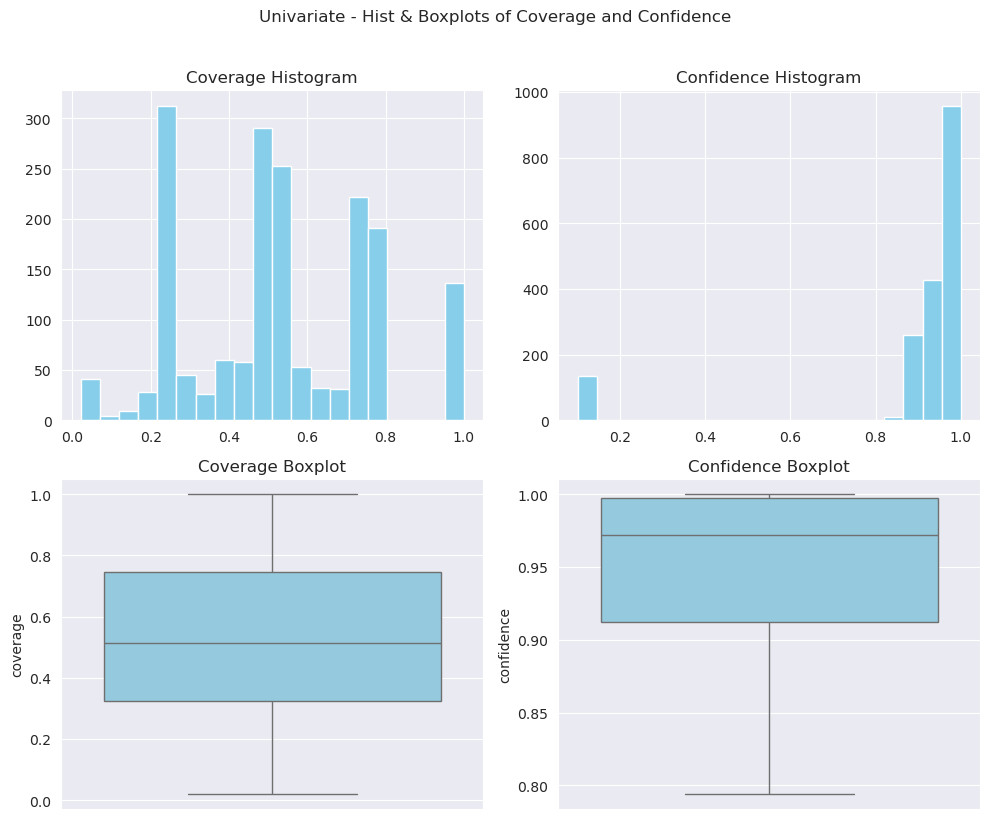

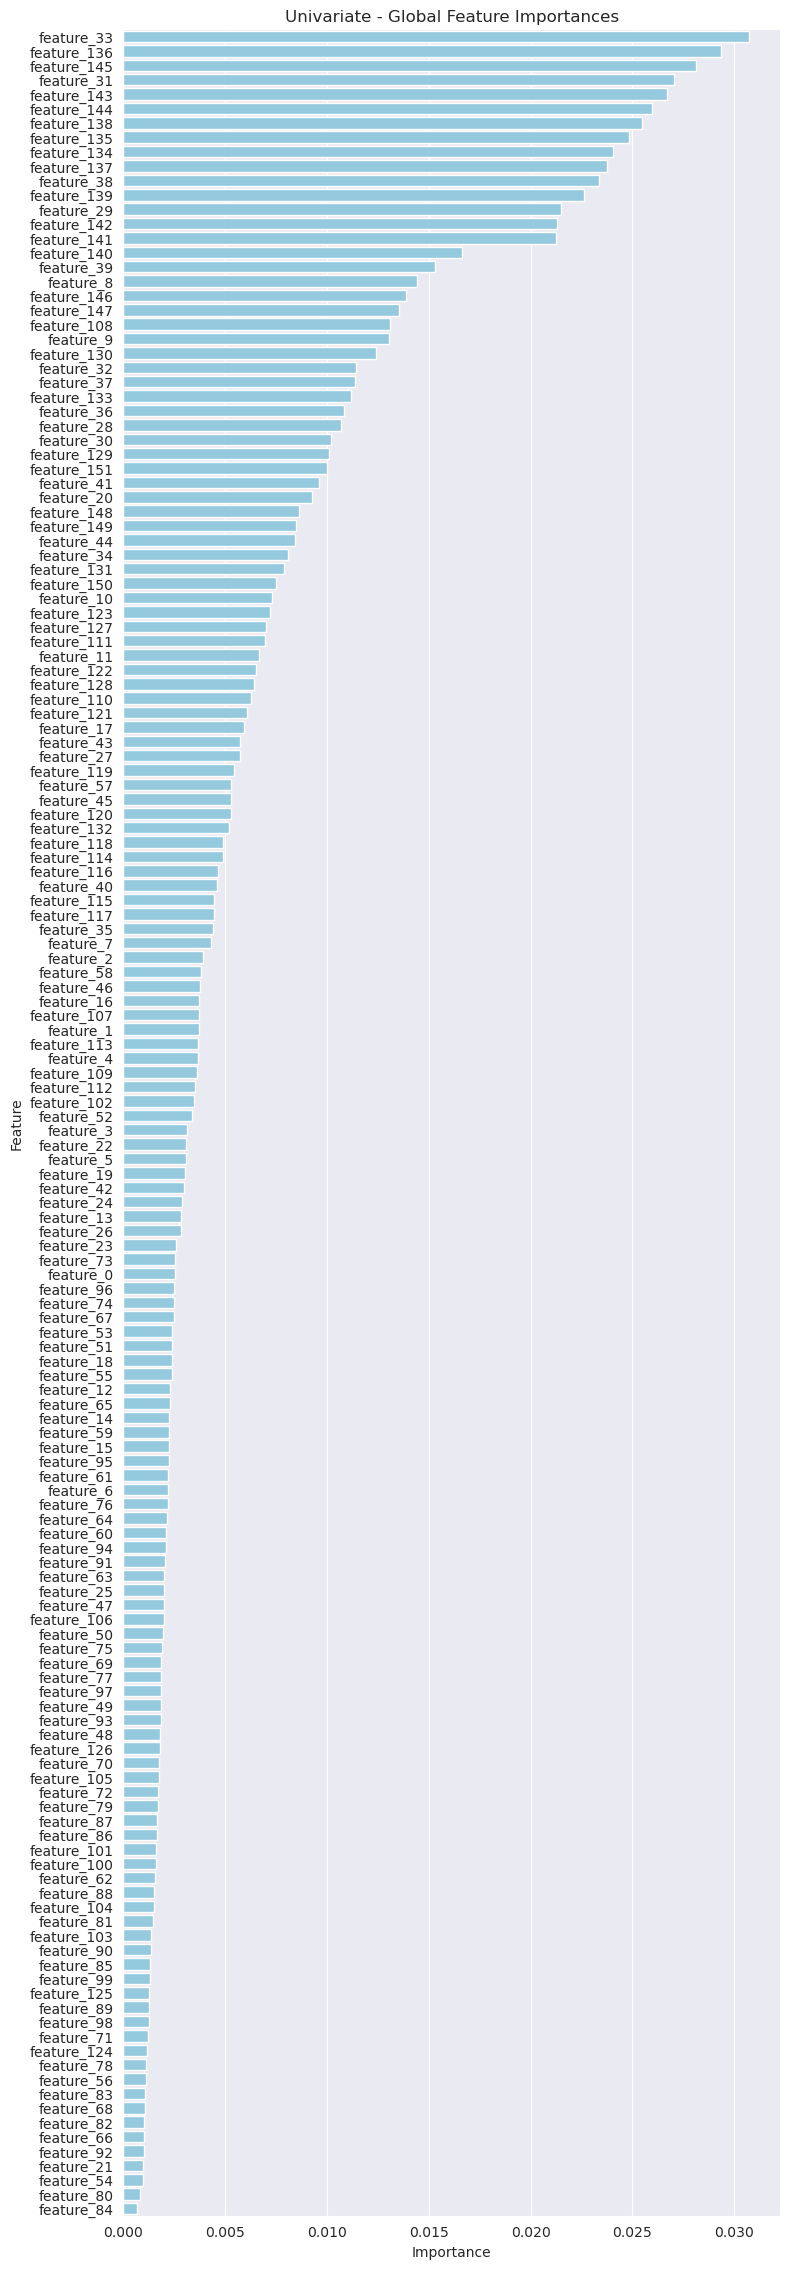

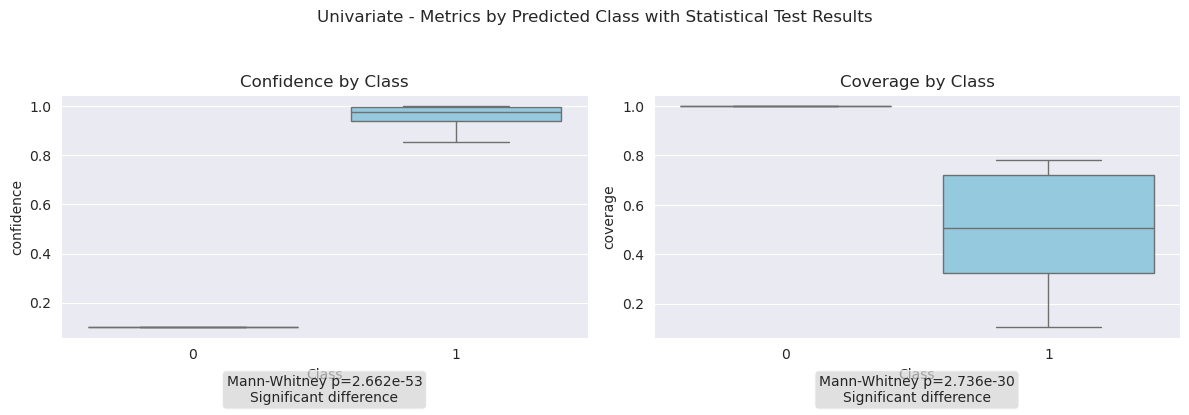

Melted Data (sample):
  class      feature  importance
0     0  feature_108    0.088592
1     1  feature_108    0.004686
2     0   feature_29    0.059011
3     1   feature_29    0.017324
4     0  feature_123    0.048263


/tmp/ipykernel_732575/2777692652.py:146: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="importance", y="feature", hue="class", data=df_melt,


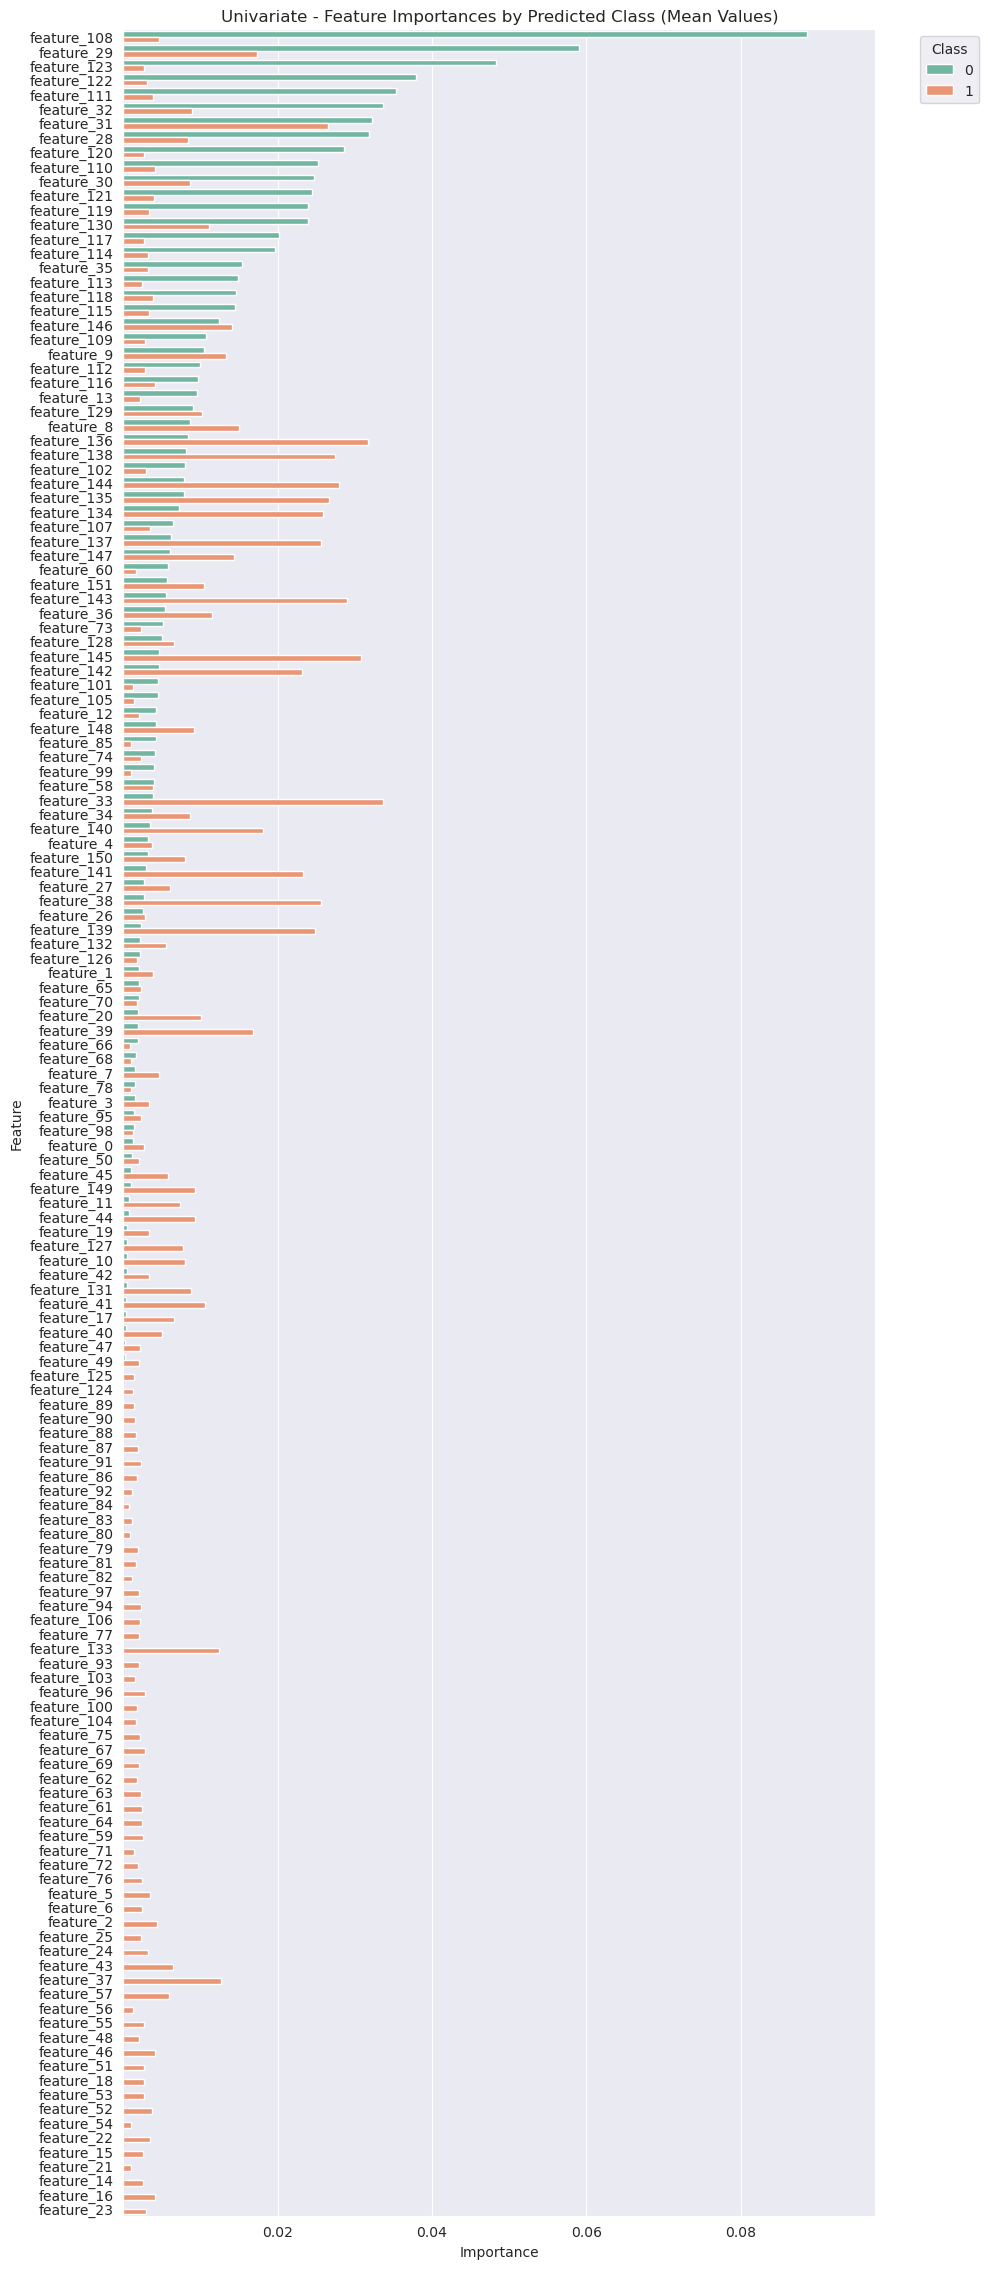

In [299]:
visualize_feature_importance(coverages_uni_anchor, confidences_uni_anchor, feature_importances_uni_anchor,
                             pipeline_uni_anchor.named_steps['importances_generator'].feature_names,
                             y_explainer_predicted_uni, title_prefix="Univariate - ")

### Multivariate

/home/jovyan/.conda/envs/uci_38v4/lib/python3.8/site-packages/seaborn/_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
/home/jovyan/.conda/envs/uci_38v4/lib/python3.8/site-packages/seaborn/_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


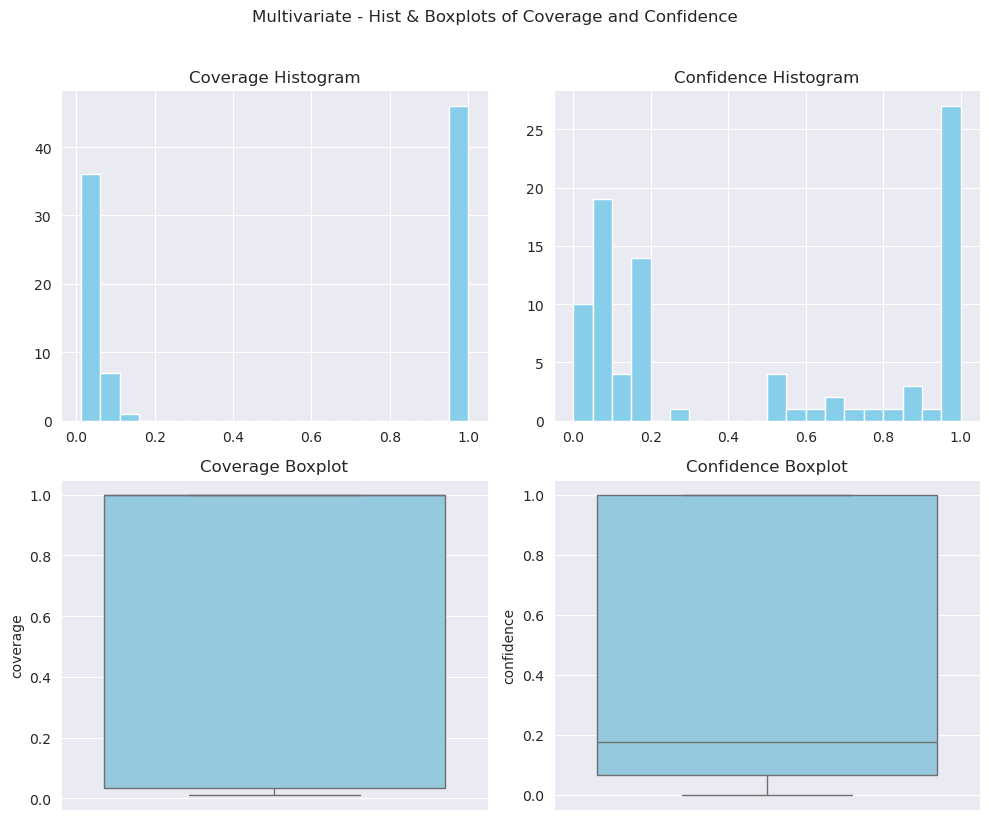

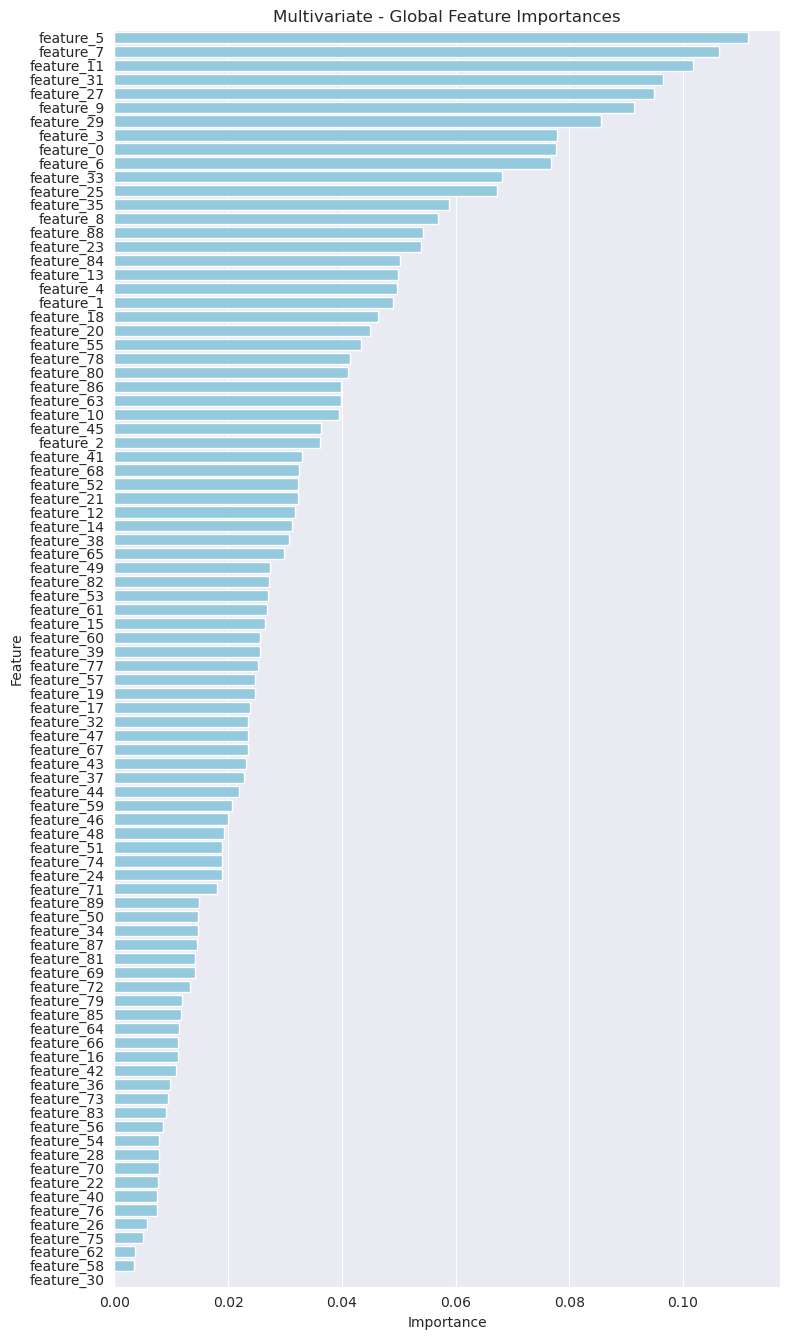

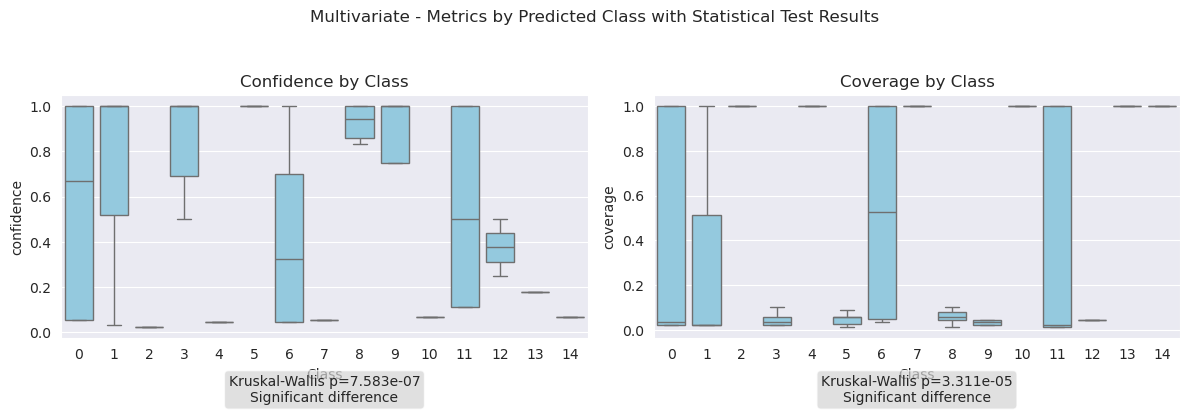

Melted Data (sample):
  class     feature  importance
0     0  feature_27    0.402081
1     1  feature_27    0.000002
2    10  feature_27    0.000002
3    11  feature_27    0.143346
4    12  feature_27    0.000002


/tmp/ipykernel_732575/2777692652.py:146: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="importance", y="feature", hue="class", data=df_melt,


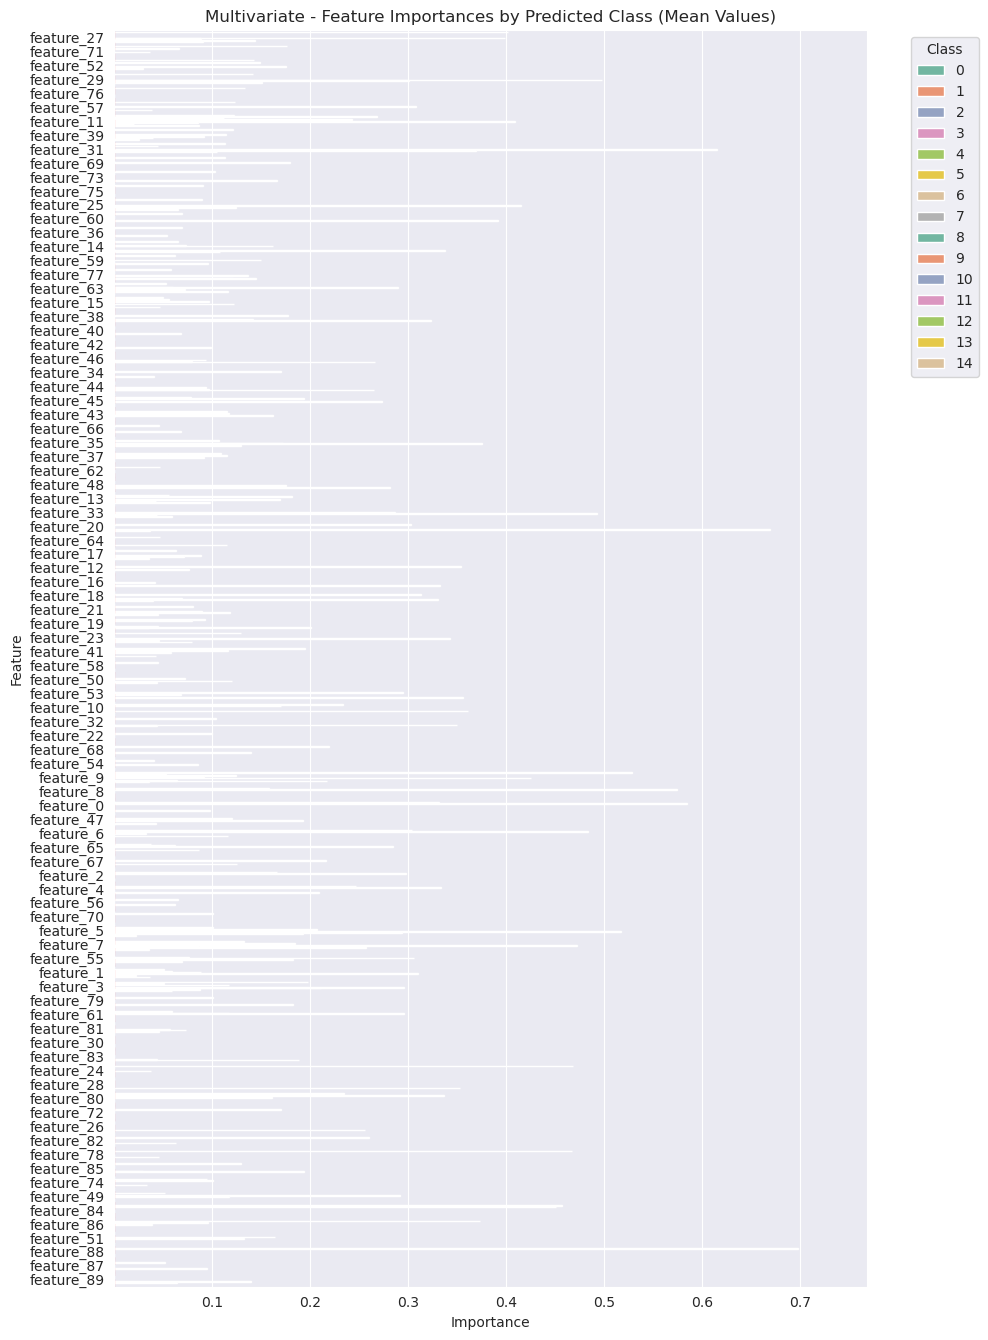

In [300]:
visualize_feature_importance(coverages_multi_anchor, confidences_multi_anchor, feature_importances_multi_anchor,
                             pipeline_multi_anchor.named_steps['importances_generator'].feature_names,
                             y_explainer_predicted_multi, title_prefix="Multivariate - ")

# WIP Fusion of explanations

## Rules

In [ ]:
# TODO
# RuleFit - onehot encoding czy dana reguła spełniona, czy nie -> model regresji (LASSO)

In [15]:
feature_pattern_univariate = re.compile(r"^feature_(\d+)$")
feature_pattern_multivariate = re.compile(r"^time_(\d+)_var_(\d+)$")


class RuleEnsembler(BaseEstimator, TransformerMixin):
    """
    A rule-based explanation ensembling class that merges rules from multiple XAI methods.

    This class can combine multiple sets of rules (from methods like Anchor, LIME-to-rules, etc.) into a single rule per instance.
    Supported methods:
    - 'intersection': Take the intersection of conditions across all methods.
    - 'union': Take the union of conditions across all methods.
    - 'weighted': Use quality metrics (e.g., coverage, confidence) to select conditions.
    - 'lasso': Fit a LASSO model to select a minimal set of conditions that best explain the predictions or a chosen target.
    """

    def __init__(self, model: Any, feature_names: Optional[List[str]] = None, method: str = 'intersection',
                 weights_key: str = 'confidence', lasso_alpha: float = 0.01):
        """
        Parameters
        ----------
        model : Any
            The model used for predictions if needed (for coverage/confidence evaluation).
        feature_names : List[str]
            The feature names for indexing.
        method : str
            Ensemble method: 'intersection', 'union', 'weighted', 'lasso'.
        weights_key : str
            Key to use from rules for weights in 'weighted' method, e.g. 'confidence' or 'coverage'.
        lasso_alpha : float
            Regularization parameter for LASSO.
        """
        self.model = model
        self.feature_names = feature_names
        self.method = method
        self.weights_key = weights_key
        self.lasso_alpha = lasso_alpha
        self.n_timesteps_ = None
        self.n_variables_ = None
        self.feature_stats = None
        self.X = None
        self.y = None

        # Deduce n_timesteps_, n_variables_ if needed, or assume flat indexing
        if feature_names is not None:
            self.n_features_ = len(feature_names)
        else:
            self.n_features_ = None

    def fit(self, X: np.ndarray, y: np.ndarray = None):
        """
        Fit method needed for deducting shape of TS.
        """
        n_samples, n_timesteps, n_variables = X.shape
        self.n_timesteps_ = n_timesteps
        self.n_variables_ = n_variables
        self.n_features_ = n_timesteps * n_variables

        if self.feature_names is None:
            if n_variables == 1:
                self.feature_names = [f"feature_{i}" for i in range(n_timesteps)]
            else:
                self.feature_names = [f"time_{t}_var_{v}" for t in range(n_timesteps) for v in range(n_variables)]
        assert self.n_timesteps_ * self.n_variables_ == len(
            self.feature_names), f"! There is {len(self.feature_names)} feature_names, while it should be {self.n_timesteps_ * self.n_variables_}"

        self.X = X  # usually: X_train
        self.y = y  # usually: y_train

        X_flat = X.reshape(n_samples, n_timesteps * n_variables)
        # Calculate feature statistics for perturbation
        self.feature_stats = {
            feature: {
                "mean": np.mean(X_flat[:, i]),
                "std": np.std(X_flat[:, i]),
                "min": np.min(X_flat[:, i]),
                "max": np.max(X_flat[:, i])
            }
            for i, feature in enumerate(self.feature_names)
        }

        return self

    def transform(self, X: List[List[Dict[str, Any]]]) -> List[List[Dict[str, Any]]]:
        """
        Transform the given rule explanations by combining them according to the chosen method.

        Parameters
        ----------
        X : rule_explanations_list = List[List[Dict[str, Any]]]
            A list of sets of explanations. For example:
            [
              rules_from_anchor,
              rules_from_lime,
              rules_from_shap_to_rules,
              ...
            ]
            Each element (like rules_from_anchor) is a list of rule dicts for each instance.

        Returns
        -------
        combined_rules : List[List[Dict[str, Any]]]
            A list of lists of rule dictionaries, one per instance, representing the ensemble rule.
        """
        # We assume all sets have the same length (one rule per instance)
        # If not, must handle or raise error.
        n_instances = len(X[0])
        for rset in X:
            if len(rset) != n_instances:
                raise ValueError("All rule explanation sets must have the same number of instances.")

        rule_explanations_list = [self.adjust_rule_feature_names_to_scheme(rule_explanations) for rule_explanations in
                                  X]

        combined_rules = []
        for i in range(n_instances):
            # Extract rules for instance i from each method
            rules_for_instance = [r for rset in rule_explanations_list for r in rset[i]]
            # Combine them
            ens_rule = self._combine_rules_for_instance(rules_for_instance)
            combined_rules.append([ens_rule])  # returning a list of dict as per initial specs
        return combined_rules

    def _combine_rules_for_instance(self, rules_for_instance: List[Dict[str, Any]]) -> Dict[str, Any]:
        """
        Combine rules for a single instance according to the chosen method.
        """
        if self.method == 'intersection':
            return self._combine_intersection(rules_for_instance)
        elif self.method == 'union':
            return self._combine_union(rules_for_instance)
        elif self.method == 'weighted':
            return self._combine_weighted(rules_for_instance)
        elif self.method == 'lasso':
            return self._combine_lasso(rules_for_instance)
        else:
            raise ValueError(f"Unknown method {self.method}")

    def _combine_intersection(self, rules_for_instance: List[Dict[str, Any]]) -> Dict[str, Any]:
        # Each rule: {'rule': {feature: [conditions]}}
        # Collect features and conditions
        # Intersection means we only keep features that appear in ALL rules
        all_feature_sets = []
        for r in rules_for_instance:
            fset = set(r.get("rule", {}).keys())
            all_feature_sets.append(fset)
        common_features = set.intersection(*all_feature_sets) if all_feature_sets else set()

        # For those common features, we need to find intersection of conditions
        # If conditions differ, we can attempt intersection of intervals.
        # For simplicity, if multiple conditions differ, we could pick the most restrictive.

        # Collect conditions from each rule
        combined_rule = {"index": rules_for_instance[0]["index"],
                         "success": True,
                         "prediction": rules_for_instance[0]["prediction"],
                         "rule": {},
                         "method": "intersection_ensemble"}

        for f in common_features:
            # Gather all conditions
            cond_lists = []
            for r in rules_for_instance:
                conds = r.get("rule", {}).get(f, [])
                cond_lists.append(conds)

            # Attempt intersection of intervals:
            # Convert each cond_lists to a final (low, high)
            # We'll need min intersection among all sets
            low_bound = -np.inf
            high_bound = np.inf
            for conds in cond_lists:
                f_low, f_high = self._compute_feature_interval(conds)
                # intersect
                low_bound = max(low_bound, f_low)
                high_bound = min(high_bound, f_high)

            if low_bound <= high_bound:
                # Recreate conditions from low_bound and high_bound
                final_conds = self._interval_to_conditions(low_bound, high_bound)
                combined_rule["rule"][f] = final_conds

        return combined_rule

    def _combine_union(self, rules_for_instance: List[Dict[str, Any]]) -> Dict[str, Any]:
        # Union: take all features and conditions from all rules
        combined_rule = {"index": rules_for_instance[0]["index"],
                         "success": True,
                         "prediction": rules_for_instance[0]["prediction"],
                         "rule": {},
                         "method": "union_ensemble"}

        # We'll merge all intervals for a given feature by taking the broadest range
        # from all methods
        feature_bounds = {}
        for r in rules_for_instance:
            for f, conds in r.get("rule", {}).items():
                f_low, f_high = self._compute_feature_interval(conds)
                if f not in feature_bounds:
                    feature_bounds[f] = (f_low, f_high)
                else:
                    old_low, old_high = feature_bounds[f]
                    feature_bounds[f] = (min(old_low, f_low), max(old_high, f_high))

        for f, (low_val, high_val) in feature_bounds.items():
            final_conds = self._interval_to_conditions(low_val, high_val)
            combined_rule["rule"][f] = final_conds

        return combined_rule

    def _combine_weighted(self, rules_for_instance: List[Dict[str, Any]]) -> Dict[str, Any]:
        # Weighted approach: use weights from e.g. confidence
        # Steps:
        # 1) Identify all features used across methods
        # 2) For each feature, determine if it appears in each rule (1/0)
        # 3) Get weights w_m from each rule's self.weights_key
        # 4) Compute weighted presence and pick features with weighted presence > tau (e.g. 0.5)
        # 5) Compute final interval as intersection or union? Let's choose union for simplicity.

        combined_rule = {"index": rules_for_instance[0]["index"],
                         "success": True,
                         "prediction": rules_for_instance[0]["prediction"],
                         "rule": {},
                         "method": "weighted_ensemble"}

        features_all = set()
        for r in rules_for_instance:
            features_all = features_all.union(r.get("rule", {}).keys())

        weights = np.array([r.get(self.weights_key, 1.0) for r in rules_for_instance])
        weights = weights / (weights.sum() + 1e-9)

        # threshold tau
        tau = 0.5

        selected_features = []
        feature_bounds = {}
        for f in features_all:
            presence = []
            for r in rules_for_instance:
                if f in r.get("rule", {}):
                    presence.append(1)
                else:
                    presence.append(0)
            presence = np.array(presence)

            weighted_presence = (presence * weights).sum()
            if weighted_presence >= tau:
                # combine intervals for f by union of intervals from all rules that have f
                # let's just take min low and max high from all methods that have it
                f_lows = []
                f_highs = []
                for r in rules_for_instance:
                    if f in r.get("rule", {}):
                        conds = r["rule"][f]
                        fl, fh = self._compute_feature_interval(conds)
                        f_lows.append(fl)
                        f_highs.append(fh)
                low_val = min(f_lows) if f_lows else -np.inf
                high_val = max(f_highs) if f_highs else np.inf

                final_conds = self._interval_to_conditions(low_val, high_val)
                combined_rule["rule"][f] = final_conds

        return combined_rule

    def _combine_lasso(self, rules_for_instance: List[Dict[str, Any]]) -> Dict[str, Any]:
        # LASSO approach:
        # 1) Extract all unique conditions from all rules as candidate features
        # 2) Build X: n_samples_of_coverage x n_conditions (?)
        # Actually we need data: We'll use self.X_train, self.y_train?
        # Let's assume we have X, y from fit or given as attributes. If not provided, raise error.
        if not hasattr(self, 'X_train_') or not hasattr(self, 'y_train_'):
            raise ValueError("For LASSO method, please set self.X_train_ and self.y_train_ beforehand.")

        # We'll encode each condition as a binary feature:
        # For each condition from all rules_of_instance, we apply it to X_train_ and see if that condition is met by each sample.
        # Then fit LASSO to predict y_train_ (or predicted class from model) based on these condition-features.

        # Extract conditions:
        # conditions: a list of (feature, low, high)
        all_conditions = []
        condition_map = []  # (feature_name, low_val, high_val)
        for r in rules_for_instance:
            for f, conds in r.get("rule", {}).items():
                fl, fh = self._compute_feature_interval(conds)
                c_tuple = (f, fl, fh)
                if c_tuple not in condition_map:
                    condition_map.append(c_tuple)
        # condition_map now has unique conditions

        X_bin = self._conditions_to_binary_matrix(condition_map, self.X_train_)
        # Fit LASSO
        lasso = Lasso(alpha=self.lasso_alpha)
        lasso.fit(X_bin, self.y_train_)

        # Select conditions with nonzero coefficients
        coef = lasso.coef_
        selected = np.where(np.abs(coef) > 1e-9)[0]

        # Combine selected conditions by taking union of their intervals.
        combined_rule = {"index": rules_for_instance[0]["index"],
                         "success": True,
                         "prediction": rules_for_instance[0]["prediction"],
                         "rule": {},
                         "method": "lasso_ensemble"}

        # If multiple conditions per feature are selected, we can combine them by intersection
        # or union. Let's do union for simplicity:
        feature_intervals = {}
        for s in selected:
            f, fl, fh = condition_map[s]
            if f not in feature_intervals:
                feature_intervals[f] = [fl, fh]
            else:
                # union intervals
                feature_intervals[f] = [min(feature_intervals[f][0], fl),
                                        max(feature_intervals[f][1], fh)]

        for f, (low_val, high_val) in feature_intervals.items():
            final_conds = self._interval_to_conditions(low_val, high_val)
            combined_rule["rule"][f] = final_conds

        return combined_rule

    def _conditions_to_binary_matrix(self, condition_map: List[Tuple[str, float, float]], X: np.ndarray) -> np.ndarray:
        """
        Convert conditions to binary matrix indicating if each sample satisfies each condition.

        A condition is (feature_name, low_val, high_val).
        We must have self.feature_names to find the index of the feature.
        """
        M = len(condition_map)
        N = X.shape[0]
        X_bin = np.zeros((N, M), dtype=float)
        for j, (f, fl, fh) in enumerate(condition_map):
            f_idx = self.feature_names.index(f)
            # Assuming X is (n_samples, n_features) or need adaptation if 3D
            # For simplicity, assume flatten: If 3D was used before, user must adopt similarly.
            X_bin[:, j] = ((X[:, f_idx] > fl) & (X[:, f_idx] <= fh)).astype(float)
        return X_bin

    def set_training_data(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Set training data for LASSO approach.
        """
        self.X_train_ = X_train
        self.y_train_ = y_train

    def _compute_feature_interval(self, conds: List[str]) -> Tuple[float, float]:
        # Reuse logic from _get_range
        # We assume global min, max from data or just use large range
        low = -np.inf
        high = np.inf
        for cond in conds:
            op, val = self._parse_rule(cond)
            if op in ['>', '>=']:
                low = max(low, val)
            else:
                high = min(high, val)
        return (low, high)

    def _parse_rule(self, cond: str) -> Tuple[str, float]:
        if cond.startswith('>='):
            op = '>='
            val = float(cond[2:])
        elif cond.startswith('>'):
            op = '>'
            val = float(cond[1:])
        elif cond.startswith('<='):
            op = '<='
            val = float(cond[2:])
        elif cond.startswith('<'):
            op = '<'
            val = float(cond[1:])
        else:
            raise ValueError(f"Unknown rule format: {cond}")
        return op, val

    def _interval_to_conditions(self, low_val: float, high_val: float) -> List[str]:
        """
        Convert numeric bounds back to conditions.
        If low_val > -inf, add '>low_val' or '>=low_val' (prefer '>')
        If high_val < inf, add '<=high_val'
        If both -inf and inf, return empty list.
        """
        conds = []
        if np.isfinite(low_val):
            conds.append(f">{low_val}")
        if np.isfinite(high_val):
            conds.append(f"<={high_val}")
        return conds

    def adjust_rule_feature_names_to_scheme(self, rules_list: List[List[Dict[str, Any]]]) -> List[List[Dict[str, Any]]]:
        """
        Adjust the feature names in the given rules to match the scheme used in self.feature_names.

        This function inspects the feature naming pattern in the first encountered rule and attempts
        to transform all rules to that pattern if needed. If self.feature_names is None or if
        it's impossible to map the detected pattern to self.feature_names, it raises a ValueError.

        We consider two possible naming schemes:
        - Univariate-like: "feature_{i}" for i in [0, n_timesteps-1], implying a single variable scenario.
        - Multivariate-like: "time_{t}_var_{v}" for t in [0, n_timesteps-1] and v in [0, n_variables-1].

        If the given rules have a different pattern from self.feature_names, we try to map.
        For example, if the rules have "feature_10" but self.feature_names are of type "time_{t}_var_{v}",
        we must compute t, v such that i = t*n_variables_ + v and map "feature_i" -> "time_{t}_var_{v}".

        Conversely, if self.feature_names are "feature_{i}" but rules have "time_{t}_var_{v}", we compute
        i = t*n_variables_ + v and map it back.

        Parameters
        ----------
        rules_list : List[List[Dict[str, Any]]]
            The rules for multiple instances and methods, e.g.:
            [
              [rule_dict_instance0_methodA, rule_dict_instance1_methodA, ...],
              [rule_dict_instance0_methodB, rule_dict_instance1_methodB, ...],
              ...
            ]
            We assume consistent structure. We will look at the first non-empty rule to detect pattern.

        Returns
        -------
        adjusted_rules_list : List[List[Dict[str, Any]]]
            A new list of rules with adjusted feature naming if needed.

        Raises
        ------
        ValueError
            If self.feature_names is None, or if a consistent mapping cannot be established.
        """
        if self.feature_names is None:
            raise ValueError("self.feature_names must be set before adjusting rule feature names.")

        # Determine the pattern used in self.feature_names
        # Check if they match "feature_i" pattern or "time_t_var_v" pattern
        # We'll guess from the first feature_name in self.feature_names
        if len(self.feature_names) == 0:
            raise ValueError("self.feature_names is empty, cannot determine scheme.")

        first_self_feat = self.feature_names[0]
        # feature_pattern_univariate = re.compile(r"^feature_(\d+)$")
        # feature_pattern_multivariate = re.compile(r"^time_(\d+)_var_(\d+)$")

        self_is_univariate = False
        self_is_multivariate = False

        match_self_uni = feature_pattern_univariate.match(first_self_feat)
        match_self_multi = feature_pattern_multivariate.match(first_self_feat)

        if match_self_uni:
            self_is_univariate = True
        elif match_self_multi:
            self_is_multivariate = True
        else:
            raise ValueError(f"self.feature_names pattern not recognized: {first_self_feat}")

        # If multivariate, we must have self.n_timesteps_ and self.n_variables_
        if self_is_multivariate:
            if not hasattr(self, 'n_timesteps_') or not hasattr(self, 'n_variables_'):
                raise ValueError("For multivariate scheme, self.n_timesteps_ and self.n_variables_ must be defined.")

        # Now detect pattern in the rules
        # We find the first non-empty rule with at least one feature
        pattern_detected_uni = None
        pattern_detected_multi = None

        done = False
        for method_rules in rules_list:
            for rule_dict in method_rules:
                rule_feats = list(rule_dict.get("rule", {}).keys())
                if len(rule_feats) > 0:
                    # Check the first feature in this rule
                    test_feat = rule_feats[0]
                    match_rule_uni = feature_pattern_univariate.match(test_feat)
                    match_rule_multi = feature_pattern_multivariate.match(test_feat)
                    if match_rule_uni:
                        pattern_detected_uni = True
                        pattern_detected_multi = False
                    elif match_rule_multi:
                        pattern_detected_uni = False
                        pattern_detected_multi = True
                    else:
                        # Pattern not recognized
                        raise ValueError(f"Feature name pattern in rules not recognized: {test_feat}")
                    done = True
                    break
            if done:
                break

        if pattern_detected_uni is None and pattern_detected_multi is None:
            # No features found in any rule, nothing to adjust
            # Just return the same rules
            return rules_list

        # Now we know what pattern rules have and what pattern self.feature_names have
        # Possible cases:
        # 1) self_is_univariate == True and pattern_detected_uni == True => no change
        # 2) self_is_univariate == True and pattern_detected_multi == True => convert from multi to uni
        # 3) self_is_multivariate == True and pattern_detected_uni == True => convert from uni to multi
        # 4) self_is_multivariate == True and pattern_detected_multi == True => no change

        # If no change needed:
        if self_is_univariate == pattern_detected_uni and self_is_multivariate == pattern_detected_multi:
            return rules_list

        print(
            f"Feature names will be adjusted, pipeline has {'multivariate' if self_is_multivariate else 'univariate'} naming schema, "
            f"while explanation rules have {'multivariate' if pattern_detected_multi else 'univariate'} schema.")

        # If we need to convert from uni to multi:
        if self_is_multivariate and pattern_detected_uni:
            # For each feature_i in rules, we must find corresponding t,v:
            # i = t * n_variables_ + v
            # Check bounds
            n_total_features = self.n_timesteps_ * self.n_variables_

            def uni_to_multi(f_name: str) -> str:
                m = feature_pattern_univariate.match(f_name)
                if not m:
                    raise ValueError(f"Expected univariate pattern (feature_i), got {f_name}")
                i = int(m.group(1))
                if i < 0 or i >= n_total_features:
                    raise ValueError(f"Feature index {i} out of range for time/var scheme.")
                t = i // self.n_variables_
                v = i % self.n_variables_
                new_name = f"time_{t}_var_{v}"
                if new_name not in self.feature_names:
                    raise ValueError(f"Converted {f_name} to {new_name}, but {new_name} not in self.feature_names.")
                return new_name

            return _convert_rules(rules_list, uni_to_multi)

        # If we need to convert from multi to uni:
        if self_is_univariate and pattern_detected_multi:
            # We must have only 1 variable actually, otherwise can't flatten
            # If self_is_univariate means our features are "feature_i"
            # This implies n_features_ = number of features = n_timesteps_ since no variables dimension or n_variables_ should be 1
            # Let's assume n_variables_ = 1 if not defined raise error
            # if not hasattr(self, 'n_variables_') or self.n_variables_ == 1:
            def multi_to_uni(f_name: str) -> str:
                m = feature_pattern_multivariate.match(f_name)
                if not m:
                    raise ValueError(f"Expected multi pattern (time_t_var_v), got {f_name}")
                t = int(m.group(1))
                v = int(m.group(2))
                # For converting multi to uni:
                if t < 0 or t >= self.n_timesteps_:
                    raise ValueError(f"time index {t} out of range.")
                if v < 0 or v >= self.n_variables_:
                    raise ValueError(f"var index {v} out of range.")
                # if self.n_variables_ != 1:
                #     raise ValueError("Converting multi to uni requires n_variables_=1.")
                i = v * self.n_timesteps_ + t
                new_name = f"feature_{i}"
                if new_name not in self.feature_names:
                    raise ValueError(f"Converted {f_name} to {new_name}, but {new_name} not in self.feature_names.")
                return new_name

            return _convert_rules(rules_list, multi_to_uni)
            # else:
            #     raise ValueError("Cannot convert multi pattern to uni because we have more than one variable.")

        # If none of the above matched, raise error:
        raise ValueError("Unsupported pattern combination.")


def _convert_rules(rules_list: List[List[Dict[str, Any]]], convert_func) -> List[List[Dict[str, Any]]]:
    """
    Helper function to apply convert_func to all feature names in rules_list.
    """
    new_rules_list = []
    for method_rules in rules_list:
        new_method_rules = []
        for rule_dict in method_rules:
            new_rule = dict(rule_dict)  # shallow copy
            if "rule" in new_rule:
                new_rule_map = {}
                for f, conds in new_rule["rule"].items():
                    newf = convert_func(f)
                    new_rule_map[newf] = conds
                new_rule["rule"] = new_rule_map
            new_method_rules.append(new_rule)
        new_rules_list.append(new_method_rules)
    return new_rules_list

### Multivariate

In [57]:
print(len(rules_multi_anchor), len(rules_multi_lime_global_true), len(rules_multi_shap_global_true))
print(rules_multi_anchor[1][0]['rule'])
print(rules_multi_lime_global_true[1][0]['rule'])
testX_multi.shape

90 90 90
{'feature_0': ['<=-0.34'], 'feature_14': ['<=-0.46'], 'feature_64': ['<=-0.84']}
{'time_0_var_0': ['>-0.5831224692796754', '<=-0.3726343050097879'], 'time_0_var_1': ['>0.569557611354306', '<=0.7967585882138271'], 'time_1_var_0': ['>-0.5726296533377538', '<=-0.3630741896602033'], 'time_1_var_1': ['>0.5696398794065081', '<=0.796759887067448'], 'time_2_var_0': ['>-0.5723571043821254', '<=-0.36309443709351663']}


(90, 45, 2)

In [71]:
pipeline_multi_ensemble = Pipeline([
    ("rule_ensembler",
     RuleEnsembler(model=model_multi, method='intersection'))
])
pipeline_multi_ensemble.fit(trainX_multi, trainy_multi)

print(pipeline_multi_ensemble.named_steps['rule_ensembler'].adjust_rule_feature_names_to_scheme(
    rules_multi_lime_global_true)[-3:-2])
print(pipeline_multi_ensemble.named_steps['rule_ensembler'].adjust_rule_feature_names_to_scheme(
    rules_multi_shap_global_true)[-3:-2])
print(pipeline_multi_ensemble.named_steps['rule_ensembler'].adjust_rule_feature_names_to_scheme(rules_multi_anchor)[
      -3:-2])

[[{'index': 87, 'success': True, 'prediction': '3', 'rule': {'time_0_var_0': ['>0.4169417683358779', '<=0.6274626172123605'], 'time_0_var_1': ['>0.6397599345303863', '<=0.8662077352343596'], 'time_1_var_0': ['>0.41761755650328736', '<=0.627150216349787'], 'time_1_var_1': ['>0.6260092865410049', '<=0.8523362937414989'], 'time_2_var_0': ['>0.4175594219666279', '<=0.6268187935141003'], 'time_2_var_1': ['>0.6258930647774533', '<=0.8523065175970383'], 'time_3_var_0': ['>0.418737902432733', '<=0.6255128104881988'], 'time_3_var_1': ['>0.6121745953006513', '<=0.8380526333491359'], 'time_4_var_0': ['>0.43062631441302174', '<=0.6340444622485057']}, 'abs_explanations_percentiles': {'time_0_var_0': 94.19753086419755, 'time_0_var_1': 93.25102880658437, 'time_1_var_0': 93.09465020576133, 'time_1_var_1': 90.65432098765433, 'time_2_var_0': 90.45267489711935, 'time_2_var_1': 90.45267489711935, 'time_3_var_0': 90.41563786008231, 'time_3_var_1': 90.30041152263375, 'time_4_var_0': 90.28806584362141}, 'abs

In [72]:
pipeline_multi_ensemble.transform(X=[rules_multi_lime_global_true, rules_multi_anchor])

Feature names will be adjusted, pipeline has multivariate naming schema, while explanation rules have univariate schema.


[[{'index': 0,
   'success': True,
   'prediction': '10',
   'rule': {},
   'method': 'intersection_ensemble'}],
 [{'index': 1,
   'success': True,
   'prediction': '14',
   'rule': {'time_0_var_0': ['>-0.5831224692796754', '<=-0.3726343050097879']},
   'method': 'intersection_ensemble'}],
 [{'index': 2,
   'success': True,
   'prediction': '11',
   'rule': {},
   'method': 'intersection_ensemble'}],
 [{'index': 3,
   'success': True,
   'prediction': '11',
   'rule': {},
   'method': 'intersection_ensemble'}],
 [{'index': 4,
   'success': True,
   'prediction': '9',
   'rule': {'time_1_var_1': ['>-0.18634505176534044', '<=0.0406391367396145'],
    'time_3_var_1': ['>-0.18566654330504087', '<=0.04028542575221997']},
   'method': 'intersection_ensemble'}],
 [{'index': 5,
   'success': True,
   'prediction': '6',
   'rule': {},
   'method': 'intersection_ensemble'}],
 [{'index': 6,
   'success': True,
   'prediction': '10',
   'rule': {},
   'method': 'intersection_ensemble'}],
 [{'index

## Importances